In [121]:
import os
import re
import string
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import operator
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
from tqdm import tqdm
tqdm.pandas()
import pickle
import gc

In [82]:
!ls ../input

cleaned_test.csv   embeddings.zip	      test.csv	    train.csv.zip
cleaned_train.csv  sample_submission.csv      test.csv.zip
embeddings	   sample_submission.csv.zip  train.csv


In [83]:
import psutil
from multiprocessing import Pool

num_partitions = 20  # number of partitions to split dataframe
num_cores = psutil.cpu_count()  # number of cores on your machine

print('number of cores:', num_cores)
def df_parallelize_run(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


number of cores: 32


In [109]:
%%time
train_df = pd.read_csv("../input/train.csv", encoding='utf8')
# train_df = train_df[(train_df['qid'] != '527aac2ce6f12f789fe5') & 
#                     (train_df['qid'] != 'c309469a202434b5f1d2') &
#                     # 此问题为印地安语 892234640db61cc1dc12 ,训练集和测试集都只有一个，将测试集的这条记录(91cb8e91ef88c2a6a0dd)也设置为1
#                     (train_df['qid'] != '892234640db61cc1dc12')]
# train_df.reset_index(drop=True, inplace=True)
# shuffling the data
train_df = train_df.sample(frac=1, random_state=2019)

test_df = pd.read_csv("../input/test.csv", encoding='utf8')
test_df['target'] = [-1] * test_df.shape[0]

# # sample for quick check
# train_df = train_df.sample(frac=0.05).reset_index(drop=True)
# test_df = test_df.sample(frac=0.001).reset_index(drop=True)

print('Train:', train_df.shape)
print('Test:', test_df.shape)

Train: (1306122, 3)
Test: (56370, 3)
CPU times: user 6.84 s, sys: 420 ms, total: 7.26 s
Wall time: 4.19 s


## 规则过滤

In [110]:
# http_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

# def remove_space(text):
#     # 去除多余的空格
#     if '\xa0' in text:
#         text = text.replace('\xa0', ' ')
    
#     corr_t = []
#     for t in text.split(" "):
#         t = t.strip()
#         if t != '': corr_t.append(t)
#     text = ' '.join(corr_t)
    
#     # 去除 http/https 链接
#     text = re.sub(http_pattern, 'website link', text)
#     return text

# train_df['question_text'] = train_df['question_text'].progress_apply(lambda x: remove_space(x))
# test_df['question_text'] = test_df['question_text'].progress_apply(lambda x: remove_space(x))

# # 去除标点符号取 set 的 word 长度
# puncts = {'›', '€', '+', '¶', '♫', '£', '¿', '!', '▀', '»', '₹', '→', '←', '$', ':', ']', '♦', '☆', '©', '¦', '¯', '▒', 'θ', '♥', 'Ã', '↓', '¢', '¥', '▪', '÷', '─','-', '╩', '_', '"', '°', '.', '∞', '%', '²', '³', '■', '▄', 'â', '?', '、', '‡', '^', ',', 'Ø', '¤', '▾', '™', '#', '►', '–', '®', ';', '╔', '▓', '·', '•', '’', 'è', '，', '½', '│', '`', '~', '↑', '>', '―', '）', 'π', '╣', '❤', '[', '▬', '║', '(', '¾', '″', '░', '/', '▲', 'ï', '±', '´', '╚', '−', '…', '}', '&', '█', '|', '-', '¨', '（', '¬', '<', '\\', '¸', '—', '∅', '¹', "'", '“', '⋅', '♪', '●', '@', '√', '≤', 'β', '′', 'é', '†', '⊕', '§', '★', '・', '‘', '×', '=', '‹', '*', '：', 'à', '╗', ')', '═', '{', '▼', '”', '¼', 'α', '╦', 'Â', '∙'}
# def q_no_pun_set_len(text):
#     for p in puncts:
#         if p in text:
#             text = text.replace(p, '')
#     return len(set([s for s in text.split(' ')]))
    
# train_df['q_no_pun_set_len'] = train_df['question_text'].astype(str).progress_apply(lambda x: q_no_pun_set_len(x))
# test_df['q_no_pun_set_len'] = test_df['question_text'].astype(str).progress_apply(lambda x: q_no_pun_set_len(x))

# # reg1: 问题长度为1，target 1
# train_df = train_df[train_df['q_no_pun_set_len'] > 1]
# test_target1_reg1_qids = test_df[test_df['q_no_pun_set_len'] < 2]['qid'].values.tolist()
# print(f'Train: {train_df.shape[0]}')
# print(test_target1_reg1_qids)

# # reg2: 问题 word set 长度为2，:结尾->target 1, ?结尾 -> target 0
# train_df['end_with:'] = train_df['question_text'].progress_apply(lambda x: x.endswith(':'))
# test_df['end_with:'] = test_df['question_text'].progress_apply(lambda x: x.endswith(':'))

# train_df = train_df[~((train_df['end_with:'] == True) & (train_df['q_no_pun_set_len'] == 2))]
# test_target1_reg2_qids = test_df[(test_df['end_with:'] == True) & (test_df['q_no_pun_set_len'] == 2)]['qid']

# print(f'Train: {train_df.shape[0]}')
# print('Test target 1 qids:', test_target1_reg2_qids.values.tolist())

# train_df['end_with?'] = train_df['question_text'].progress_apply(lambda x: x.endswith('?'))
# test_df['end_with?'] = test_df['question_text'].progress_apply(lambda x: x.endswith('?'))

# train_df = train_df[~((train_df['end_with?'] == True) & (train_df['q_no_pun_set_len'] == 2))]
# test_target0_reg2_qids = test_df[(test_df['end_with?'] == True) & (test_df['q_no_pun_set_len'] == 2)]['qid']

# print(f'Train: {train_df.shape[0]}')
# print('Test target 0 qids:', test_target0_reg2_qids.values.tolist())



In [111]:
train_ques_lens = train_df['question_text'].map(lambda x: len(x.split(' ')))
test_ques_lens = test_df['question_text'].map(lambda x: len(x.split(' ')))
train_len_sts = train_ques_lens.describe().reset_index().rename(columns={'index':'train_stat'})
train_len_sts['question_text'] = train_len_sts['question_text'].astype(int)
test_len_sts = test_ques_lens.describe().reset_index().rename(columns={'index':'test_stat'})
test_len_sts['question_text'] = test_len_sts['question_text'].astype(int)

len_sts = pd.concat([train_len_sts, test_len_sts], axis=1)
display(len_sts)

del train_ques_lens; del test_ques_lens; del train_len_sts; del test_len_sts
gc.collect()
pass

,train_stat,question_text,test_stat,question_text
0,count,1306122,count,56370
1,mean,12,mean,12
2,std,7,std,7
3,min,1,min,2
4,25%,8,25%,8
5,50%,11,50%,11
6,75%,15,75%,15
7,max,122,max,87


## 覆盖率检测和 OOV

In [112]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float16')
    
    if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    elif file == '../input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin':
        embeddings_index = KeyedVectors.load_word2vec_format(file, binary=True)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

In [9]:
%%time
glove = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
paragram =  '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
wiki_news = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
google_path = '../input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'

print("Extracting GloVe embedding")
embed_glove = load_embed(glove)
print("Extracting Paragram embedding")
embed_paragram = load_embed(paragram)
print("Extracting FastText embedding")
embed_fasttext = load_embed(wiki_news)
print("Extracting GoogleNews embedding")
embed_google = load_embed(google_path)

Extracting GloVe embedding
Extracting Paragram embedding
Extracting FastText embedding
Extracting GoogleNews embedding
CPU times: user 7min 7s, sys: 10.9 s, total: 7min 18s
Wall time: 7min 18s


In [95]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        if word in embeddings_index:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        elif word.lower() in embeddings_index:
            known_words[word] = embeddings_index[word.lower()]
            nb_known_words += vocab[word]
        else:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [107]:
def vocab_check_coverage(train_df, test_df):
    df = pd.concat([train_df, test_df]).reset_index(drop=True)
    
    vocab = build_vocab(df['question_text'])
    print("Glove : ")
    oov_glove = check_coverage(vocab, embed_glove)
    oov_glove = {"oov_rate": len(oov_glove) / len(vocab), 'oov_words': oov_glove}
    print("Paragram : ")
    oov_paragram = check_coverage(vocab, embed_paragram)
    oov_paragram = {"oov_rate": len(oov_paragram) / len(vocab), 'oov_words': oov_paragram}
    print("FastText : ")
    oov_fasttext = check_coverage(vocab, embed_fasttext)
    oov_fasttext = {"oov_rate": len(oov_fasttext) / len(vocab), 'oov_words': oov_fasttext}
    print("Google : ")
    oov_google = check_coverage(vocab, embed_google)
    oov_google = {"oov_rate": len(oov_google) / len(vocab), 'oov_words': oov_google}
    
    return oov_glove, oov_paragram, oov_fasttext, oov_google


In [113]:
%%time
oov_glove, oov_paragram, oov_fasttext, oov_google = vocab_check_coverage(train_df, test_df)

Glove : 
Found embeddings for 33.20% of vocab
Found embeddings for  88.17% of all text
Paragram : 
Found embeddings for 34.08% of vocab
Found embeddings for  88.21% of all text
FastText : 
Found embeddings for 30.37% of vocab
Found embeddings for  87.68% of all text
Google : 
Found embeddings for 24.41% of vocab
Found embeddings for  78.78% of all text
CPU times: user 22.6 s, sys: 1.49 s, total: 24.1 s
Wall time: 15.1 s


In [114]:
oov_words = {
    'glove': oov_glove,
    'paragram': oov_paragram,
    'fasttext': oov_fasttext,
    'google': oov_google
}

with open('original_oov_words.pkl', 'wb') as f:
    pickle.dump(oov_words, f, -1)

# Text Cleaning

In [118]:
import unicodedata

def normalize_unicode(text):
    """
    unicode string normalization
    """
    return unicodedata.normalize('NFKD', text)

In [103]:
misspell_to_sub = {'Terroristan': 'terrorist Pakistan', 'terroristan': 'terrorist Pakistan',
                   'BIMARU': 'Bihar, Madhya Pradesh, Rajasthan, Uttar Pradesh', 'Hinduphobic': 'Hindu phobic',
                   'hinduphobic': 'Hindu phobic', 'Hinduphobia': 'Hindu phobic', 'hinduphobia': 'Hindu phobic',
                   'Babchenko': 'Arkady Arkadyevich Babchenko faked death', 'Boshniaks': 'Bosniaks',
                   'Dravidanadu': 'Dravida Nadu', 'mysoginists': 'misogynists', 'MGTOWS': 'Men Going Their Own Way',
                   'mongloid': 'Mongoloid', 'unsincere': 'insincere', 'meninism': 'male feminism',
                   'jewplicate': 'jewish replicate', 'unoin': 'Union', 'daesh': 'Islamic State of Iraq and the Levant',
                   'Kalergi': 'Coudenhove-Kalergi', 'Bhakts': 'Bhakt', 'bhakts': 'Bhakt', 'Tambrahms': 'Tamil Brahmin',
                   'Pahul': 'Amrit Sanskar', 'SJW': 'social justice warrior', 'SJWs': 'social justice warrior',
                   ' incel': ' involuntary celibates', ' incels': ' involuntary celibates', 'emiratis': 'Emiratis',
                   'weatern': 'western', 'westernise': 'westernize', 'Pizzagate': 'Pizzagate conspiracy theory',
                   'naïve': 'naive', 'Skripal': 'Sergei Skripal', 'Remainers': 'British remainer',
                   'remainers': 'British remainer', 'bremainer': 'British remainer', 'antibrahmin': 'anti Brahminism',
                   'HYPSM': ' Harvard, Yale, Princeton, Stanford, MIT', 'HYPS': ' Harvard, Yale, Princeton, Stanford',
                   'kompromat': 'compromising material', 'Tharki': 'pervert', 'tharki': 'pervert',
                   'mastuburate': 'masturbate', 'Zoë': 'Zoe', 'indans': 'Indian', ' xender': ' gender',
                   'Naxali ': 'Naxalite ', 'Naxalities': 'Naxalites', 'Bathla': 'Namit Bathla',
                   'Mewani': 'Indian politician Jignesh Mevani', 'clichéd': 'cliche', 'cliché': 'cliche',
                   'clichés': 'cliche', 'Wjy': 'Why', 'Fadnavis': 'Indian politician Devendra Fadnavis',
                   'Awadesh': 'Indian engineer Awdhesh Singh', 'Awdhesh': 'Indian engineer Awdhesh Singh',
                   'Khalistanis': 'Sikh separatist movement', 'madheshi': 'Madheshi', 'BNBR': 'Be Nice, Be Respectful',
                   'Bolsonaro': 'Jair Bolsonaro', 'XXXTentacion': 'Tentacion', 'Padmavat': 'Indian Movie Padmaavat',
                   'Žižek': 'Slovenian philosopher Slavoj Žižek', 'Adityanath': 'Indian monk Yogi Adityanath',
                   'Brexit': 'British Exit', 'Brexiter': 'British Exit supporter',
                   'Brexiters': 'British Exit supporters', 'Brexiteer': 'British Exit supporter',
                   'Brexiteers': 'British Exit supporters', 'Brexiting': 'British Exit',
                   'Brexitosis': 'British Exit disorder', 'brexit': 'British Exit',
                   'brexiters': 'British Exit supporters', 'jallikattu': 'Jallikattu', 'fortnite': 'Fortnite ',
                   'Swachh': 'Swachh Bharat mission campaign ', 'Quorans': 'Quoran', 'Qoura ': 'Quora ',
                   'quoras': 'Quora', 'Quroa': 'Quora', 'QUORA': 'Quora',
                   # extra in sample
                   'Doklam': 'Tibet', 'Drumpf ': 'Donald Trump fool ', 'Drumpfs': 'Donald Trump fools',
                   'Strzok': 'Hillary Clinton scandal', 'rohingya': 'Rohingya ', 'wumao ': 'cheap Chinese stuff',
                   'wumaos': 'cheap Chinese stuff', 'Sanghis': 'Sanghi', 'Tamilans': 'Tamils', 'biharis': 'Biharis',
                   'Rejuvalex': 'hair growth formula', 'Feku': 'The Man of India ', 'deplorables': 'deplorable',
                   'muhajirs': 'Muslim immigrant', 'Gujratis': 'Gujarati', 'Chutiya': 'Tibet people ',
                   'Chutiyas': 'Tibet people ', 'thighing': 'masturbate', '卐': 'Nazi Germany',
                   'Pribumi': 'Native Indonesian', 'Gurmehar': 'Gurmehar Kaur Indian student activist',
                   'Novichok': 'Soviet Union agents', 'Khazari': 'Khazars', 'Demonetization': 'demonetization',
                   'demonetisation': 'demonetization', 'demonitisation': 'demonetization',
                   'demonitization': 'demonetization',
                   'cryptocurrencies': 'cryptocurrency', 'Hindians': 'North Indian who hate British',
                   'vaxxer': 'vocal nationalist ', 'remoaner': 'remainer ', 'bremoaner': 'British remainer ',
                   'Jewism': 'Judaism', 'Eroupian': 'European', 'WMAF': 'White male married Asian female',
                   'moeslim': 'Muslim', 'cishet': 'cisgender and heterosexual person', 'Eurocentric': 'Eurocentrism ',
                   'Jewdar': 'Jew dar', 'Asifa': 'abduction, rape, murder case ', 'marathis': 'Marathi',
                   'Trumpanzees': 'Trump chimpanzee fool', 'Crimean': 'Crimea people ', 'atrracted': 'attract',
                   'LGBT': 'lesbian, gay, bisexual, transgender', 'Boshniak': 'Bosniaks ',
                   'Myeshia': 'widow of Green Beret killed in Niger', 'demcoratic': 'Democratic', 'raaping': 'rape',
                   'Dönmeh': 'Islam', 'feminazism': 'feminism nazi', 'langague': 'language',
                   'Hongkongese': 'HongKong people', 'hongkongese': 'HongKong people', 'Kashmirians': 'Kashmirian',
                   'Chodu': 'fucker', 'penish': 'penis', 'micropenis': 'tiny penis',
                   'Madridiots': 'Real Madrid idiot supporters', 'Ambedkarite': 'Dalit Buddhist movement ',
                   'ReleaseTheMemo': 'cry for the right and Trump supporters', 'harrase': 'harass',
                   'Barracoon': 'Black slave', 'Castrater': 'castration', 'castrater': 'castration',
                   'Rapistan': 'Pakistan rapist', 'rapistan': 'Pakistan rapist', 'Turkified': 'Turkification',
                   'turkified': 'Turkification', 'Dumbassistan': 'dumb ass Pakistan', 'facetards': 'Facebook retards',
                   'rapefugees': 'rapist refugee', 'superficious': 'superficial',
                   # extra from kagglers
                   'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling',
                   'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor',
                   'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                   'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'narcissit': 'narcissist',
                   'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much',
                   'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best',
                   'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate',
                   'mastrubating': 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'bigdata': 'big data',
                   '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend',
                   'airhostess': 'air hostess', 'whst': 'what', 'watsapp': 'whatsapp',
                   # extra
                   'bodyshame': 'body shaming', 'bodyshoppers': 'body shopping', 'bodycams': 'body cams',
                   'Cananybody': 'Can any body', 'deadbody': 'dead body', 'deaddict': 'de addict',
                   'Northindian': 'North Indian ', 'northindian': 'north Indian ', 'northkorea': 'North Korea',
                   'Whykorean': 'Why Korean', 'koreaboo': 'Korea boo ', 'Brexshit': 'British Exit bullshit',
                   'shithole': ' shithole ', 'shitpost': 'shit post', 'shitslam': 'shit Islam',
                   'shitlords': 'shit lords', 'Fck': 'Fuck', 'fck': 'fuck', 'Clickbait': 'click bait ',
                   'clickbait': 'click bait ', 'mailbait': 'mail bait', 'healhtcare': 'healthcare',
                   'trollbots': 'troll bots', 'trollled': 'trolled', 'trollimg': 'trolling',
                   'cybertrolling': 'cyber trolling', 'sickular': 'India sick secular ', 'suckimg': 'sucking',
                   'Idiotism': 'idiotism', 'Niggerism': 'Nigger', 'Niggeriah': 'Nigger'}

def clean_misspell(text):
    """ cleaning mis-spelling words """
    for misspell in misspell_to_sub:
        if misspell in text:
            text = text.replace(misspell, misspell_to_sub[misspell])
    return text

In [122]:
def clean_misspell(text):
    """
    misspell list (quora vs. glove)
    """
    misspell_to_sub = {
        'Terroristan': 'terrorist Pakistan',
        'terroristan': 'terrorist Pakistan',
        'BIMARU': 'Bihar, Madhya Pradesh, Rajasthan, Uttar Pradesh',
        'Hinduphobic': 'Hindu phobic',
        'hinduphobic': 'Hindu phobic',
        'Hinduphobia': 'Hindu phobic',
        'hinduphobia': 'Hindu phobic',
        'Babchenko': 'Arkady Arkadyevich Babchenko faked death',
        'Boshniaks': 'Bosniaks',
        'Dravidanadu': 'Dravida Nadu',
        'mysoginists': 'misogynists',
        'MGTOWS': 'Men Going Their Own Way',
        'mongloid': 'Mongoloid',
        'unsincere': 'insincere',
        'meninism': 'male feminism',
        'jewplicate': 'jewish replicate',
        'unoin': 'Union',
        'daesh': 'Islamic State of Iraq and the Levant',
        'Kalergi': 'Coudenhove-Kalergi',
        'Bhakts': 'Bhakt',
        'bhakts': 'Bhakt',
        'Tambrahms': 'Tamil Brahmin',
        'Pahul': 'Amrit Sanskar',
        'SJW': 'social justice warrior',
        'SJWs': 'social justice warrior',
        ' incel': ' involuntary celibates',
        ' incels': ' involuntary celibates',
        'emiratis': 'Emiratis',
        'weatern': 'western',
        'westernise': 'westernize',
        'Pizzagate': 'Pizzagate conspiracy theory',
        'naïve': 'naive',
        'Skripal': 'Sergei Skripal',
        'Remainers': 'British remainer',
        'remainers': 'British remainer',
        'bremainer': 'British remainer',
        'antibrahmin': 'anti Brahminism',
        'HYPSM': ' Harvard, Yale, Princeton, Stanford, MIT',
        'HYPS': ' Harvard, Yale, Princeton, Stanford',
        'kompromat': 'compromising material',
        'Tharki': 'pervert',
        'tharki': 'pervert',
        'mastuburate': 'masturbate',
        'Zoë': 'Zoe',
        'indans': 'Indian',
        ' xender': ' gender',
        'Naxali ': 'Naxalite ',
        'Naxalities': 'Naxalites',
        'Bathla': 'Namit Bathla',
        'Mewani': 'Indian politician Jignesh Mevani',
        'clichéd': 'cliche',
        'cliché': 'cliche',
        'clichés': 'cliche',
        'Wjy': 'Why',
        'Fadnavis': 'Indian politician Devendra Fadnavis',
        'Awadesh': 'Indian engineer Awdhesh Singh',
        'Awdhesh': 'Indian engineer Awdhesh Singh',
        'Khalistanis': 'Sikh separatist movement',
        'madheshi': 'Madheshi',
        'BNBR': 'Be Nice, Be Respectful',
        'Bolsonaro': 'Jair Bolsonaro',
        'XXXTentacion': 'Tentacion',
        'Padmavat': 'Indian Movie Padmaavat',
        'Žižek': 'Slovenian philosopher Slavoj Žižek',
        'Adityanath': 'Indian monk Yogi Adityanath',
        'Brexit': 'British Exit',
        'Brexiter': 'British Exit supporter',
        'Brexiters': 'British Exit supporters',
        'Brexiteer': 'British Exit supporter',
        'Brexiteers': 'British Exit supporters',
        'Brexiting': 'British Exit',
        'Brexitosis': 'British Exit disorder',
        'brexit': 'British Exit',
        'brexiters': 'British Exit supporters',
        'jallikattu': 'Jallikattu',
        'fortnite': 'Fortnite ',
        'Swachh': 'Swachh Bharat mission campaign ',
        'Quorans': 'Quoran',
        'Qoura ': 'Quora ',
        'quoras': 'Quora',
        'Quroa': 'Quora',
        'QUORA': 'Quora',
        'narcissit': 'narcissist',
        # extra in sample
        'Doklam': 'Tibet',
        'Drumpf ': 'Donald Trump fool ',
        'Drumpfs': 'Donald Trump fools',
        'Strzok': 'Hillary Clinton scandal',
        'rohingya': 'Rohingya ',
        'wumao ': 'cheap Chinese stuff',
        'wumaos': 'cheap Chinese stuff',
        'Sanghis': 'Sanghi',
        'Tamilans': 'Tamils',
        'biharis': 'Biharis',
        'Rejuvalex': 'hair growth formula',
        'Feku': 'The Man of India ',
        'deplorables': 'deplorable',
        'muhajirs': 'Muslim immigrant',
        'Gujratis': 'Gujarati',
        'Chutiya': 'Tibet people ',
        'Chutiyas': 'Tibet people ',
        'thighing': 'masturbate',
        '卐': 'Nazi Germany',
        'Pribumi': 'Native Indonesian',
        'Gurmehar': 'Gurmehar Kaur Indian student activist',
        'Novichok': 'Soviet Union agents',
        'Khazari': 'Khazars',
        'Demonetization': 'demonetization',
        'demonetisation': 'demonetization',
        'demonitisation': 'demonetization',
        'demonitization': 'demonetization',
        'demonetisation': 'demonetization',
        'cryptocurrencies': 'cryptocurrency',
        'Hindians': 'North Indian who hate British',
        'vaxxer': 'vocal nationalist ',
        'remoaner': 'remainer ',
        'bremoaner': 'British remainer ',
        'Jewism': 'Judaism',
        'Eroupian': 'European',
        'WMAF': 'White male married Asian female',
        'moeslim': 'Muslim',
        'cishet': 'cisgender and heterosexual person',
        'Eurocentric': 'Eurocentrism ',
        'Jewdar': 'Jew dar',
        'Asifa': 'abduction, rape, murder case ',
        'marathis': 'Marathi',
        'Trumpanzees': 'Trump chimpanzee fool',
        'Crimean': 'Crimea people ',
        'atrracted': 'attract',
        'LGBT': 'lesbian, gay, bisexual, transgender',
        'Boshniak': 'Bosniaks ',
        'Myeshia': 'widow of Green Beret killed in Niger',
        'demcoratic': 'Democratic',
        'raaping': 'rape',
        'Dönmeh': 'Islam',
        'feminazism': 'feminism nazi',
        'langague': 'language',
        'Hongkongese': 'HongKong people',
        'hongkongese': 'HongKong people',
        'Kashmirians': 'Kashmirian',
        'Chodu': 'fucker',
        'penish': 'penis',
        'micropenis': 'tiny penis',
        'Madridiots': 'Real Madrid idiot supporters',
        'Ambedkarite': 'Dalit Buddhist movement ',
        'ReleaseTheMemo': 'cry for the right and Trump supporters',
        'harrase': 'harass',
        'Barracoon': 'Black slave',
        'Castrater': 'castration',
        'castrater': 'castration',
        'Rapistan': 'Pakistan rapist',
        'rapistan': 'Pakistan rapist',
        'Turkified': 'Turkification',
        'turkified': 'Turkification',
        'Dumbassistan': 'dumb ass Pakistan',
        'facetards': 'Facebook retards',
        'rapefugees': 'rapist refugee',
        'superficious': 'superficial',
        # extra from kagglers
        'colour': 'color',
        'centre': 'center',
        'favourite': 'favorite',
        'travelling': 'traveling',
        'counselling': 'counseling',
        'theatre': 'theater',
        'cancelled': 'canceled',
        'labour': 'labor',
        'organisation': 'organization',
        'wwii': 'world war 2',
        'citicise': 'criticize',
        'youtu ': 'youtube ',
        'sallary': 'salary',
        'Whta': 'What',
        'narcisist': 'narcissist',
        'narcissit': 'narcissist',
        'howdo': 'how do',
        'whatare': 'what are',
        'howcan': 'how can',
        'howmuch': 'how much',
        'howmany': 'how many',
        'whydo': 'why do',
        'doI': 'do I',
        'theBest': 'the best',
        'howdoes': 'how does',
        'mastrubation': 'masturbation',
        'mastrubate': 'masturbate',
        'mastrubating': 'masturbating',
        'pennis': 'penis',
        'Etherium': 'Ethereum',
        'bigdata': 'big data',
        '2k17': '2017',
        '2k18': '2018',
        'qouta': 'quota',
        'exboyfriend': 'ex boyfriend',
        'airhostess': 'air hostess',
        'whst': 'what',
        'watsapp': 'whatsapp',
        # extra
        'bodyshame': 'body shaming',
        'bodyshoppers': 'body shopping',
        'bodycams': 'body cams',
        'Cananybody': 'Can any body',
        'deadbody': 'dead body',
        'deaddict': 'de addict',
        'Northindian': 'North Indian ',
        'northindian': 'north Indian ',
        'northkorea': 'North Korea',
        'Whykorean': 'Why Korean',
        'koreaboo': 'Korea boo ',
        'Brexshit': 'British Exit bullshit',
        'shithole': ' shithole ',
        'shitpost': 'shit post',
        'shitslam': 'shit Islam',
        'shitlords': 'shit lords',
        'Fck': 'Fuck',
        'fck': 'fuck',
        'Clickbait': 'click bait ',
        'clickbait': 'click bait ',
        'mailbait': 'mail bait',
        'healhtcare': 'healthcare',
        'trollbots': 'troll bots',
        'trollled': 'trolled',
        'trollimg': 'trolling',
        'cybertrolling': 'cyber trolling',
        'sickular': 'India sick secular ',
        'suckimg': 'sucking',
        'Idiotism': 'idiotism',
        'Niggerism': 'Nigger',
        'Niggeriah': 'Nigger'
    }
    misspell_re = re.compile('(%s)' % '|'.join(misspell_to_sub.keys()))

    def _replace(match):
        """
        reference: https://www.kaggle.com/hengzheng/attention-capsule-why-not-both-lb-0-694 # noqa
        """
        try:
            word = misspell_to_sub.get(match.group(0))
        except KeyError:
            word = match.group(0)
            print('!!Error: Could Not Find Key: {}'.format(word))
        return word
    return misspell_re.sub(_replace, text)


def spacing_misspell(text):
    """
    'deadbody' -> 'dead body'
    """
    misspell_list = [
        '(F|f)uck',
        'Trump',
        '\W(A|a)nti',
        '(W|w)hy',
        '(W|w)hat',
        'How',
        'care\W',
        '\Wover',
        'gender',
        'people',
    ]
    misspell_re = re.compile('(%s)' % '|'.join(misspell_list))
    return misspell_re.sub(r" \1 ", text)


def clean_latex(text):
    """
    convert r"[math]\vec{x} + \vec{y}" to English
    """
    # edge case
    text = re.sub(r'\[math\]', ' LaTex math ', text)
    text = re.sub(r'\[\/math\]', ' LaTex math ', text)
    text = re.sub(r'\\', ' LaTex ', text)

    pattern_to_sub = {
        r'\\mathrm': ' LaTex math mode ',
        r'\\mathbb': ' LaTex math mode ',
        r'\\boxed': ' LaTex equation ',
        r'\\begin': ' LaTex equation ',
        r'\\end': ' LaTex equation ',
        r'\\left': ' LaTex equation ',
        r'\\right': ' LaTex equation ',
        r'\\(over|under)brace': ' LaTex equation ',
        r'\\text': ' LaTex equation ',
        r'\\vec': ' vector ',
        r'\\var': ' variable ',
        r'\\theta': ' theta ',
        r'\\mu': ' average ',
        r'\\min': ' minimum ',
        r'\\max': ' maximum ',
        r'\\sum': ' + ',
        r'\\times': ' * ',
        r'\\cdot': ' * ',
        r'\\hat': ' ^ ',
        r'\\frac': ' / ',
        r'\\div': ' / ',
        r'\\sin': ' Sine ',
        r'\\cos': ' Cosine ',
        r'\\tan': ' Tangent ',
        r'\\infty': ' infinity ',
        r'\\int': ' integer ',
        r'\\in': ' in ',
    }
    # post process for look up
    pattern_dict = {k.strip('\\'): v for k, v in pattern_to_sub.items()}
    # init re
    patterns = pattern_to_sub.keys()
    pattern_re = re.compile('(%s)' % '|'.join(patterns))

    def _replace(match):
        """
        reference: https://www.kaggle.com/hengzheng/attention-capsule-why-not-both-lb-0-694 # noqa
        """
        try:
            word = pattern_dict.get(match.group(0).strip('\\'))
        except KeyError:
            word = match.group(0)
            print('!!Error: Could Not Find Key: {}'.format(word))
        return word
    return pattern_re.sub(_replace, text)


def normalize_unicode(text):
    """
    unicode string normalization
    """
    return unicodedata.normalize('NFKD', text)


def remove_newline(text):
    """
    remove \n and  \t
    """
    text = re.sub('\n', ' ', text)
    text = re.sub('\t', ' ', text)
    text = re.sub('\b', ' ', text)
    text = re.sub('\r', ' ', text)
    return text


def decontracted(text):
    """
    de-contract the contraction
    """
    # specific
    text = re.sub(r"(W|w)on(\'|\’)t", "will not", text)
    text = re.sub(r"(C|c)an(\'|\’)t", "can not", text)
    text = re.sub(r"(Y|y)(\'|\’)all", "you all", text)
    text = re.sub(r"(Y|y)a(\'|\’)ll", "you all", text)

    # general
    text = re.sub(r"(I|i)(\'|\’)m", "i am", text)
    text = re.sub(r"(A|a)in(\'|\’)t", "is not", text)
    text = re.sub(r"n(\'|\’)t", " not", text)
    text = re.sub(r"(\'|\’)re", " are", text)
    text = re.sub(r"(\'|\’)s", " is", text)
    text = re.sub(r"(\'|\’)d", " would", text)
    text = re.sub(r"(\'|\’)ll", " will", text)
    text = re.sub(r"(\'|\’)t", " not", text)
    text = re.sub(r"(\'|\’)ve", " have", text)
    return text


def spacing_punctuation(text):
    """
    add space before and after punctuation and symbols
    """
    regular_punct = list(string.punctuation)
    extra_punct = [
        ',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&',
        '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
        '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',
        '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”',
        '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾',
        '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼',
        '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
        'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
        '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
        '¹', '≤', '‡', '√', '«', '»', '´', 'º', '¾', '¡', '§', '£', '₤']
    all_punct = ''.join(sorted(list(set(regular_punct + extra_punct))))
    re_tok = re.compile(f'([{all_punct}])')
    return re_tok.sub(r' \1 ', text)


def spacing_digit(text):
    """
    add space before and after digits
    """
    re_tok = re.compile('([0-9])')
    return re_tok.sub(r' \1 ', text)


def spacing_number(text):
    """
    add space before and after numbers
    """
    re_tok = re.compile('([0-9]{1,})')
    return re_tok.sub(r' \1 ', text)


def remove_number(text):
    """
    numbers are not toxic
    """
    return re.sub('\d+', ' ', text)


def remove_space(text):
    """
    remove extra spaces and ending space if any
    """
    text = re.sub('\s+', ' ', text)
    text = re.sub('\s+$', '', text)
    return text


"""
tokenizer
"""


def preprocess(text, remove_num=True):
    """
    preprocess text into clean text for tokenization
    NOTE:
        1. glove supports uppper case words
        2. glove supports digit
        3. glove supports punctuation
        5. glove supports domains e.g. www.apple.com
        6. glove supports misspelled words e.g. FUCKKK
    """
    # # 1. normalize
    # text = normalize_unicode(text)
    # # 2. remove new line
    # text = remove_newline(text)
    # 3. de-contract
    text = decontracted(text)
    # 4. clean misspell
    text = clean_misspell(text)
    # 5. space misspell
    text = spacing_misspell(text)
    # 6. clean_latex
    text = clean_latex(text)
    # 7. space
    text = spacing_punctuation(text)
    # 8. handle number
    if remove_num:
        text = remove_number(text)
    else:
        text = spacing_digit(text)
    # 9. remove space
    text = remove_space(text)
    return text


In [123]:
train_df['question_text'] = train_df['question_text'].progress_apply(preprocess)
test_df['question_text'] = test_df['question_text'].progress_apply(preprocess)




  0%|          | 0/1306122 [00:00<?, ?it/s]


  0%|          | 1/1306122 [00:00<51:16:41,  7.08it/s]


  0%|          | 378/1306122 [00:00<35:54:47, 10.10it/s]


  0%|          | 745/1306122 [00:00<25:09:42, 14.41it/s]


  0%|          | 1159/1306122 [00:00<17:38:02, 20.56it/s]


  0%|          | 1569/1306122 [00:00<12:21:59, 29.30it/s]


  0%|          | 1972/1306122 [00:00<8:40:51, 41.73it/s] 


  0%|          | 2374/1306122 [00:00<6:06:06, 59.35it/s]


  0%|          | 2761/1306122 [00:00<4:17:53, 84.23it/s]


  0%|          | 3165/1306122 [00:00<3:02:05, 119.26it/s]


  0%|          | 3555/1306122 [00:01<2:09:05, 168.16it/s]


  0%|          | 3960/1306122 [00:01<1:31:56, 236.03it/s]


  0%|          | 4377/1306122 [00:01<1:05:54, 329.19it/s]


  0%|          | 4797/1306122 [00:01<47:40, 454.99it/s]  


  0%|          | 5216/1306122 [00:01<34:54, 621.04it/s]


  0%|          | 5624/1306122 [00:01<26:01, 832.82it/s]


  0%|          | 6032/1306122 [00:01<19:48, 1093.75it/s]


  0

  4%|▎         | 47783/1306122 [00:12<05:22, 3901.79it/s]


  4%|▎         | 48175/1306122 [00:12<05:25, 3862.53it/s]


  4%|▎         | 48591/1306122 [00:12<05:18, 3945.63it/s]


  4%|▍         | 48987/1306122 [00:12<05:35, 3751.70it/s]


  4%|▍         | 49397/1306122 [00:12<05:26, 3849.19it/s]


  4%|▍         | 49785/1306122 [00:12<05:43, 3657.14it/s]


  4%|▍         | 50213/1306122 [00:12<05:28, 3823.42it/s]


  4%|▍         | 50640/1306122 [00:12<05:18, 3945.90it/s]


  4%|▍         | 51076/1306122 [00:13<05:09, 4061.32it/s]


  4%|▍         | 51486/1306122 [00:13<05:15, 3975.16it/s]


  4%|▍         | 51903/1306122 [00:13<05:11, 4030.97it/s]


  4%|▍         | 52309/1306122 [00:13<05:10, 4038.43it/s]


  4%|▍         | 52715/1306122 [00:13<05:24, 3864.90it/s]


  4%|▍         | 53121/1306122 [00:13<05:19, 3920.55it/s]


  4%|▍         | 53523/1306122 [00:13<05:17, 3945.75it/s]


  4%|▍         | 53929/1306122 [00:13<05:14, 3977.27it/s]


  4%|▍         | 54328/1306122 [00:13<05

  7%|▋         | 95779/1306122 [00:24<05:12, 3868.27it/s]


  7%|▋         | 96167/1306122 [00:24<05:12, 3867.63it/s]


  7%|▋         | 96555/1306122 [00:24<05:14, 3846.47it/s]


  7%|▋         | 96963/1306122 [00:24<05:08, 3913.36it/s]


  7%|▋         | 97383/1306122 [00:24<05:02, 3994.61it/s]


  7%|▋         | 97798/1306122 [00:24<04:59, 4038.19it/s]


  8%|▊         | 98205/1306122 [00:25<04:58, 4047.01it/s]


  8%|▊         | 98611/1306122 [00:25<04:59, 4037.74it/s]


  8%|▊         | 99016/1306122 [00:25<05:06, 3937.18it/s]


  8%|▊         | 99411/1306122 [00:25<05:07, 3923.68it/s]


  8%|▊         | 99808/1306122 [00:25<05:06, 3934.73it/s]


  8%|▊         | 100202/1306122 [00:25<05:07, 3921.01it/s]


  8%|▊         | 100598/1306122 [00:25<05:06, 3930.16it/s]


  8%|▊         | 101012/1306122 [00:25<05:01, 3990.51it/s]


  8%|▊         | 101420/1306122 [00:25<04:59, 4016.59it/s]


  8%|▊         | 101841/1306122 [00:25<04:55, 4072.18it/s]


  8%|▊         | 102263/1306122 [00

 11%|█         | 143725/1306122 [00:36<04:48, 4023.22it/s]


 11%|█         | 144154/1306122 [00:36<04:43, 4098.92it/s]


 11%|█         | 144578/1306122 [00:36<04:40, 4138.37it/s]


 11%|█         | 144993/1306122 [00:36<04:42, 4107.25it/s]


 11%|█         | 145405/1306122 [00:36<04:43, 4095.18it/s]


 11%|█         | 145815/1306122 [00:36<04:43, 4094.63it/s]


 11%|█         | 146225/1306122 [00:37<04:45, 4062.11it/s]


 11%|█         | 146632/1306122 [00:37<04:48, 4022.59it/s]


 11%|█▏        | 147063/1306122 [00:37<04:42, 4102.66it/s]


 11%|█▏        | 147474/1306122 [00:37<04:43, 4087.30it/s]


 11%|█▏        | 147884/1306122 [00:37<04:45, 4055.92it/s]


 11%|█▏        | 148290/1306122 [00:37<04:49, 4005.10it/s]


 11%|█▏        | 148715/1306122 [00:37<04:44, 4074.10it/s]


 11%|█▏        | 149135/1306122 [00:37<04:41, 4109.03it/s]


 11%|█▏        | 149555/1306122 [00:37<04:39, 4135.13it/s]


 11%|█▏        | 149975/1306122 [00:37<04:38, 4153.17it/s]


 12%|█▏        | 150391/

 15%|█▍        | 192141/1306122 [00:48<04:36, 4030.41it/s]


 15%|█▍        | 192546/1306122 [00:48<04:36, 4028.43it/s]


 15%|█▍        | 192950/1306122 [00:48<04:36, 4019.37it/s]


 15%|█▍        | 193353/1306122 [00:48<04:38, 3997.18it/s]


 15%|█▍        | 193780/1306122 [00:48<04:32, 4074.93it/s]


 15%|█▍        | 194189/1306122 [00:48<04:37, 4010.86it/s]


 15%|█▍        | 194616/1306122 [00:49<04:32, 4083.86it/s]


 15%|█▍        | 195031/1306122 [00:49<04:30, 4100.93it/s]


 15%|█▍        | 195448/1306122 [00:49<04:29, 4119.47it/s]


 15%|█▍        | 195861/1306122 [00:49<04:29, 4121.35it/s]


 15%|█▌        | 196274/1306122 [00:49<04:32, 4077.46it/s]


 15%|█▌        | 196701/1306122 [00:49<04:28, 4129.85it/s]


 15%|█▌        | 197115/1306122 [00:49<04:40, 3957.19it/s]


 15%|█▌        | 197543/1306122 [00:49<04:33, 4047.51it/s]


 15%|█▌        | 197966/1306122 [00:49<04:30, 4100.03it/s]


 15%|█▌        | 198378/1306122 [00:49<04:30, 4097.00it/s]


 15%|█▌        | 198789/

 18%|█▊        | 240798/1306122 [01:00<04:35, 3872.39it/s]


 18%|█▊        | 241217/1306122 [01:00<04:29, 3957.51it/s]


 18%|█▊        | 241624/1306122 [01:00<04:26, 3990.34it/s]


 19%|█▊        | 242033/1306122 [01:00<04:24, 4015.92it/s]


 19%|█▊        | 242437/1306122 [01:00<04:30, 3936.20it/s]


 19%|█▊        | 242841/1306122 [01:00<04:28, 3965.86it/s]


 19%|█▊        | 243254/1306122 [01:01<04:24, 4013.60it/s]


 19%|█▊        | 243657/1306122 [01:01<04:24, 4013.44it/s]


 19%|█▊        | 244068/1306122 [01:01<04:23, 4037.96it/s]


 19%|█▊        | 244477/1306122 [01:01<04:22, 4051.79it/s]


 19%|█▊        | 244896/1306122 [01:01<04:19, 4089.87it/s]


 19%|█▉        | 245306/1306122 [01:01<04:33, 3872.10it/s]


 19%|█▉        | 245733/1306122 [01:01<04:26, 3981.84it/s]


 19%|█▉        | 246134/1306122 [01:01<04:25, 3986.58it/s]


 19%|█▉        | 246557/1306122 [01:01<04:21, 4055.26it/s]


 19%|█▉        | 246973/1306122 [01:01<04:19, 4082.32it/s]


 19%|█▉        | 247383/

 22%|██▏       | 288970/1306122 [01:12<04:08, 4100.90it/s]


 22%|██▏       | 289381/1306122 [01:12<04:11, 4044.06it/s]


 22%|██▏       | 289787/1306122 [01:12<04:12, 4022.25it/s]


 22%|██▏       | 290206/1306122 [01:12<04:09, 4067.33it/s]


 22%|██▏       | 290621/1306122 [01:12<04:08, 4090.05it/s]


 22%|██▏       | 291031/1306122 [01:12<04:09, 4075.82it/s]


 22%|██▏       | 291439/1306122 [01:12<04:09, 4068.08it/s]


 22%|██▏       | 291858/1306122 [01:13<04:07, 4102.76it/s]


 22%|██▏       | 292277/1306122 [01:13<04:05, 4127.98it/s]


 22%|██▏       | 292690/1306122 [01:13<04:06, 4111.67it/s]


 22%|██▏       | 293102/1306122 [01:13<04:06, 4106.61it/s]


 22%|██▏       | 293518/1306122 [01:13<04:05, 4119.97it/s]


 23%|██▎       | 293931/1306122 [01:13<04:07, 4094.35it/s]


 23%|██▎       | 294341/1306122 [01:13<04:10, 4041.65it/s]


 23%|██▎       | 294747/1306122 [01:13<04:09, 4045.83it/s]


 23%|██▎       | 295157/1306122 [01:13<04:08, 4060.52it/s]


 23%|██▎       | 295564/

 26%|██▌       | 337530/1306122 [01:24<04:02, 3998.44it/s]


 26%|██▌       | 337945/1306122 [01:24<03:59, 4039.56it/s]


 26%|██▌       | 338350/1306122 [01:24<04:04, 3961.66it/s]


 26%|██▌       | 338773/1306122 [01:24<03:59, 4037.69it/s]


 26%|██▌       | 339196/1306122 [01:24<03:56, 4089.95it/s]


 26%|██▌       | 339606/1306122 [01:24<03:58, 4048.81it/s]


 26%|██▌       | 340021/1306122 [01:25<03:56, 4077.02it/s]


 26%|██▌       | 340430/1306122 [01:25<03:57, 4073.16it/s]


 26%|██▌       | 340860/1306122 [01:25<03:53, 4136.87it/s]


 26%|██▌       | 341275/1306122 [01:25<03:54, 4116.04it/s]


 26%|██▌       | 341687/1306122 [01:25<04:07, 3893.95it/s]


 26%|██▌       | 342100/1306122 [01:25<04:03, 3960.53it/s]


 26%|██▌       | 342555/1306122 [01:25<03:53, 4117.93it/s]


 26%|██▋       | 342970/1306122 [01:25<03:53, 4125.87it/s]


 26%|██▋       | 343385/1306122 [01:25<03:59, 4025.42it/s]


 26%|██▋       | 343790/1306122 [01:26<03:59, 4021.71it/s]


 26%|██▋       | 344218/

 30%|██▉       | 385994/1306122 [01:36<03:44, 4104.32it/s]


 30%|██▉       | 386405/1306122 [01:36<03:48, 4026.69it/s]


 30%|██▉       | 386809/1306122 [01:36<03:49, 4012.01it/s]


 30%|██▉       | 387211/1306122 [01:36<03:55, 3903.26it/s]


 30%|██▉       | 387625/1306122 [01:36<03:51, 3971.21it/s]


 30%|██▉       | 388055/1306122 [01:36<03:45, 4064.20it/s]


 30%|██▉       | 388463/1306122 [01:37<03:46, 4047.66it/s]


 30%|██▉       | 388869/1306122 [01:37<03:50, 3984.96it/s]


 30%|██▉       | 389279/1306122 [01:37<03:48, 4016.73it/s]


 30%|██▉       | 389682/1306122 [01:37<03:49, 4000.40it/s]


 30%|██▉       | 390083/1306122 [01:37<03:51, 3958.93it/s]


 30%|██▉       | 390498/1306122 [01:37<03:48, 4012.31it/s]


 30%|██▉       | 390916/1306122 [01:37<03:45, 4061.13it/s]


 30%|██▉       | 391323/1306122 [01:37<03:56, 3874.11it/s]


 30%|██▉       | 391735/1306122 [01:37<03:52, 3939.66it/s]


 30%|███       | 392150/1306122 [01:37<03:48, 3999.13it/s]


 30%|███       | 392573/

 33%|███▎      | 434522/1306122 [01:48<03:29, 4153.09it/s]


 33%|███▎      | 434949/1306122 [01:48<03:28, 4186.55it/s]


 33%|███▎      | 435369/1306122 [01:48<03:28, 4170.44it/s]


 33%|███▎      | 435792/1306122 [01:48<03:27, 4186.08it/s]


 33%|███▎      | 436227/1306122 [01:48<03:25, 4233.12it/s]


 33%|███▎      | 436651/1306122 [01:48<03:28, 4177.48it/s]


 33%|███▎      | 437070/1306122 [01:49<03:32, 4086.66it/s]


 33%|███▎      | 437480/1306122 [01:49<03:34, 4051.63it/s]


 34%|███▎      | 437898/1306122 [01:49<03:32, 4089.12it/s]


 34%|███▎      | 438308/1306122 [01:49<03:32, 4091.08it/s]


 34%|███▎      | 438737/1306122 [01:49<03:29, 4147.85it/s]


 34%|███▎      | 439153/1306122 [01:49<03:42, 3893.38it/s]


 34%|███▎      | 439552/1306122 [01:49<03:41, 3918.93it/s]


 34%|███▎      | 439947/1306122 [01:49<03:42, 3887.95it/s]


 34%|███▎      | 440339/1306122 [01:49<03:42, 3896.32it/s]


 34%|███▎      | 440735/1306122 [01:49<03:41, 3915.08it/s]


 34%|███▍      | 441128/

 37%|███▋      | 483311/1306122 [02:00<03:28, 3943.50it/s]


 37%|███▋      | 483707/1306122 [02:00<03:36, 3792.24it/s]


 37%|███▋      | 484089/1306122 [02:00<03:45, 3645.39it/s]


 37%|███▋      | 484457/1306122 [02:00<03:48, 3600.52it/s]


 37%|███▋      | 484872/1306122 [02:00<03:39, 3749.05it/s]


 37%|███▋      | 485280/1306122 [02:00<03:33, 3839.43it/s]


 37%|███▋      | 485683/1306122 [02:01<03:30, 3893.35it/s]


 37%|███▋      | 486079/1306122 [02:01<03:29, 3911.68it/s]


 37%|███▋      | 486472/1306122 [02:01<03:29, 3913.52it/s]


 37%|███▋      | 486865/1306122 [02:01<03:36, 3783.85it/s]


 37%|███▋      | 487253/1306122 [02:01<03:34, 3808.95it/s]


 37%|███▋      | 487636/1306122 [02:01<03:35, 3789.70it/s]


 37%|███▋      | 488041/1306122 [02:01<03:31, 3861.23it/s]


 37%|███▋      | 488467/1306122 [02:01<03:25, 3971.04it/s]


 37%|███▋      | 488875/1306122 [02:01<03:24, 4002.18it/s]


 37%|███▋      | 489277/1306122 [02:01<03:29, 3895.36it/s]


 37%|███▋      | 489668/

 41%|████      | 531697/1306122 [02:12<03:10, 4070.54it/s]


 41%|████      | 532121/1306122 [02:12<03:07, 4118.52it/s]


 41%|████      | 532534/1306122 [02:12<03:25, 3765.15it/s]


 41%|████      | 532961/1306122 [02:12<03:18, 3903.22it/s]


 41%|████      | 533379/1306122 [02:12<03:14, 3977.98it/s]


 41%|████      | 533782/1306122 [02:12<03:15, 3944.88it/s]


 41%|████      | 534202/1306122 [02:13<03:12, 4014.09it/s]


 41%|████      | 534606/1306122 [02:13<03:13, 3985.10it/s]


 41%|████      | 535024/1306122 [02:13<03:10, 4040.03it/s]


 41%|████      | 535430/1306122 [02:13<03:11, 4022.66it/s]


 41%|████      | 535847/1306122 [02:13<03:09, 4061.88it/s]


 41%|████      | 536275/1306122 [02:13<03:06, 4122.62it/s]


 41%|████      | 536689/1306122 [02:13<03:11, 4008.74it/s]


 41%|████      | 537092/1306122 [02:13<03:21, 3822.36it/s]


 41%|████      | 537515/1306122 [02:13<03:15, 3935.62it/s]


 41%|████      | 537919/1306122 [02:14<03:13, 3964.24it/s]


 41%|████      | 538350/

 44%|████▍     | 580075/1306122 [02:24<03:02, 3972.06it/s]


 44%|████▍     | 580509/1306122 [02:24<02:58, 4075.60it/s]


 44%|████▍     | 580919/1306122 [02:24<03:04, 3937.05it/s]


 45%|████▍     | 581350/1306122 [02:24<02:59, 4038.62it/s]


 45%|████▍     | 581756/1306122 [02:24<03:00, 4022.99it/s]


 45%|████▍     | 582160/1306122 [02:25<03:00, 4005.79it/s]


 45%|████▍     | 582562/1306122 [02:25<03:05, 3897.70it/s]


 45%|████▍     | 582965/1306122 [02:25<03:03, 3936.04it/s]


 45%|████▍     | 583360/1306122 [02:25<03:04, 3920.78it/s]


 45%|████▍     | 583783/1306122 [02:25<03:00, 4007.98it/s]


 45%|████▍     | 584190/1306122 [02:25<02:59, 4022.48it/s]


 45%|████▍     | 584595/1306122 [02:25<02:59, 4030.29it/s]


 45%|████▍     | 584999/1306122 [02:25<03:09, 3795.81it/s]


 45%|████▍     | 585399/1306122 [02:25<03:07, 3852.53it/s]


 45%|████▍     | 585804/1306122 [02:25<03:04, 3908.91it/s]


 45%|████▍     | 586225/1306122 [02:26<03:00, 3991.30it/s]


 45%|████▍     | 586644/

 48%|████▊     | 628949/1306122 [02:36<02:41, 4180.44it/s]


 48%|████▊     | 629368/1306122 [02:36<02:47, 4039.62it/s]


 48%|████▊     | 629774/1306122 [02:36<02:55, 3845.86it/s]


 48%|████▊     | 630208/1306122 [02:36<02:49, 3979.44it/s]


 48%|████▊     | 630643/1306122 [02:36<02:45, 4082.36it/s]


 48%|████▊     | 631066/1306122 [02:37<02:43, 4124.18it/s]


 48%|████▊     | 631481/1306122 [02:37<02:47, 4031.34it/s]


 48%|████▊     | 631915/1306122 [02:37<02:43, 4117.62it/s]


 48%|████▊     | 632339/1306122 [02:37<02:42, 4151.94it/s]


 48%|████▊     | 632756/1306122 [02:37<02:43, 4114.83it/s]


 48%|████▊     | 633201/1306122 [02:37<02:39, 4208.64it/s]


 49%|████▊     | 633647/1306122 [02:37<02:37, 4279.15it/s]


 49%|████▊     | 634085/1306122 [02:37<02:36, 4307.05it/s]


 49%|████▊     | 634517/1306122 [02:37<02:36, 4286.09it/s]


 49%|████▊     | 634947/1306122 [02:37<02:37, 4273.57it/s]


 49%|████▊     | 635375/1306122 [02:38<02:43, 4098.11it/s]


 49%|████▊     | 635787/

 52%|█████▏    | 678056/1306122 [02:48<02:31, 4141.63it/s]


 52%|█████▏    | 678472/1306122 [02:48<02:34, 4050.02it/s]


 52%|█████▏    | 678879/1306122 [02:48<02:35, 4045.43it/s]


 52%|█████▏    | 679285/1306122 [02:48<02:36, 3998.80it/s]


 52%|█████▏    | 679701/1306122 [02:48<02:34, 4044.56it/s]


 52%|█████▏    | 680130/1306122 [02:49<02:32, 4113.20it/s]


 52%|█████▏    | 680565/1306122 [02:49<02:29, 4181.28it/s]


 52%|█████▏    | 680984/1306122 [02:49<02:29, 4181.11it/s]


 52%|█████▏    | 681403/1306122 [02:49<02:39, 3913.89it/s]


 52%|█████▏    | 681799/1306122 [02:49<02:46, 3755.16it/s]


 52%|█████▏    | 682215/1306122 [02:49<02:41, 3868.04it/s]


 52%|█████▏    | 682648/1306122 [02:49<02:36, 3993.94it/s]


 52%|█████▏    | 683076/1306122 [02:49<02:32, 4073.84it/s]


 52%|█████▏    | 683496/1306122 [02:49<02:31, 4108.68it/s]


 52%|█████▏    | 683910/1306122 [02:50<02:31, 4115.94it/s]


 52%|█████▏    | 684338/1306122 [02:50<02:29, 4163.59it/s]


 52%|█████▏    | 684769/

 56%|█████▌    | 726978/1306122 [03:00<02:21, 4078.72it/s]


 56%|█████▌    | 727413/1306122 [03:00<02:19, 4155.38it/s]


 56%|█████▌    | 727830/1306122 [03:00<02:19, 4139.19it/s]


 56%|█████▌    | 728245/1306122 [03:00<02:20, 4122.46it/s]


 56%|█████▌    | 728671/1306122 [03:01<02:18, 4160.44it/s]


 56%|█████▌    | 729089/1306122 [03:01<02:18, 4165.36it/s]


 56%|█████▌    | 729506/1306122 [03:01<02:20, 4112.16it/s]


 56%|█████▌    | 729918/1306122 [03:01<02:21, 4074.21it/s]


 56%|█████▌    | 730326/1306122 [03:01<02:22, 4038.25it/s]


 56%|█████▌    | 730731/1306122 [03:01<02:26, 3928.74it/s]


 56%|█████▌    | 731138/1306122 [03:01<02:24, 3970.06it/s]


 56%|█████▌    | 731548/1306122 [03:01<02:23, 3990.24it/s]


 56%|█████▌    | 731956/1306122 [03:01<02:23, 4013.81it/s]


 56%|█████▌    | 732372/1306122 [03:01<02:21, 4055.72it/s]


 56%|█████▌    | 732778/1306122 [03:02<02:21, 4043.85it/s]


 56%|█████▌    | 733183/1306122 [03:02<02:21, 4041.61it/s]


 56%|█████▌    | 733588/

 59%|█████▉    | 775074/1306122 [03:12<02:13, 3983.31it/s]


 59%|█████▉    | 775488/1306122 [03:12<02:11, 4027.57it/s]


 59%|█████▉    | 775909/1306122 [03:12<02:10, 4078.22it/s]


 59%|█████▉    | 776324/1306122 [03:12<02:09, 4097.44it/s]


 59%|█████▉    | 776735/1306122 [03:12<02:10, 4042.21it/s]


 60%|█████▉    | 777148/1306122 [03:13<02:10, 4068.15it/s]


 60%|█████▉    | 777556/1306122 [03:13<02:13, 3955.19it/s]


 60%|█████▉    | 777953/1306122 [03:13<02:33, 3443.31it/s]


 60%|█████▉    | 778330/1306122 [03:13<02:29, 3533.10it/s]


 60%|█████▉    | 778738/1306122 [03:13<02:23, 3678.05it/s]


 60%|█████▉    | 779151/1306122 [03:13<02:18, 3798.80it/s]


 60%|█████▉    | 779538/1306122 [03:13<02:21, 3714.73it/s]


 60%|█████▉    | 779955/1306122 [03:13<02:17, 3839.25it/s]


 60%|█████▉    | 780389/1306122 [03:13<02:12, 3976.37it/s]


 60%|█████▉    | 780805/1306122 [03:14<02:10, 4025.91it/s]


 60%|█████▉    | 781214/1306122 [03:14<02:09, 4044.55it/s]


 60%|█████▉    | 781621/

 63%|██████▎   | 823024/1306122 [03:24<01:56, 4137.25it/s]


 63%|██████▎   | 823440/1306122 [03:24<01:56, 4143.14it/s]


 63%|██████▎   | 823855/1306122 [03:24<01:57, 4110.09it/s]


 63%|██████▎   | 824267/1306122 [03:24<01:57, 4112.68it/s]


 63%|██████▎   | 824679/1306122 [03:25<01:57, 4111.26it/s]


 63%|██████▎   | 825091/1306122 [03:25<01:57, 4090.71it/s]


 63%|██████▎   | 825501/1306122 [03:25<02:00, 3978.14it/s]


 63%|██████▎   | 825901/1306122 [03:25<02:00, 3981.87it/s]


 63%|██████▎   | 826300/1306122 [03:25<02:00, 3974.07it/s]


 63%|██████▎   | 826698/1306122 [03:25<02:00, 3968.95it/s]


 63%|██████▎   | 827096/1306122 [03:25<02:01, 3956.01it/s]


 63%|██████▎   | 827492/1306122 [03:25<02:09, 3692.72it/s]


 63%|██████▎   | 827866/1306122 [03:25<02:09, 3704.83it/s]


 63%|██████▎   | 828240/1306122 [03:25<02:10, 3670.75it/s]


 63%|██████▎   | 828655/1306122 [03:26<02:05, 3801.74it/s]


 63%|██████▎   | 829038/1306122 [03:26<02:06, 3769.96it/s]


 64%|██████▎   | 829417/

 67%|██████▋   | 870901/1306122 [03:36<01:47, 4046.03it/s]


 67%|██████▋   | 871331/1306122 [03:36<01:45, 4116.32it/s]


 67%|██████▋   | 871744/1306122 [03:36<01:45, 4099.55it/s]


 67%|██████▋   | 872155/1306122 [03:36<01:45, 4102.61it/s]


 67%|██████▋   | 872579/1306122 [03:37<01:44, 4141.00it/s]


 67%|██████▋   | 872994/1306122 [03:37<01:45, 4121.04it/s]


 67%|██████▋   | 873424/1306122 [03:37<01:43, 4168.69it/s]


 67%|██████▋   | 873842/1306122 [03:37<01:45, 4085.83it/s]


 67%|██████▋   | 874257/1306122 [03:37<01:45, 4104.83it/s]


 67%|██████▋   | 874668/1306122 [03:37<01:45, 4096.83it/s]


 67%|██████▋   | 875101/1306122 [03:37<01:43, 4163.47it/s]


 67%|██████▋   | 875522/1306122 [03:37<01:43, 4175.57it/s]


 67%|██████▋   | 875940/1306122 [03:37<01:43, 4143.21it/s]


 67%|██████▋   | 876366/1306122 [03:37<01:42, 4174.60it/s]


 67%|██████▋   | 876784/1306122 [03:38<01:45, 4057.61it/s]


 67%|██████▋   | 877191/1306122 [03:38<01:46, 4021.77it/s]


 67%|██████▋   | 877594/

 70%|███████   | 919182/1306122 [03:48<01:34, 4083.89it/s]


 70%|███████   | 919591/1306122 [03:48<01:35, 4028.34it/s]


 70%|███████   | 919995/1306122 [03:48<01:41, 3797.20it/s]


 70%|███████   | 920403/1306122 [03:48<01:39, 3875.03it/s]


 71%|███████   | 920821/1306122 [03:49<01:37, 3959.24it/s]


 71%|███████   | 921232/1306122 [03:49<01:36, 4002.61it/s]


 71%|███████   | 921641/1306122 [03:49<01:35, 4025.50it/s]


 71%|███████   | 922052/1306122 [03:49<01:34, 4050.19it/s]


 71%|███████   | 922467/1306122 [03:49<01:34, 4079.16it/s]


 71%|███████   | 922891/1306122 [03:49<01:32, 4124.22it/s]


 71%|███████   | 923305/1306122 [03:49<01:32, 4126.37it/s]


 71%|███████   | 923735/1306122 [03:49<01:31, 4176.15it/s]


 71%|███████   | 924154/1306122 [03:49<01:34, 4052.10it/s]


 71%|███████   | 924571/1306122 [03:49<01:33, 4086.32it/s]


 71%|███████   | 924993/1306122 [03:50<01:32, 4123.91it/s]


 71%|███████   | 925407/1306122 [03:50<01:32, 4102.96it/s]


 71%|███████   | 925818/

 74%|███████▍  | 967585/1306122 [04:00<01:30, 3725.70it/s]


 74%|███████▍  | 967990/1306122 [04:00<01:28, 3816.24it/s]


 74%|███████▍  | 968374/1306122 [04:00<01:30, 3743.43it/s]


 74%|███████▍  | 968762/1306122 [04:01<01:29, 3783.01it/s]


 74%|███████▍  | 969188/1306122 [04:01<01:26, 3913.61it/s]


 74%|███████▍  | 969596/1306122 [04:01<01:24, 3960.83it/s]


 74%|███████▍  | 969994/1306122 [04:01<01:25, 3927.73it/s]


 74%|███████▍  | 970398/1306122 [04:01<01:24, 3958.34it/s]


 74%|███████▍  | 970795/1306122 [04:01<01:27, 3847.02it/s]


 74%|███████▍  | 971224/1306122 [04:01<01:24, 3967.20it/s]


 74%|███████▍  | 971623/1306122 [04:01<01:27, 3833.54it/s]


 74%|███████▍  | 972010/1306122 [04:01<01:26, 3841.75it/s]


 74%|███████▍  | 972429/1306122 [04:01<01:24, 3939.51it/s]


 74%|███████▍  | 972825/1306122 [04:02<01:29, 3722.35it/s]


 75%|███████▍  | 973242/1306122 [04:02<01:26, 3846.17it/s]


 75%|███████▍  | 973653/1306122 [04:02<01:24, 3919.29it/s]


 75%|███████▍  | 974066/

 78%|███████▊  | 1015147/1306122 [04:12<01:14, 3902.62it/s]


 78%|███████▊  | 1015557/1306122 [04:12<01:13, 3957.77it/s]


 78%|███████▊  | 1015978/1306122 [04:12<01:12, 4027.15it/s]


 78%|███████▊  | 1016382/1306122 [04:12<01:14, 3901.90it/s]


 78%|███████▊  | 1016774/1306122 [04:12<01:15, 3846.26it/s]


 78%|███████▊  | 1017204/1306122 [04:13<01:12, 3971.55it/s]


 78%|███████▊  | 1017615/1306122 [04:13<01:11, 4011.73it/s]


 78%|███████▊  | 1018018/1306122 [04:13<01:14, 3860.38it/s]


 78%|███████▊  | 1018428/1306122 [04:13<01:13, 3928.26it/s]


 78%|███████▊  | 1018837/1306122 [04:13<01:12, 3973.62it/s]


 78%|███████▊  | 1019259/1306122 [04:13<01:10, 4040.91it/s]


 78%|███████▊  | 1019684/1306122 [04:13<01:09, 4100.51it/s]


 78%|███████▊  | 1020096/1306122 [04:13<01:10, 4047.21it/s]


 78%|███████▊  | 1020513/1306122 [04:13<01:09, 4080.40it/s]


 78%|███████▊  | 1020936/1306122 [04:13<01:09, 4123.86it/s]


 78%|███████▊  | 1021349/1306122 [04:14<01:09, 4085.82it/s]


 78%|███

 81%|████████▏ | 1062768/1306122 [04:24<00:59, 4074.12it/s]


 81%|████████▏ | 1063178/1306122 [04:24<00:59, 4081.47it/s]


 81%|████████▏ | 1063587/1306122 [04:24<01:05, 3719.59it/s]


 81%|████████▏ | 1063969/1306122 [04:24<01:04, 3748.31it/s]


 81%|████████▏ | 1064379/1306122 [04:24<01:02, 3845.19it/s]


 82%|████████▏ | 1064804/1306122 [04:24<01:00, 3957.94it/s]


 82%|████████▏ | 1065218/1306122 [04:24<01:00, 4010.48it/s]


 82%|████████▏ | 1065638/1306122 [04:25<00:59, 4063.28it/s]


 82%|████████▏ | 1066047/1306122 [04:25<00:59, 4063.48it/s]


 82%|████████▏ | 1066465/1306122 [04:25<00:58, 4096.06it/s]


 82%|████████▏ | 1066877/1306122 [04:25<00:58, 4099.26it/s]


 82%|████████▏ | 1067288/1306122 [04:25<00:58, 4094.50it/s]


 82%|████████▏ | 1067715/1306122 [04:25<00:57, 4143.67it/s]


 82%|████████▏ | 1068130/1306122 [04:25<00:57, 4128.16it/s]


 82%|████████▏ | 1068544/1306122 [04:25<01:00, 3938.48it/s]


 82%|████████▏ | 1068954/1306122 [04:25<00:59, 3985.42it/s]


 82%|███

 85%|████████▌ | 1110593/1306122 [04:36<00:48, 4030.32it/s]


 85%|████████▌ | 1111005/1306122 [04:36<00:48, 4056.61it/s]


 85%|████████▌ | 1111417/1306122 [04:36<00:47, 4073.16it/s]


 85%|████████▌ | 1111827/1306122 [04:36<00:47, 4079.56it/s]


 85%|████████▌ | 1112239/1306122 [04:36<00:47, 4089.31it/s]


 85%|████████▌ | 1112656/1306122 [04:36<00:47, 4111.28it/s]


 85%|████████▌ | 1113076/1306122 [04:36<00:46, 4135.14it/s]


 85%|████████▌ | 1113506/1306122 [04:36<00:46, 4182.76it/s]


 85%|████████▌ | 1113925/1306122 [04:36<00:46, 4128.27it/s]


 85%|████████▌ | 1114354/1306122 [04:37<00:45, 4174.05it/s]


 85%|████████▌ | 1114772/1306122 [04:37<00:46, 4103.53it/s]


 85%|████████▌ | 1115183/1306122 [04:37<00:46, 4088.19it/s]


 85%|████████▌ | 1115593/1306122 [04:37<00:50, 3786.18it/s]


 85%|████████▌ | 1115995/1306122 [04:37<00:49, 3851.03it/s]


 85%|████████▌ | 1116419/1306122 [04:37<00:47, 3958.47it/s]


 86%|████████▌ | 1116832/1306122 [04:37<00:47, 4008.12it/s]


 86%|███

 89%|████████▊ | 1158085/1306122 [04:47<00:37, 3935.74it/s]


 89%|████████▊ | 1158493/1306122 [04:48<00:37, 3976.50it/s]


 89%|████████▊ | 1158892/1306122 [04:48<00:37, 3904.31it/s]


 89%|████████▉ | 1159321/1306122 [04:48<00:36, 4010.80it/s]


 89%|████████▉ | 1159745/1306122 [04:48<00:35, 4076.89it/s]


 89%|████████▉ | 1160162/1306122 [04:48<00:35, 4100.46it/s]


 89%|████████▉ | 1160583/1306122 [04:48<00:35, 4131.16it/s]


 89%|████████▉ | 1161021/1306122 [04:48<00:34, 4200.24it/s]


 89%|████████▉ | 1161442/1306122 [04:48<00:34, 4150.71it/s]


 89%|████████▉ | 1161858/1306122 [04:48<00:34, 4141.99it/s]


 89%|████████▉ | 1162273/1306122 [04:48<00:35, 4064.89it/s]


 89%|████████▉ | 1162692/1306122 [04:49<00:34, 4101.07it/s]


 89%|████████▉ | 1163103/1306122 [04:49<00:35, 4047.95it/s]


 89%|████████▉ | 1163515/1306122 [04:49<00:35, 4066.56it/s]


 89%|████████▉ | 1163924/1306122 [04:49<00:34, 4070.49it/s]


 89%|████████▉ | 1164332/1306122 [04:49<00:35, 4027.55it/s]


 89%|███

 92%|█████████▏| 1205647/1306122 [04:59<00:26, 3844.98it/s]


 92%|█████████▏| 1206050/1306122 [04:59<00:25, 3894.19it/s]


 92%|█████████▏| 1206455/1306122 [04:59<00:25, 3939.63it/s]


 92%|█████████▏| 1206878/1306122 [05:00<00:24, 4020.66it/s]


 92%|█████████▏| 1207299/1306122 [05:00<00:24, 4075.38it/s]


 92%|█████████▏| 1207708/1306122 [05:00<00:25, 3848.14it/s]


 92%|█████████▏| 1208128/1306122 [05:00<00:24, 3947.12it/s]


 93%|█████████▎| 1208541/1306122 [05:00<00:24, 3997.22it/s]


 93%|█████████▎| 1208958/1306122 [05:00<00:24, 4045.67it/s]


 93%|█████████▎| 1209368/1306122 [05:00<00:23, 4059.28it/s]


 93%|█████████▎| 1209776/1306122 [05:00<00:23, 4040.96it/s]


 93%|█████████▎| 1210181/1306122 [05:00<00:24, 3994.49it/s]


 93%|█████████▎| 1210582/1306122 [05:00<00:25, 3774.07it/s]


 93%|█████████▎| 1210993/1306122 [05:01<00:24, 3867.27it/s]


 93%|█████████▎| 1211393/1306122 [05:01<00:24, 3905.39it/s]


 93%|█████████▎| 1211818/1306122 [05:01<00:23, 4002.75it/s]


 93%|███

 96%|█████████▌| 1253263/1306122 [05:11<00:13, 4043.63it/s]


 96%|█████████▌| 1253673/1306122 [05:11<00:12, 4058.80it/s]


 96%|█████████▌| 1254096/1306122 [05:11<00:12, 4106.40it/s]


 96%|█████████▌| 1254508/1306122 [05:11<00:12, 3973.18it/s]


 96%|█████████▌| 1254907/1306122 [05:11<00:12, 3963.74it/s]


 96%|█████████▌| 1255315/1306122 [05:12<00:12, 3996.85it/s]


 96%|█████████▌| 1255716/1306122 [05:12<00:12, 3966.75it/s]


 96%|█████████▌| 1256121/1306122 [05:12<00:12, 3991.09it/s]


 96%|█████████▌| 1256547/1306122 [05:12<00:12, 4065.90it/s]


 96%|█████████▌| 1256955/1306122 [05:12<00:12, 4038.66it/s]


 96%|█████████▋| 1257379/1306122 [05:12<00:11, 4095.62it/s]


 96%|█████████▋| 1257796/1306122 [05:12<00:11, 4114.10it/s]


 96%|█████████▋| 1258208/1306122 [05:12<00:11, 4025.62it/s]


 96%|█████████▋| 1258620/1306122 [05:12<00:11, 4049.09it/s]


 96%|█████████▋| 1259039/1306122 [05:12<00:11, 4087.96it/s]


 96%|█████████▋| 1259451/1306122 [05:13<00:11, 4096.34it/s]


 96%|███

100%|█████████▉| 1301180/1306122 [05:23<00:01, 3871.17it/s]


100%|█████████▉| 1301592/1306122 [05:23<00:01, 3941.63it/s]


100%|█████████▉| 1301989/1306122 [05:23<00:01, 3918.84it/s]


100%|█████████▉| 1302392/1306122 [05:23<00:00, 3947.92it/s]


100%|█████████▉| 1302805/1306122 [05:23<00:00, 3998.74it/s]


100%|█████████▉| 1303206/1306122 [05:23<00:00, 3995.21it/s]


100%|█████████▉| 1303607/1306122 [05:23<00:00, 3983.99it/s]


100%|█████████▉| 1304035/1306122 [05:24<00:00, 4068.14it/s]


100%|█████████▉| 1304443/1306122 [05:24<00:00, 4021.61it/s]


100%|█████████▉| 1304846/1306122 [05:24<00:00, 4012.94it/s]


100%|█████████▉| 1305248/1306122 [05:24<00:00, 3977.16it/s]


100%|█████████▉| 1305647/1306122 [05:24<00:00, 3972.43it/s]


100%|█████████▉| 1306067/1306122 [05:24<00:00, 4037.26it/s]


100%|██████████| 1306122/1306122 [05:24<00:00, 4022.96it/s]


  0%|          | 0/56370 [00:00<?, ?it/s]


  1%|          | 392/56370 [00:00<00:14, 3917.53it/s]


  1%|▏         | 799/56370 [00:0

 80%|███████▉  | 45036/56370 [00:11<00:02, 4039.89it/s]


 81%|████████  | 45459/56370 [00:11<00:02, 4093.91it/s]


 81%|████████▏ | 45880/56370 [00:11<00:02, 4125.99it/s]


 82%|████████▏ | 46300/56370 [00:11<00:02, 4146.24it/s]


 83%|████████▎ | 46725/56370 [00:11<00:02, 4174.06it/s]


 84%|████████▎ | 47144/56370 [00:11<00:02, 4177.20it/s]


 84%|████████▍ | 47563/56370 [00:11<00:02, 4168.46it/s]


 85%|████████▌ | 47983/56370 [00:11<00:02, 4176.65it/s]


 86%|████████▌ | 48401/56370 [00:11<00:01, 4165.93it/s]


 87%|████████▋ | 48818/56370 [00:11<00:01, 4150.78it/s]


 87%|████████▋ | 49234/56370 [00:12<00:01, 4103.41it/s]


 88%|████████▊ | 49658/56370 [00:12<00:01, 4141.42it/s]


 89%|████████▉ | 50073/56370 [00:12<00:01, 4128.91it/s]


 90%|████████▉ | 50487/56370 [00:12<00:01, 3975.36it/s]


 90%|█████████ | 50886/56370 [00:12<00:01, 3915.44it/s]


 91%|█████████ | 51310/56370 [00:12<00:01, 4005.12it/s]


 92%|█████████▏| 51747/56370 [00:12<00:01, 4106.21it/s]


 93%|█████████

In [124]:
%%time
oov_glove, oov_paragram, oov_fasttext, oov_google = vocab_check_coverage(train_df, test_df)

Glove : 
Found embeddings for 75.91% of vocab
Found embeddings for  99.55% of all text
Paragram : 
Found embeddings for 78.16% of vocab
Found embeddings for  99.59% of all text
FastText : 
Found embeddings for 69.63% of vocab
Found embeddings for  99.49% of all text
Google : 
Found embeddings for 64.78% of vocab
Found embeddings for  80.88% of all text
CPU times: user 20.6 s, sys: 1.66 s, total: 22.3 s
Wall time: 13.2 s


## Text Cleaning

In [61]:
http_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

specials = {"’": "'", "‘": "'", "´": "'", "`": "'", "é":"e", '\u200b': ' ', '\xa0': ' ', '…': ' ... ', '\ufeff': ''}

cont_patterns = [('(W|w)on\'t', 'will not'), ('(C|c)an\'t', 'can not'), ('(I|i)\'m', 'i am'),
                 ('(A|a)in\'t', 'is not'), ('(\w+)\'ll', '\g<1> will'), ('(\w+)n\'t', '\g<1> not'),
                 ('(\w+)\'ve', '\g<1> have'), ('(\w+)\'s', '\g<1> is'), ('(\w+)\'re', '\g<1> are'),
                 ('(\w+)\'d', '\g<1> would')]
    
contraction_mapping = {"'cause": 'because', "how'd": 'how did', "how'd'y": 'how do you', "let's": 'let us', "ma'am": 'madam', "o'clock": 'of the clock', "shan't": 'shall not', "sha'n't": 'shall not', "shan't've": 'shall not have', "so's": 'so as', "where'd": 'where did', "y'all": 'you all', "y'all'd": 'you all would', "y'all'd've": 'you all would have', "y'all're": 'you all are', "y'all've": 'you all have', "can't": 'cannot', "i'd": 'I had', "i'll": 'I will', "i'm": 'I am', "i've": 'I have', "'re": ' are', "we'll": ' will', "tryin'": 'trying', 'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'qoura': 'Quora', 'sallary': 'salary', 'whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doi': 'do I', 'thebest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', 'mastrubating': 'masturbating', 'pennis': 'penis', 'etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', 'whst': 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'didnt': 'did not', 'doesnt': 'does not', 'isnt': 'is not', 'wasnt': 'was not', 'shouldnt': 'should not', 'hasnt': 'has not', 'quorans': 'Quora users', 'cryptocurrency': 'crypto currency', 'cryptocurrencies': 'crypto currency', 'instagram': 'social medium', 'whatsapp': 'social medium', 'snapchat': 'social medium', 'facebook': 'social medium', 'twitter': 'social medium', 'brexit': 'Britain withdrawal from Europe', 'upvotes': 'Winning ticket', 'realise': 'realize', 'quoras': 'Quora', 'honours': 'honor', 'bcom': 'become', 'favour': 'favor', 'pinterest': 'Picture sharing', 'practise': 'practice', 'ww2': 'world war two'}

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

strange_puncs = ['ँ', '⊨', 'ಾ', 'ृ', '\ue019', '⎝', 'ె', 'ா', 'ើ', 'ு', '٨', 'ॄ', '˂', 'ా', 'ા', 'ਿ', '＄', '⧽', 'ೋ', '⎠', 'ோ', 'ಿ', 'ి', '㏒', 'ះ', 'ਾ', 'ូ', 'ិ', 'ీ', 'ា', '₅', '㏑', 'ू', '\xa0', '⎛', 'ూ', '⧼', '❓', 'ॣ', '\ue01b', 'ৃ', 'ั', 'ॉ', '́', 'ំ', 'ី', 'ௌ', '∛', 'ো', 'ॢ', 'ु', 'ை', 'ੁ', 'ி', 'ం', 'ः', 'ొ', 'ା', 'ు', 'ៃ', '⬇', 'ਂ', 'ุ', '≱', '⃗', '▾', '⚧', 'ು', 'ं', '̈́', '̓', 'ു', 'ี', 'ู', '⎞', '\x10', 'ֿ', 'ै', '⌚', 'ौ', '₊', '∡', 'ੀ', '\x06', 'ੰ', 'ാ', '᠌', '̀', 'ി', 'ં', '\n']

normal_punc = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&' + '，。《》？、‘“；：】【「」）（……￥！·~'

other_error_spell = {
            ' mee ': 'me', ' don t ': ' do not ', ' e commerce ': ' electronic commerce ', ' yr old ': ' years old ', 
            ' Ph D ': ' PhD ', ' M Sc ': ' Master ', ' B Sc ': ' bachelor ', ' Quoran ': ' Quora ', 
            ' COMEDK ': ' dental colleges contest ', ' poeple ': ' people ', ' savegely ': ' savagely ', 
            ' Ra apist ': ' Rapist ', ' 2first ': ' twenty first ', ' cse ': ' course ', ' MeToo ': ' me too ', 
            ' metoo ': ' me too ',' fortnite ': ' computer game ', 
            ' Fortnite ': ' computer game ', ' Statesrmy ': ' states army ', ' Trumpcare ': ' Trump care ', 
            ' centerd ': ' centered ', ' 4fifth ': ' forty fifth ', ' canara ': ' canada ', 
            ' sluttiest ': ' sluttish ', ' curviest ': ' curve ', ' Remainers ': ' remainder ', 
            ' remainders ': ' remainder ', ' Terroristan ': ' terrorist ', ' antibrahmin ': ' anti brahmin ',
            ' fuckboys ': ' male prostitute ', ' fuckboy ': ' male prostitute ', 
            ' fuckgirls ': ' female prostitute ', ' fuckgirl ': ' female prostitute ',
            ' Trumpsters ': ' Trump supporters ', ' vigina ': ' vagina ', ' convence ': ' convince ', 
            ' pro choicers ': ' advocating the legality of abortion ', 
            ' pregnate ': ' pregnant ', ' culturr ': ' culture ', ' weatern ': ' western ', 
            ' immitating ': ' imitating ', ' 4fourth ': ' forty fourth ', ' emiratis ': ' emirates ', 
            ' filipinas ': ' filipinas ', ' hawaiians ': ' hawaiians ', ' trumpers ': ' Trump supporters ', 
            ' indans ': ' indians ', ' mastuburate ': ' masturbate ', ' chicharon ': ' chicha ', 
            ' panzy ': ' pansy ', ' dammit ': ' damn it ', 'f * * k': 'fuck', 'F * * k': 'fuck', 
            'F * * K': 'fuck', '操你妈': 'fuck your mother',
            'gayreeks': 'gay reeks', 'gayporn':'gay porn', 'gayyy': 'gay','gamergay': 'gamer gay', 'Lingay': 'lin gay', 'eGay': 'e gay', 'Tagay': 'ta gay', 'cutgay': 'cut gay', 'Cagay': 'ca gay', 'ifyourgay':'if you are gay',
            'sexualSlutty': 'sexual slutty', 'sexuallly': 'sexually', 'sextext':'sex text', 'sexitest':'sexiest', 'sexualises':'sexualised', 'sexmate':'sex mate', 'sexable':'sexy', 'sexpats':'sexy pats', 'sexomania':'sex mania', 'sexualityism':'sexuality', 'Sexplanations': 'sex plantations', 'sexophobic':'sexy phobia', 'sexyjobs':'sexy jobs', 'sexcare':'sex care', 'sexgods':'sex gods', 'sexsurrogates':'sex surrogates', 'sexeverytime': 'sex everytime','sexpat':'sex pat', 'sexxual':'sexual', 'sexlike': 'sex like', 'sexuly':'sexily', 'sextactic': 'sex tactic', 'sexond':'second', 'Sexoholics':'sex phonics','homossex': 'homos sex', 'Pornosex': 'porno sex', 'hypersex': 'hyper sex', 'psychosex': 'psycho sex', 'examsex': 'exam sex', 'Tansex': 'tan sex', 'toastsex': 'toast sex', 'pansex': 'pan sex', 'oversex': 'over sex', 'sociosex': 'socio sex', 'mountainsex': 'mountain sex', 'autosex': 'auto sex', 'fraysex': 'fray sex', 'productsex': 'product sex', 'sunsex': 'sun sex', 'monosex': 'mono sex', 'assex': 'as sex', 'metrosex': 'metro sex', 'gamersex': 'gamer sex', 'nonsex': 'non sex', 'chemsex': 'chem sex',
            'e . g .':'for example', 'i . e .':'in other words', '. . .':'.', ' et al ': ' elsewhere ',' et . al . ': ' elsewhere ',
            ' U . S . A . ': ' America ', ' u . s . a . ': ' America ', ' U . S . A ': ' America ', ' u . s . a ': ' America ',' U . S . ': ' America ', ' u . s . ': ' America ', ' U . S ': ' America ', ' u . s ': ' America ', ' U . s . ': ' America ',' U . s ': ' America ', ' u . S ': ' America ',' U . K . ': ' United Kingdom ', ' U . K ': ' United Kingdom ', ' u ': ' you ',
            'indiaPlea': 'india Plea', 'IndiaMart': 'india Mart', 'indiareads': 'india reads', 'IndiaTaxes': 'india Taxes', 'IndiaCapable': 'india Capable', 'indiarush': 'india rush', 'Indiain': 'india in', 'indiaa': 'india a', 'indiaan': 'india an', 'IndiaQR': 'india QR', 'Indiawas': 'india was', 'IndiaHikes': 'india Hikes','notIndia': 'not india', 'eindia': 'e india', 'southindia': 'south india', 'Hindia': 'india', 'GOIndia': 'go india', 'FundsIndia': 'funds india', 'allindia': 'all india', 'Eindia': 'e india', 'capesindia': 'capes india', 'doesIndia': 'does india', 'Xindia': 'x india', 'digitizeindia': 'digitize india', 'telegraphindia': 'telegraph india', 'Northindia': 'north india', 'shoutindia': 'shout india', 'Betterindia': 'better india', 'OpenIndia': 'open india', 'OpIndia': 'op india', 'northindia': 'north india', 'Airindia': 'air india', 'Amerindia': 'amer india', 'siliconindia': 'silicon india', 'Southindia': 'south india', 'doIndia': 'do india', 'airindia': 'air india', 'agreementindia': 'agreement india', 'tradeindia': 'trade india', 'FundIndia': 'fund india', 'hindia': 'h india', 'fundsindia': 'funds india',
            'Chinaphobic': 'China phobic', 'chinawares': 'China wares', 'Chinaas': 'China as', 'Chinabrands': 'China brands','chinesese':'Chinese', 'chineseclass': 'Chinese class','Americabs':'America', 'americanmedicalassoc':'America medical assoc', 'Americah':'America','Americacentrics':'America centric','Iraquian':'Iraqi','Tschina': 'ts China', 'echina': 'e China', 'Echina': 'e China', 'Vanchina': 'van China', 'whichChina': 'which China', 'fromchina': 'from China',
            'whitegirls': 'white girls', 'Whitewalkers': 'white walkers', 'whitespark': 'white spark', 'whitelash': 'white lash', 'whitewalkers': 'white walkers', 'whiteheds': 'white people', 'whitetning':'whitening', 'whitesplain':'whitening','OffWhite': 'off white','notSingleWhite':'not Single White',
            'Blackpink': 'black pink', 'Blacklib': 'black lib', 'Blackpanther': 'black panther', 'blackbeauty': 'black beauty', 'blackes': 'black es', 'blackis': 'black is', 'Blackphone': 'black phone', 'blacklit': 'black lit', 'blackpaper': 'black paper', 'BlackSmithing': 'black Smithing', 'Blackveil': 'black veil', 'BlackArch': 'black Arch', 'blackboxing': 'black boxing', 'BlackMail': 'black Mail', 'Blackphones': 'black phones', 'blackpink': 'black pink', 'blacklisters': 'black listers', 'BlackPink': 'black Pink', 'blackwashing': 'black washing', 'blackchain': 'black chain', 'blackmarks': 'black marks', 'blackpower': 'black power', 'blackmoney': 'black money', 'blackdotes': 'black dotes', 'Blackmart': 'black mart', 'Blackberrying': 'black berrying', 'Blackview': 'black view', 'blackshark': 'black shark','CNNBlack': 'CNN black', 'WhyBlack': 'why black',
            'womend': 'women', 'womenwear': 'women wear', 'womenizer': 'womanize', 'femalephobic': 'female phobic','WonderWomen': 'wonder women', 'pregnantwomen': 'pregnant women',
            'muslimare': 'muslim', 'Muslimophobe':'muslim','muslimahs':'muslim', 'muslimin':'muslim','exMuslim': 'ex muslim', 'promuslim': 'pro muslim', 'exmuslim': 'ex muslim', 'notmuslim': 'not muslim', 'canMuslim': 'can muslim', 'Nonmuslim': 'non muslim', 'anmuslim': 'an muslim',
            'PeopleLookup': 'people Lookup', 'peoplelook': 'people look', 'PeopleRank': 'people Rank', 'Peoplekind': 'people kind', 'peoplelike': 'people like', 'peoplekind': 'people kind', 'Peoplecert': 'people cert', 'PeopleMaven': 'people Maven', 'peoplem': 'people','ifpeople': 'if people', 'arepeople': 'are people', 'blackpeople': 'black people', 'thesepeople': 'these people', 'countrypeople': 'country people', 'watchpeople': 'watch people', 'dopeople': 'do people', 'IndianPeople': 'indian people', 'shitpeople': 'shit people',
            'thinksurvey': 'think survey', 'ThinkSurvey': 'think Survey', 'Thinkmobiles': 'think mobiles', 'thinkstrategic': 'think strategic','thinkinh':'thinking', 'thinkim':'thinking', 'thinkative':'think','Softthink': 'soft think', 'freethink': 'free think',
            'Worldkillers': 'world killers', 'Worldpackers': 'world packers', 'worldbusiness': 'world business', 'worldmax': 'world max', 'worldrank': 'world rank','Ecoworld': 'eco world', 'uworld': 'u world', 'Boothworld': 'booth world', 'Freshersworld': 'freshers world', 'Rimworld': 'rim world', 'CityWorld': 'city world', 'smartworld': 'smart world', 'beworld': 'be world', 'Mistworld': 'mist world', 'machineworld': 'machine world', 'firstworld': 'first world', 'Clearworld': 'clear world', 'boothworld': 'booth world', 'Betterworld': 'better world', 'BunkerWorld': 'bunker world',
            'quoraA': 'quora A', 'quoraor': 'quora or', 'quoraan': 'quoran', 'quoraDigest': 'quora Digest', 'quorabot': 'quora bot', 'quoraland': 'quora land', 'quoraCoins': 'quora Coins', 'quorahelp': 'quora help', 'quorage':'quora age', 'quoracdn': 'quora cdn', 'quorarians': 'quoran', 'quoraian':'quoran', 'quoraing':'quora', 'quoraa':'quora', 'quoraddiction': 'quora addiction', 'quorawebpage':'quora web page','thequora': 'the quora', 'Isquora': 'is quora', 'inquora': 'in quora', 'deletequora': 'delete quora', 'Inquora': 'in quora', 'sidequora': 'side quora',
            'trumplies': 'trump lies', 'Trumpgate': 'trump gate', 'Trumpkins': 'trump', 'Trumpism': 'trump supportor', 'trumpdating': 'trump dating', 'Trumpland': 'trump land', 'Trumpshake': 'trump shake', 'Trumpt': 'trump', 'TrumpCare': 'trump Care', 'Trumpus': 'trump', 'trumpism': 'trump supportor', 'Trumpa': 'trump', 'MelaniaTrump': 'melania Trump', 'DJTrump': 'Trump', 'Ttrump': 'Trump', 'NeverTrump': 'never Trump', 'TiffanyTrump': 'tiffany Trump', 'theTrump': 'the Trump', 'DonaldTrump': 'donald Trump', 'fucktrump': 'fuck Trump', 'realDonadTrump': 'real Donad Trump',
            'countryis': 'country is', 'countryball': 'country ball', 'countrypeople': 'country people', 'countrywise': 'country wise', 'countryless': 'country less', 'countryHow': 'country How','Whichcountry': 'which country',
            'anti -': 'anti', 'right - wing': 'right wing', 'left - wing': 'left wing','- year - old': 'year old', 'year - old': 'year old', '- year old': 'year old', 'yeardold': 'years old','- years - old': 'year old', 'years - old': 'year old', '- years old': 'year old','- year': 'year', '- years': 'year', 'non - ': 'not', 'metings': 'meetings', '1sixth': 'sixteenth','1fourth': 'fourteenth', '1seventh': 'seventeenth', '1fifth': 'fifteenth', '1eighth': 'eighteenth','1nineth': 'nineteenth', '2seventh':'twenty seventh', 'bhakts':'hinduism', 'Bhakts':'hinduism', 'Quorians': 'Quora users','Qoura': 'quora', 'Quora': 'quora', 'Quoran': 'quoran', 'Quorans': 'quoran', 'quorans': 'quoran', 'understamding': 'understanding',
            'metups':'meetups', 'metup': 'meetup', 'Metups':'meetups', 'Metup': 'meetup', 'fakenews':'fake news', 'discriminiated':'discriminated', 'goverenments': 'governments',
        'nonyou': 'not you', 'notquora': 'not quora', 'notquoran': 'not quora', 'noticeyou': 'notice you', 'quoran': 'quora', 'Antitheists':'anti theists', 'antitheists':'anti theists',
        'Howdo': 'How do', 'Whatare': 'What are', 'youtu . be':'youtube', ' uncl ': ' uncle ', 'undergraduation': 'under graduation', 'rcognize':'rcognize', 'differintiate': 'differentiate','frredom':'freedom',
        'unacademy': 'not academy', 'unsend': 'not send', 'unfriends': 'not friends', 'unfollows': 'not follows', 'unexempted': 'not exempted', 'unadded': 'not added', 'unhack': 'not hack', 'unlove': 'not love', 'unmatch': 'not match', 'unstall': 'not stall', 'uncomfort': 'not comfort', 'unshrink': 'not shrink', 'unaddicted': 'not addicted', 'uninvite': 'not invite', 'unsuspend': 'not suspend', 'unconvertible': 'not convertible', 'unbrick': 'not brick', 'unsincere': 'not sincere', 'unlikes': 'not likes', 'unroot': 'not root', 'unschool': 'not school', 'undeviated': 'not deviated', 'unreport': 'not report', 'unlocker': 'not locker', 'uncharge': 'not charge', 'uncopied': 'not copied', 'unsmart': 'not smart', 'unspayed': 'not spayed', 'unmutual': 'not mutual', 'unspoil': 'not spoil', 'unattracted': 'not attracted', 'unsave': 'not save', 'unfocus': 'not focus', 'uninteracted': 'not interacted', 'unpayed': 'not payed', 'unsensible': 'not sensible', 'unmarkable': 'not markable', 'untouch': 'not touch', 'unditching': 'not ditching', 'unice': 'not ice', 'unboil': 'not boil', 'unbore': 'not bore', 'unwiling': 'not wiling', 'unmix': 'not mix', 'unliking': 'not liking', 'unpatriotism': 'not patriotism', 'undate': 'not date', 'unPutin': 'not putin', 'unenjoyment': 'not enjoyment', 'unfragment': 'not fragment', 'unleveled': 'not leveled', 'undepopulated': 'not depopulated', 'unsoluble': 'not soluble', 'unflexed': 'not flexed', 'unafore': 'not afore', 'unicon': 'not icon', 'unfavor': 'not favor', 'uninquisitive': 'not inquisitive', 'unred': 'not red', 'unwoke': 'not woke', 'unavail': 'not avail', 'uncrinkle': 'not crinkle', 'unschooler': 'not schooler', 'unfather': 'not father', 'unorderly': 'not orderly', 'unallergic': 'not allergic', 'unintellectuals': 'not intellectuals', 'unclockwise': 'not clockwise', 'unspoiling': 'not spoiling', 'unhumanity': 'not humanity', 'unsync': 'not sync', 'undeveloping': 'not developing', 'unclaimable': 'not claimable', 'unbake': 'not bake', 'unhydrated': 'not hydrated', 'uncuff': 'not cuff', 'unedible': 'not edible', 'ununiformed': 'not uniformed', 'unwatermarking': 'not watermarking', 'uncompensable': 'not compensable', 'unviability': 'not viability', 'unergonomic': 'not ergonomic', 'unplaned': 'not planed', 'ungradation': 'not gradation', 'unvisible': 'not visible', 'unhear': 'not hear', 'untolerance': 'not tolerance', 'untolerant': 'not tolerant', 'uncocked': 'not cocked', 'undisprovable': 'not disprovable', 'unmotivating': 'not motivating', 'undug': 'not dug', 'unsecular': 'not secular', 'unstifled': 'not stifled', 'unshadow': 'not shadow', 'unheaven': 'not heaven', 'unpegging': 'not pegging', 'undividable': 'not dividable', 'unopted': 'not opted', 'unpatient': 'not patient', 'ungender': 'not gender', 'unpresuming': 'not presuming', 'unwet': 'not wet', 'unconfirm': 'not confirm', 'unpropelled': 'not propelled', 'unsafest': 'not safest', 'undevaluation': 'not devaluation', 'unmodest': 'not modest', 'unvulcanized': 'not vulcanized', 'unorganic': 'not organic', 'unsubmit': 'not submit', 'unorganization': 'not organization', 'unsquarely': 'not squarely', 'unlegal': 'not legal', 'undisabled': 'not disabled', 'unsymmetry': 'not symmetry', 'unjinx': 'not jinx', 'unbond': 'not bond', 'unpublishing': 'not publishing', 'unchilled': 'not chilled', 'unsilent': 'not silent', 'untravel': 'not travel', 'unprogram': 'not program', 'unducted': 'not ducted', 'unhealth': 'not health', 'unrequest': 'not request', 'unattraction': 'not attraction', 'unattack': 'not attack', 'unwinder': 'not winder', 'unvoluntarily': 'not voluntarily', 'unrightly': 'not rightly', 'unmove': 'not move', 'uncorrelating': 'not correlating', 'unchapped': 'not chapped', 'unworking': 'not working', 'unignore': 'not ignore', 'unconsolable': 'not consolable', 'unpollute': 'not pollute', 'unsatisfaction': 'not satisfaction', 'uncircumcise': 'not circumcise', 'unstir': 'not stir', 'unstriated': 'not striated', 'unsolve': 'not solve', 'unalive': 'not alive', 'untuition': 'not tuition', 'unadult': 'not adult', 'unluck': 'not luck', 'untrolled': 'not trolled', 'unstraited': 'not straited', 'uncanceled': 'not canceled', 'unsprouted': 'not sprouted', 'uncellular': 'not cellular', 'unskewed': 'not skewed', 'unspecial': 'not special', 'unautistic': 'not autistic', 'unentangle': 'not entangle', 'unprotective': 'not protective', 'unrented': 'not rented', 'unerasable': 'not erasable', 'unfar': 'not far', 'undecent': 'not decent', 'unbored': 'not bored', 'unkilled': 'not killed', 'untalkative': 'not talkative', 'undamageable': 'not damageable', 'untransmittable': 'not transmittable', 'unverse': 'not verse', 'unhungry': 'not hungry', 'unpooling': 'not pooling', 'unmechanized': 'not mechanized', 'unfriendlies': 'not friendlies', 'unanonymously': 'not anonymously', 'unkissed': 'not kissed', 'unbath': 'not bath', 'unpolish': 'not polish', 'unjoin': 'not join', 'unarc': 'not arc', 'unhybrid': 'not hybrid', 'uncomplicate': 'not complicate', 'unjumble': 'not jumble', 'unpolymerized': 'not polymerized', 'unhypnotize': 'not hypnotize', 'unfortune': 'not fortune', 'unpolarization': 'not polarization', 'uncrushing': 'not crushing', 'unadd': 'not add', 'unmasturbating': 'not masturbating', 'untweet': 'not tweet', 'unuse': 'not use', 'unpersonalized': 'not personalized', 'unwisest': 'not wisest', 'uncasked': 'not casked', 'untransposed': 'not transposed', 'unproportionately': 'not proportionately','Unacademy': 'not academy', 'Unsplash': 'not splash', 'Unbounce': 'not bounce', 'Unet': 'not et', 'Unon': 'not on', 'Unmetric': 'not metric', 'UnAcademy': 'not academy', 'Unex': 'not ex', 'Unscrambler': 'not scrambler', 'Unwithered': 'not withered', 'Undyne': 'not dyne', 'Unare': 'not are', 'Unoriginated': 'not originated','Unnot': 'not not', 'uncollapsing': 'not collapsing', 'unj': 'not j', 'unnot': 'not not', 'unprior': 'not prior', 'unamendable': 'not amendable', 'Uncapable': 'not capable', 'uncollapse': 'not collapse', 'unGlue': 'not Glue', 'unmerging': 'not merging', 'unI': 'not I', 'unOrdinary': 'not Ordinary', 'unblacklisted': 'not blacklisted', 'uninvent': 'not invent', 'Unfreedom': 'not freedom', 'Unequality': 'not equality', 'ungerminated': 'not germinated', 'Unascertained': 'not ascertained', 'Uncorrupt': 'not corrupt', 'unBritish': 'not British',
        'notMuslims': 'not muslims', 'notwhite': 'not white', 'notMuslim': 'not muslim', 'notprofit': 'not profit', 'notnative': 'not native', 'notfiction': 'not fiction', 'nottechnical': 'not technical', 'notEU': 'not EU', 'notreligious': 'not religious', 'notbinary': 'not binary', 'notJews': 'not jews', 'notbelievers': 'not believers', 'notwhites': 'not whites', 'nothuman': 'not human', 'notUS': 'not us', 'notChristians': 'not christians', 'notAmerican': 'not american', 'notverbal': 'not verbal', 'notexistent': 'not existent', 'notlinear': 'not linear', 'notChinese': 'not chinese', 'notAmericans': 'not americans', 'nottech': 'not tech', 'notstop': 'not stop', 'notJewish': 'not jewish', 'notWhite': 'not white', 'notveg': 'not veg', 'notalcoholic': 'not alcoholic', 'notliving': 'not living', 'notvegetarian': 'not vegetarian', 'notmedical': 'not medical', 'notviolent': 'not violent', 'notresident': 'not resident', 'notChristian': 'not christian', 'notprofits': 'not profits', 'notexistence': 'not existence', 'notblack': 'not black', 'notlethal': 'not lethal', 'notEuropean': 'not european', 'notArab': 'not arab', 'notHindi': 'not hindi', 'notIndians': 'not indians', 'notnuclear': 'not nuclear', 'notphysical': 'not physical', 'notIT': 'not it', 'notsexual': 'not sexual', 'nottraditional': 'not traditional', 'notcitizen': 'not citizen', 'notacademic': 'not academic', 'notJapanese': 'not japanese', 'notIslamic': 'not islamic', 'notrenewable': 'not renewable', 'notIndian': 'not indian', 'notcitizens': 'not citizens', 'notcommercial': 'not commercial', 'notmetals': 'not metals', 'nottoxic': 'not toxic', 'notdisclosure': 'not disclosure', 'notworking': 'not working', 'notaggression': 'not aggression', 'notpartisan': 'not partisan', 'notengineering': 'not engineering', 'notimmigrant': 'not immigrant', 'notromantic': 'not romantic', 'notremovable': 'not removable', 'notbiodegradable': 'not biodegradable', 'notviolence': 'not violence', 'notpolar': 'not polar', 'notstandard': 'not standard', 'notCS': 'not cs', 'notstick': 'not stick', 'notcreamy': 'not creamy', 'notracist': 'not racist', 'notcontact': 'not contact', 'notvirgin': 'not virgin', 'notinvasive': 'not invasive', 'notcompete': 'not compete', 'notHindu': 'not hindu', 'notWestern': 'not western', 'notexisting': 'not existing', 'notzero': 'not zero', 'notvegetarians': 'not vegetarians', 'notlocal': 'not local', 'notstate': 'not state', 'nothumans': 'not humans', 'notvolatile': 'not volatile', 'notmetal': 'not metal', 'notvegans': 'not vegans', 'notdominant': 'not dominant', 'notsurgical': 'not surgical', 'notJew': 'not jew', 'notdairy': 'not dairy', 'notuniform': 'not uniform', 'notspecific': 'not specific', 'notHindus': 'not hindus', 'notBritish': 'not british', 'notbiased': 'not biased', 'notwestern': 'not western', 'notpracticing': 'not practicing', 'notconsensual': 'not consensual', 'notmainstream': 'not mainstream', 'notmilitary': 'not military', 'notAsian': 'not asian', 'notresidents': 'not residents', 'notmed': 'not med', 'notconservative': 'not conservative', 'notHispanic': 'not hispanic', 'notengineer': 'not engineer', 'notvoice': 'not voice', 'notGerman': 'not german', 'notMarathi': 'not marathi', 'notcompliance': 'not compliance', 'notsmoker': 'not smoker', 'notpolitical': 'not political', 'notWhites': 'not whites', 'notArabian': 'not arabian', 'notArabic': 'not arabic', 'notoffensive': 'not offensive', 'notTrump': 'not trump', 'notprogrammers': 'not programmers', 'notprogramming': 'not programming', 'notnatives': 'not natives', 'notBlack': 'not black', 'notmagnetic': 'not magnetic', 'notterminating': 'not terminating', 'notcompetitive': 'not competitive', 'notliberals': 'not liberals', 'notmetallic': 'not metallic', 'notbeliever': 'not believer', 'notfinance': 'not finance', 'notvegan': 'not vegan', 'notprogrammer': 'not programmer', 'notdegree': 'not degree', 'notFrench': 'not french', 'notgovernment': 'not government', 'notorganic': 'not organic', 'notgovernmental': 'not governmental', 'notUK': 'not uk', 'notparametric': 'not parametric', 'notEuropeans': 'not europeans', 'notSTEM': 'not stem', 'notbranded': 'not branded', 'notsecular': 'not secular', 'notAfrican': 'not african', 'notmember': 'not member', 'notinteger': 'not integer', 'notpermanent': 'not permanent', 'notscience': 'not science', 'notrefundable': 'not refundable', 'notKorean': 'not korean', 'notdiabetic': 'not diabetic', 'notNewtonian': 'not newtonian', 'notabusive': 'not abusive', 'notstatic': 'not static', 'notobvious': 'not obvious', 'notessential': 'not essential', 'notemergency': 'not emergency', 'notattending': 'not attending', 'notsecure': 'not secure', 'notsmart': 'not smart', 'notKoreans': 'not koreans', 'notfood': 'not food', 'notclinical': 'not clinical', 'notArabs': 'not arabs', 'notIvy': 'not ivy', 'notgaming': 'not gaming', 'notmathematical': 'not mathematical', 'nothomosexual': 'not homosexual', 'notblocking': 'not blocking', 'notphysicist': 'not physicist', 'nottrivial': 'not trivial', 'notdemocratic': 'not democratic', 'notus': 'not us', 'notmammals': 'not mammals', 'nottouristy': 'not touristy', 'nottargeted': 'not targeted', 'notAsians': 'not asians', 'notbusiness': 'not business', 'notmetro': 'not metro', 'notprescription': 'not prescription', 'notsentient': 'not sentient', 'notApple': 'not apple', 'notMormons': 'not mormons', 'notstriker': 'not striker', 'notmonetary': 'not monetary', 'notTurkish': 'not turkish', 'notsense': 'not sense', 'notlawyers': 'not lawyers', 'nothalal': 'not halal', 'nottippers': 'not tippers', 'notlife': 'not life', 'notsmokers': 'not smokers', 'nottribal': 'not tribal', 'notpilot': 'not pilot', 'notcurrency': 'not currency', 'notvegetarianism': 'not vegetarianism', 'notself': 'not self', 'notTamil': 'not tamil', 'notrelated': 'not related', 'notcapitalist': 'not capitalist', 'notmath': 'not math', 'notohmic': 'not ohmic', 'notserious': 'not serious', 'notcommutative': 'not commutative', 'notItalian': 'not italian', 'notrecyclable': 'not recyclable', 'notgeneric': 'not generic', 'notnegative': 'not negative', 'notfictional': 'not fictional', 'notblood': 'not blood', 'notmanagement': 'not management', 'notCanadian': 'not canadian', 'notmembers': 'not members', 'notpharmaceutical': 'not pharmaceutical', 'notMormon': 'not mormon', 'notEast': 'not east', 'notchain': 'not chain', 'notradioactive': 'not radioactive', 'notproliferation': 'not proliferation', 'notteaching': 'not teaching', 'notdenominational': 'not denominational', 'notstudents': 'not students', 'notWesterners': 'not westerners', 'notstationary': 'not stationary', 'notpsychopath': 'not psychopath', 'notmoving': 'not moving', 'notfamous': 'not famous', 'notBengali': 'not bengali', 'notvascular': 'not vascular', 'nottaxable': 'not taxable', 'notwork': 'not work', 'notmathematicians': 'not mathematicians', 'notcombat': 'not combat', 'notfasting': 'not fasting', 'notavian': 'not avian', 'notRussians': 'not russians', 'notcontradiction': 'not contradiction', 'notdesigner': 'not designer', 'notbelief': 'not belief', 'notideal': 'not ideal', 'notphilosopher': 'not philosopher', 'notlegal': 'not legal', 'notclient': 'not client', 'notpublic': 'not public', 'notRussian': 'not russian', 'notperforming': 'not performing', 'notroyal': 'not royal', 'notcertified': 'not certified', 'notexpert': 'not expert', 'notengineers': 'not engineers', 'notweb': 'not web', 'notwealthy': 'not wealthy', 'notSwedish': 'not swedish', 'notconventional': 'not conventional', 'notmagical': 'not magical', 'notSlavic': 'not slavic', 'notcomputer': 'not computer', 'notinfectious': 'not infectious', 'notfeminist': 'not feminist', 'notcooperative': 'not cooperative', 'notdeep': 'not deep', 'notautoclaved': 'not autoclaved', 'notMarvel': 'not marvel', 'notfriends': 'not friends', 'notbrand': 'not brand', 'notthreatening': 'not threatening', 'notdifferentiable': 'not differentiable', 'notcorporate': 'not corporate', 'notTamils': 'not tamils', 'notpayment': 'not payment', 'notdeterministic': 'not deterministic', 'notaqueous': 'not aqueous', 'notmarket': 'not market', 'notEuclidean': 'not euclidean', 'notForce': 'not force', 'notmaterialistic': 'not materialistic', 'notquestions': 'not questions', 'notexclusive': 'not exclusive', 'notflowering': 'not flowering', 'notparallel': 'not parallel', 'notlinearities': 'not linearities', 'notrelativistic': 'not relativistic', 'notblacks': 'not blacks', 'notranker': 'not ranker', 'notforce': 'not force', 'notsales': 'not sales', 'notchronological': 'not chronological', 'notaligned': 'not aligned', 'notintimate': 'not intimate', 'notflat': 'not flat', 'notcooperation': 'not cooperation', 'notsuperpower': 'not superpower', 'notconforming': 'not conforming', 'notRoman': 'not roman', 'notnude': 'not nude', 'notcontrast': 'not contrast', 'notIranian': 'not iranian', 'notwashable': 'not washable', 'notCatholics': 'not catholics', 'notsequitur': 'not sequitur', 'notjudgmental': 'not judgmental', 'notacademics': 'not academics', 'notgun': 'not gun', 'notvirgins': 'not virgins', 'notsufficient': 'not sufficient', 'notferromagnetic': 'not ferromagnetic', 'nothybrid': 'not hybrid', 'noteducation': 'not education', 'notaccredited': 'not accredited', 'notwriting': 'not writing', 'notconclusive': 'not conclusive', 'notexpensive': 'not expensive', 'notgamers': 'not gamers', 'notcriminal': 'not criminal', 'notcommunicable': 'not communicable', 'notrestricted': 'not restricted', 'notauthorized': 'not authorized', 'notmachine': 'not machine', 'notanonymous': 'not anonymous', 'notautomatic': 'not automatic', 'notissue': 'not issue', 'notpoisonous': 'not poisonous', 'notdrinking': 'not drinking', 'notferrous': 'not ferrous', 'notpure': 'not pure', 'notdual': 'not dual', 'notcommissioned': 'not commissioned', 'notsubscription': 'not subscription', 'notCanadians': 'not canadians', 'notionizing': 'not ionizing', 'notfinancial': 'not financial', 'notitchy': 'not itchy', 'notethnic': 'not ethnic', 
        'notatheists': 'not atheists', 'notelectronic': 'not electronic', 'notcausal': 'not causal', 'nothypocritical': 'not hypocritical', 'notcommerce': 'not commerce', 'notChina': 'not china', 'notcoder': 'not coder', 'notfeminists': 'not feminists', 'notintentional': 'not intentional', 'notparty': 'not party', 'notprogressive': 'not progressive', 'notartist': 'not artist', 'notreader': 'not reader', 'notAmerica': 'not america', 'notmixed': 'not mixed', 'notporous': 'not porous', 'notcustodial': 'not custodial', 'notcore': 'not core', 'notverbally': 'not verbally', 'notcertain': 'not certain', 'notaccented': 'not accented', 'notcompetes': 'not competes', 'notpejorative': 'not pejorative', 'notCanon': 'not canon', 'notnatural': 'not natural', 'notfollowers': 'not followers', 'notrace': 'not race', 'notprocrastinators': 'not procrastinators', 'notSingaporean': 'not singaporean', 'notprofessionals': 'not professionals', 'notspiritual': 'not spiritual', 'notprivate': 'not private', 'notidentical': 'not identical', 'notjailbreak': 'not jailbreak', 'notunion': 'not union', 'notbilingual': 'not bilingual', 'notexperimental': 'not experimental', 'nottop': 'not top', 'notMandarin': 'not mandarin', 'notalgorithmic': 'not algorithmic', 'notconscious': 'not conscious', 'notprofessional': 'not professional', 'notAfricans': 'not africans', 'notowners': 'not owners', 'notAC': 'not ac', 'notethical': 'not ethical', 'notSpanish': 'not spanish', 'notobservable': 'not observable', 'notselective': 'not selective', 'notactive': 'not active', 'notmetropolitan': 'not metropolitan', 'notwoven': 'not woven', 'notconstant': 'not constant', 'notempty': 'not empty', 'notterrorist': 'not terrorist', 'notautonomous': 'not autonomous', 'notreciprocal': 'not reciprocal', 'notmathematician': 'not mathematician', 'notliberal': 'not liberal', 'notexamples': 'not examples', 'notcrystalline': 'not crystalline', 'notviolently': 'not violently', 'notkosher': 'not kosher', 'notPalestinians': 'not palestinians', 'notpersonalized': 'not personalized', 'notelemental': 'not elemental', 'notit': 'not it', 'nottransparent': 'not transparent', 'notspatial': 'not spatial', 'notcoding': 'not coding', 'notBuddhists': 'not buddhists', 'notvoting': 'not voting', 'notretirement': 'not retirement', 'notactors': 'not actors', 'notAI': 'not ai', 'notaccelerating': 'not accelerating', 'notDisney': 'not disney', 'notFilipinos': 'not filipinos', 'notindependent': 'not independent', 'notmusical': 'not musical', 'notunique': 'not unique', 'notlinearly': 'not linearly', 'notscientific': 'not scientific', 'notsmoking': 'not smoking', 'notmedicinal': 'not medicinal', 'nottransferable': 'not transferable', 'notfossil': 'not fossil', 'notgifted': 'not gifted', 'notpowered': 'not powered', 'notLatino': 'not latino', 'notbias': 'not bias', 'notcompendium': 'not compendium', 'nottime': 'not time', 'notdiscounted': 'not discounted', 'notsleepiness': 'not sleepiness', 'notout': 'not out', 'notproduction': 'not production', 'notoperational': 'not operational', 'notsingular': 'not singular', 'notnegotiable': 'not negotiable', 'notcelebrity': 'not celebrity', 'notflexible': 'not flexible', 'notcombatant': 'not combatant', 'notincreasing': 'not increasing', 'notdecreasing': 'not decreasing', 'notprogrammable': 'not programmable', 'notactuarially': 'not actuarially', 'notcomponent': 'not component', 'notsaliva': 'not saliva', 'notstartups': 'not startups', 'notsleeping': 'not sleeping', 'notblurry': 'not blurry', 'notpolluting': 'not polluting', 'notentrepreneur': 'not entrepreneur', 'notexplosive': 'not explosive', 'notAryan': 'not aryan', 'notage': 'not age', 'notquadratic': 'not quadratic', 'notionic': 'not ionic', 'notthinking': 'not thinking', 'notguilty': 'not guilty', 'notknow': 'not know', 'notpoint': 'not point', 'notOriental': 'not oriental', 'notpremixed': 'not premixed', 'notpeer': 'not peer', 'nothomeopathic': 'not homeopathic', 'notGrand': 'not grand', 'notplayer': 'not player', 'notseed': 'not seed', 'notacceptable': 'not acceptable', 'notarousing': 'not arousing', 'notNHL': 'not nhl', 'notfans': 'not fans', 'notadvocate': 'not advocate', 'nottransparency': 'not transparency', 'notgays': 'not gays', 'notbeginner': 'not beginner', 'notqualification': 'not qualification', 'notveterans': 'not veterans', 'notfiling': 'not filing', 'notextinct': 'not extinct', 'nothelpful': 'not helpful', 'notTrinitarian': 'not trinitarian', 'notaffiliated': 'not affiliated', 'notdomestic': 'not domestic', 'notvaccinated': 'not vaccinated', 'notthree': 'not three', 'nottheme': 'not theme', 'notcustodian': 'not custodian', 'nothydrogenated': 'not hydrogenated', 'notstudent': 'not student', 'nottext': 'not text', 'notchemically': 'not chemically', 'notmalignant': 'not malignant', 'nothyphenated': 'not hyphenated', 'notinertial': 'not inertial', 'notinvertible': 'not invertible', 'notanimation': 'not animation', 'notegalitarian': 'not egalitarian', 'notoff': 'not off', 'notanhydrous': 'not anhydrous', 'notgay': 'not gay', 'notallergenic': 'not allergenic', 'notcrazy': 'not crazy', 'notTesla': 'not tesla', 'notmusician': 'not musician', 'notclassified': 'not classified', 'nottouristic': 'not touristic', 'notgenerous': 'not generous', 'notstreet': 'not street', 'notcontrolled': 'not controlled', 'notguitar': 'not guitar', 'notmarital': 'not marital', 'notbrain': 'not brain', 'notinverting': 'not inverting', 'notegotistical': 'not egotistical', 'notsentimental': 'not sentimental', 'notPalestinian': 'not palestinian', 'notflirtatious': 'not flirtatious', 'notrhetorical': 'not rhetorical', 'nottracer': 'not tracer', 'notincendiary': 'not incendiary', 'notdisrespectful': 'not disrespectful', 'notdelivery': 'not delivery', 'notfiat': 'not fiat', 'notdemocracy': 'not democracy', 'notreactivity': 'not reactivity', 'notEarth': 'not earth', 'notborderline': 'not borderline', 'notgraphing': 'not graphing', 'notcollege': 'not college', 'notimaging': 'not imaging', 'notimpact': 'not impact', 'notslipping': 'not slipping', 'notspin': 'not spin', 'nottipper': 'not tipper', 'notdeductible': 'not deductible', 'notenumerated': 'not enumerated', 'notfirst': 'not first', 'notofficer': 'not officer', 'notpocket': 'not pocket', 'notcoffee': 'not coffee', 'notexclusively': 'not exclusively', 'notforeigners': 'not foreigners', 'notplot': 'not plot', 'notexercising': 'not exercising', 'notadherence': 'not adherence', 'notalpha': 'not alpha', 'nottheist': 'not theist', 'notcritical': 'not critical', 'notagency': 'not agency', 'notfreelancing': 'not freelancing', 'notartificial': 'not artificial', 'noteconomists': 'not economists', 'notdiesel': 'not diesel', 'notcollaborative': 'not collaborative', 'nottangible': 'not tangible', 'notorganically': 'not organically', 'notclinician': 'not clinician', 'notvindictive': 'not vindictive', 'notbleeding': 'not bleeding', 'nottinted': 'not tinted', 'notproject': 'not project', 'notstrikers': 'not strikers', 'notdeveloping': 'not developing', 'notsmall': 'not small', 'notheavy': 'not heavy', 'notdegenerate': 'not degenerate', 'notmass': 'not mass', 'notqualifiers': 'not qualifiers', 'notsilver': 'not silver', 'notmarketable': 'not marketable', 'notworkable': 'not workable', 'notbald': 'not bald', 'nottrend': 'not trend', 'notMediterranean': 'not mediterranean', 'notadult': 'not adult', 'notcloth': 'not cloth', 'notmaths': 'not maths', 'notEuclid': 'not euclid', 'notstarter': 'not starter', 'notpolynomial': 'not polynomial', 'notelectrolytes': 'not electrolytes', 'notcopyright': 'not copyright', 'notexperienced': 'not experienced', 'notfamily': 'not family', 'notIsraeli': 'not israeli', 'nottranssexual': 'not transsexual', 'notrationalism': 'not rationalism', 'notlinearity': 'not linearity', 'notindex': 'not index', 'noteven': 'not even', 'notexploitative': 'not exploitative', 'notinterventionist': 'not interventionist', 'notrunner': 'not runner', 'notelite': 'not elite', 'notBasque': 'not basque', 'notrevenue': 'not revenue', 'notdomiciled': 'not domiciled', 'notJavaScript': 'not javascript', 'notintegral': 'not integral', 'notfraudulent': 'not fraudulent', 'notcable': 'not cable', 'notSwiss': 'not swiss', 'notpedophiles': 'not pedophiles', 'notnarcotic': 'not narcotic', 'notshivering': 'not shivering', 'nottautological': 'not tautological', 'notwomen': 'not women', 'notcredible': 'not credible', 'notpassing': 'not passing', 'notSikh': 'not sikh', 'notreturnable': 'not returnable', 'notcarbonate': 'not carbonate', 'notintelligent': 'not intelligent', 'notSaudi': 'not saudi', 'notgold': 'not gold', 'notnarcissists': 'not narcissists', 'notSindhi': 'not sindhi', 'notparticipation': 'not participation', 'notrigid': 'not rigid', 'notplacental': 'not placental', 'notshiny': 'not shiny', 'notfast': 'not fast', 'notleather': 'not leather', 'notpersonal': 'not personal', 'notarmored': 'not armored', 'notlegally': 'not legally', 'notbrilliant': 'not brilliant', 'notrejection': 'not rejection', 'notmusicians': 'not musicians', 'notdirect': 'not direct', 'notrenewal': 'not renewal', 'notbeing': 'not being', 'notignorant': 'not ignorant', 'nothomicide': 'not homicide', 'notcritically': 'not critically', 'notfastidious': 'not fastidious', 'notacidic': 'not acidic', 'notsandy': 'not sandy', 'notmajors': 'not majors', 'notorphan': 'not orphan', 'notphonetic': 'not phonetic', 'notstatistician': 'not statistician', 'notCommonwealth': 'not commonwealth', 'notoily': 'not oily', 'notU': 'not you', 'notsynonymous': 'not synonymous', 'notsupernatural': 'not supernatural', 'notinterference': 'not interference', 'notestablishment': 'not establishment', 'notbaked': 'not baked', 'notugly': 'not ugly', 'notgoth': 'not goth', 'notirrational': 'not irrational', 'notADD': 'not add', 'notracial': 'not racial', 'notprohibited': 'not prohibited', 'notsteroidal': 'not steroidal', 'nottrinity': 'not trinity', 'notBrits': 'not brits', 'notmerit': 'not merit', 'notpaying': 'not paying', 'notfactors': 'not factors', 
        'notthesis': 'not thesis', 'notvulgar': 'not vulgar', 'notsexist': 'not sexist', 'notmolecular': 'not molecular', 'notlaw': 'not law', 'notheterosexual': 'not heterosexual', 'notcommunist': 'not communist', 'notlisted': 'not listed', 'notGoogle': 'not google', 'notAP': 'not ap', 'nottransition': 'not transition', 'notcooked': 'not cooked', 'notgiver': 'not giver', 'notTurk': 'not turk', 'notquestion': 'not question', 'notcontagious': 'not contagious', 'notcoking': 'not coking', 'notbinding': 'not binding', 'notfederal': 'not federal', 'notdiscrete': 'not discrete', 'notoption': 'not option', 'notequilibrium': 'not equilibrium', 'notappointment': 'not appointment', 'nottoy': 'not toy', 'notspace': 'not space', 'notsinusoidal': 'not sinusoidal', 'notdisabled': 'not disabled', 'notproductive': 'not productive', 'notmaterial': 'not material', 'notconstituents': 'not constituents', 'notcommuting': 'not commuting', 'notverified': 'not verified', 'notreproductive': 'not reproductive', 'notgenital': 'not genital', 'notunity': 'not unity', 'notNortheast': 'not northeast', 'notclassical': 'not classical', 'notelementary': 'not elementary', 'notprocedural': 'not procedural', 'notcontaminant': 'not contaminant', 'notsuperpowers': 'not superpowers', 'notinterested': 'not interested', 'notinverter': 'not inverter', 'notphotographers': 'not photographers', 'notfiring': 'not firing', 'notHarry': 'not harry', 'nothomogeneous': 'not homogeneous', 'notharmful': 'not harmful', 'notconformist': 'not conformist', 'notrabid': 'not rabid', 'notbeach': 'not beach', 'notvisual': 'not visual', 'nottonal': 'not tonal', 'notHan': 'not han', 'notTolkien': 'not tolkien', 'notemotional': 'not emotional', 'notcarpool': 'not carpool', 'notimmigrants': 'not immigrants', 'notpackage': 'not package', 'notmale': 'not male', 'notprimates': 'not primates', 'notruminants': 'not ruminants', 'notsporting': 'not sporting', 'notincorporated': 'not incorporated', 'notreversible': 'not reversible', 'notwar': 'not war', 'notanimal': 'not animal', 'notplanar': 'not planar', 'notconform': 'not conform', 'notdesigners': 'not designers', 'notassault': 'not assault', 'notaggressive': 'not aggressive', 'notneed': 'not need', 'notindigenous': 'not indigenous', 'noticonoclast': 'not iconoclast', 'notsuper': 'not super', 'notGE': 'not ge', 'notnot': 'not not', 'notepileptic': 'not epileptic', 'notrich': 'not rich', 'notSchizophrenic': 'not schizophrenic', 'notMBA': 'not mba', 'notivy': 'not ivy', 'notfactory': 'not factory', 'notdenatured': 'not denatured', 'notmusing': 'not musing', 'nottermination': 'not termination', 'notentity': 'not entity', 'notastronomical': 'not astronomical', 'notthreateningly': 'not threateningly', 'notscheduled': 'not scheduled', 'notclosed': 'not closed', 'notconfidence': 'not confidence', 'notstar': 'not star', 'notentrepreneurs': 'not entrepreneurs', 'notexecutive': 'not executive', 'notorbital': 'not orbital', 'notperverted': 'not perverted', 'notCatholic': 'not catholic', 'notreality': 'not reality', 'notintrusive': 'not intrusive', 'notmalicious': 'not malicious', 'notAMP': 'not amp', 'notsadistic': 'not sadistic', 'notwriter': 'not writer', 'notterritorial': 'not territorial', 'notcarbohydrate': 'not carbohydrate', 'notrock': 'not rock', 'notmonks': 'not monks', 'notresisted': 'not resisted', 'notfictions': 'not fictions', 'notparity': 'not parity', 'notlogical': 'not logical', 'notentry': 'not entry', 'notpropaganda': 'not propaganda', 'notdiscrimination': 'not discrimination', 'notsecularism': 'not secularism', 'notcybernetic': 'not cybernetic', 'notduality': 'not duality', 'notMaoris': 'not maoris', 'notrockers': 'not rockers', 'nottheists': 'not theists', 'notstructural': 'not structural', 'notparents': 'not parents', 'notdevelopers': 'not developers', 'notsmelly': 'not smelly', 'notcoastal': 'not coastal', 'notletter': 'not letter', 'notoptimal': 'not optimal', 'notcellular': 'not cellular', 'notregistered': 'not registered', 'notautomated': 'not automated', 'notprojective': 'not projective', 'notfantasy': 'not fantasy', 'notresonant': 'not resonant', 'notvenomous': 'not venomous', 'notexpressive': 'not expressive', 'notimportant': 'not important', 'notcondensing': 'not condensing', 'notdeserving': 'not deserving', 'notcannabis': 'not cannabis', 'notalignment': 'not alignment', 'notnarcissist': 'not narcissist', 'notIndonesian': 'not indonesian', 'notautistic': 'not autistic', 'notaromatic': 'not aromatic', 'notsoftware': 'not software', 'notdepressed': 'not depressed', 'notdepressing': 'not depressing', 'notupbeat': 'not upbeat', 'notprobability': 'not probability', 'notwearable': 'not wearable', 'nothierarchical': 'not hierarchical', 'notretail': 'not retail', 'notsinusoid': 'not sinusoid', 'notprimate': 'not primate', 'notbeneficial': 'not beneficial', 'notdocumentary': 'not documentary', 'notdisordered': 'not disordered', 'notabs': 'not abs', 'notnew': 'not new', 'notphysiological': 'not physiological', 'notperformance': 'not performance', 'notoverlapping': 'not overlapping', 'notprovisional': 'not provisional', 'notblinking': 'not blinking', 'notbillionaires': 'not billionaires', 'notpartitioned': 'not partitioned', 'notplastic': 'not plastic', 'notZionists': 'not zionists', 'notsimultaneity': 'not simultaneity', 'notaspirated': 'not aspirated', 'notsweet': 'not sweet', 'notrepairable': 'not repairable', 'notnotable': 'not notable', 'notregular': 'not regular', 'notYahoo': 'not yahoo', 'not64': 'not 64', 'notmonotonic': 'not monotonic', 'notmonogamous': 'not monogamous', 'notboiling': 'not boiling', 'notenveloped': 'not enveloped', 'notcurious': 'not curious', 'notflight': 'not flight', 'notpregnant': 'not pregnant', 'notbloody': 'not bloody', 'notlearning': 'not learning', 'notleafy': 'not leafy', 'notdualist': 'not dualist', 'notuniformly': 'not uniformly', 'notentangled': 'not entangled', 'notinternational': 'not international', 'nothard': 'not hard', 'notstimulating': 'not stimulating', 'notsupport': 'not support', 'nottherapy': 'not therapy', 'notgeeky': 'not geeky', 'notcorporation': 'not corporation', 'notspontaneous': 'not spontaneous', 'notcardiac': 'not cardiac', 'notsignificant': 'not significant', 'notsovereign': 'not sovereign', 'nottimber': 'not timber', 'notproperty': 'not property', 'notmeasurable': 'not measurable', 'notaudit': 'not audit', 'nottied': 'not tied', 'notcarbonated': 'not carbonated', 'notluminescent': 'not luminescent', 'notadhesive': 'not adhesive', 'nothandicapped': 'not handicapped', 'notnationalist': 'not nationalist', 'notappearance': 'not appearance', 'notSwedes': 'not swedes', 'notshedding': 'not shedding', 'notapology': 'not apology', 'notrunning': 'not running', 'notfortified': 'not fortified', 'notcentral': 'not central', 'notportable': 'not portable', 'notOP': 'not op', 'notfarm': 'not farm', 'notdonors': 'not donors', 'notreporting': 'not reporting', 'notgeometric': 'not geometric', 'notrecommended': 'not recommended', 'notCommunist': 'not communist', 'notgraduated': 'not graduated', 'notbiblical': 'not biblical', 'notqualified': 'not qualified', 'notamended': 'not amended', 'notadopted': 'not adopted', 'notcompliant': 'not compliant', 'notdisparaging': 'not disparaging', 'notstimulant': 'not stimulant', 'notmicrowavable': 'not microwavable', 'notcondition': 'not condition', 'notelderly': 'not elderly', 'notifs': 'not ifs', 'notfluoridated': 'not fluoridated', 'notidiots': 'not idiots', 'nottorture': 'not torture', 'notinterventionism': 'not interventionism', 'notattachment': 'not attachment', 'nothotel': 'not hotel', 'nothostile': 'not hostile', 'notcombative': 'not combative', 'notingestible': 'not ingestible', 'notfare': 'not fare', 'notDocker': 'not docker', 'notanimated': 'not animated', 'notvoters': 'not voters', 'notlite': 'not lite', 'notagriculture': 'not agriculture', 'notLevi': 'not levi', 'notlove': 'not love', 'notfreelance': 'not freelance', 'notassociative': 'not associative', 'notbotanical': 'not botanical', 'notcovariant': 'not covariant', 'notadaptive': 'not adaptive', 'notexpired': 'not expired', 'notchemistry': 'not chemistry', 'notepisodic': 'not episodic', 'notcopyrighted': 'not copyrighted', 'notresearch': 'not research', 'notobstructive': 'not obstructive', 'notswimmer': 'not swimmer', 'notTelugu': 'not telugu', 'nottourist': 'not tourist', 'notrush': 'not rush', 'notadjacent': 'not adjacent', 'notprovocative': 'not provocative', 'notspoken': 'not spoken', 'notvacuum': 'not vacuum', 'notromantics': 'not romantics', 'notScandinavian': 'not scandinavian', 'notdifferential': 'not differential', 'notink': 'not ink', 'notPrime': 'not prime', 'notrepudiation': 'not repudiation', 'notfad': 'not fad', 'notfunctional': 'not functional', 'notimages': 'not images', 'notNC': 'not nc', 'notfriend': 'not friend', 'notlegendary': 'not legendary', 'notbonding': 'not bonding', 'notNintendo': 'not nintendo', 'notaerosol': 'not aerosol', 'notconfrontational': 'not confrontational', 'notgreen': 'not green', 'notlawyer': 'not lawyer', 'notcomplex': 'not complex', 'notdirectional': 'not directional', 'notspicy': 'not spicy', 'notpractitioners': 'not practitioners', 'notcopper': 'not copper', 'notAnglo': 'not anglo', 'notpurchased': 'not purchased', 'notedible': 'not edible', 'notcaste': 'not caste', 'notham': 'not ham', 'notUSA': 'not usa', 'notdeficient': 'not deficient', 'notinflammatory': 'not inflammatory', 'nothysterical': 'not hysterical', 'notdeterminism': 'not determinism', 'notexample': 'not example', 'notillegal': 'not illegal', 'notMP': 'not mp', 'notruling': 'not ruling', 'notspecialization': 'not specialization', 'notComputer': 'not computer', 'notaddictive': 'not addictive', 'notsystematic': 'not systematic', 'notentrepreneurial': 'not entrepreneurial', 'notbaptized': 'not baptized', 'notRails': 'not rails', 'notloving': 'not loving', 'notmonetized': 'not monetized', 'notDC': 'not dc', 'nothateful': 'not hateful', 'notglasses': 'not glasses', 
        'notPakistani': 'not pakistani', 'notblanching': 'not blanching', 'notfree': 'not free', 'notpolitician': 'not politician', 'notelected': 'not elected', 'notharmonics': 'not harmonics', 'notadministrative': 'not administrative', 'notNorwegian': 'not norwegian', 'notorganized': 'not organized', 'notnutrient': 'not nutrient', 'notSharia': 'not sharia', 'notcommitted': 'not committed', 'notmental': 'not mental', 'notgingers': 'not gingers', 'notghost': 'not ghost', 'notdiploma': 'not diploma', 'notwordy': 'not wordy', 'notofficial': 'not official', 'notparanormal': 'not paranormal', 'notmono': 'not mono', 'notavailability': 'not availability', 'nottrading': 'not trading', 'notgendered': 'not gendered', 'notlibertarians': 'not libertarians', 'notspaghetti': 'not spaghetti', 'notdesign': 'not design', 'notdrunk': 'not drunk', 'notjudgmentally': 'not judgmentally', 'notrecurring': 'not recurring', 'noteducated': 'not educated', 'notlifter': 'not lifter', 'notchill': 'not chill', 'notrepetitive': 'not repetitive', 'nottariff': 'not tariff', 'notcommittal': 'not committal', 'notintuitive': 'not intuitive', 'notflying': 'not flying', 'notcombatants': 'not combatants', 'notphilosophy': 'not philosophy', 'notphilosophical': 'not philosophical', 'notflaming': 'not flaming', 'notelectric': 'not electric', 'notpet': 'not pet', 'notcharacter': 'not character', 'notbiology': 'not biology', 'notsingle': 'not single', 'notGermanic': 'not germanic', 'notnucleated': 'not nucleated', 'notfan': 'not fan', 'notcurrent': 'not current', 'notcancerous': 'not cancerous', 'notquarterbacks': 'not quarterbacks', 'notrepulsive': 'not repulsive', 'notformal': 'not formal', 'notrestoring': 'not restoring', 'notambitious': 'not ambitious', 'notpreferred': 'not preferred', 'notgrown': 'not grown', 'notGATE': 'not gate', 'notrural': 'not rural', 'notCzech': 'not czech', 'notlucrative': 'not lucrative', 'notmarijuana': 'not marijuana', 'notoperated': 'not operated', 'notpresidential': 'not presidential', 'notcreepy': 'not creepy', 'notdeveloped': 'not developed', 'nothaiku': 'not haiku', 'notencrypted': 'not encrypted', 'notsimplified': 'not simplified', 'nothistory': 'not history', 'notnormally': 'not normally', 'notderivatives': 'not derivatives', 'notpork': 'not pork', 'notwaltz': 'not waltz', 'nothi': 'not hi', 'notcreative': 'not creative', 'notboarding': 'not boarding', 'notsterilizing': 'not sterilizing', 'notcongress': 'not congress', 'notWP': 'not wp', 'notdiagnostic': 'not diagnostic', 'notgrateful': 'not grateful', 'nottechnology': 'not technology', 'notRugby': 'not rugby', 'notcommercially': 'not commercially', 'notvestigial': 'not vestigial', 'notairbag': 'not airbag', 'notrestrictive': 'not restrictive', 'notIrish': 'not irish', 'notbrunette': 'not brunette', 'notcontemporary': 'not contemporary', 'notmicroscopic': 'not microscopic', 'notsalaried': 'not salaried', 'notvaunting': 'not vaunting', 'notreferenced': 'not referenced', 'notDominion': 'not dominion', 'notAboriginals': 'not aboriginals', 'notelectrical': 'not electrical', 'notcosigner': 'not cosigner', 'notsuperstitious': 'not superstitious', 'notRomance': 'not romance', 'notghetto': 'not ghetto', 'nottalented': 'not talented', 'notunit': 'not unit', 'notbelligerent': 'not belligerent', 'notbase': 'not base', 'notanswers': 'not answers', 'notmanufacturing': 'not manufacturing', 'notturbo': 'not turbo', 'notreserve': 'not reserve', 'nottransport': 'not transport', 'notplatonic': 'not platonic', 'notMicrosoft': 'not microsoft', 'notexploitable': 'not exploitable', 'noteffective': 'not effective', 'notcollegiate': 'not collegiate', 'notsampling': 'not sampling', 'notpharmacological': 'not pharmacological', 'notsport': 'not sport', 'notpro': 'not pro', 'notparanoid': 'not paranoid', 'notusage': 'not usage', 'notnarcissistic': 'not narcissistic', 'notphysically': 'not physically', 'notRepublican': 'not republican', 'notsubservient': 'not subservient', 'notbulk': 'not bulk', 'notmonogamy': 'not monogamy', 'notslippery': 'not slippery', 'notarchitecture': 'not architecture', 'notpsychopaths': 'not psychopaths', 'notthermal': 'not thermal', 'notsurgically': 'not surgically', 'notmoderators': 'not moderators', 'notcount': 'not count', 'notmanaged': 'not managed', 'notnatal': 'not natal', 'notdisclosing': 'not disclosing', 'notupper': 'not upper', 'notlegacy': 'not legacy', 'notartists': 'not artists', 'notliterature': 'not literature', 'notcorrupt': 'not corrupt', 'notbiochemical': 'not biochemical', 'notreactive': 'not reactive', 'notactionable': 'not actionable', 'notcontrollable': 'not controllable', 'notnoble': 'not noble', 'notvowel': 'not vowel', 'notpasteurized': 'not pasteurized', 'notdealer': 'not dealer', 'notuse': 'not use', 'notmoral': 'not moral', 'notreproducing': 'not reproducing', 'notSemitic': 'not semitic', 'notNSF': 'not nsf', 'notspeculative': 'not speculative', 'notlaminated': 'not laminated', 'notmeat': 'not meat', 'notarbitrary': 'not arbitrary', 'notpagan': 'not pagan', 'notvictim': 'not victim', 'notNepali': 'not nepali', 'noteconomics': 'not economics', 'notsecurity': 'not security', 'notpermission': 'not permission', 'notairline': 'not airline', 'notHarvard': 'not harvard', 'notEvangelical': 'not evangelical', 'notmotivated': 'not motivated', 'notboring': 'not boring', 'notisolating': 'not isolating', 'notfunctioning': 'not functioning', 'nottraffic': 'not traffic', 'nottroll': 'not troll', 'notmarried': 'not married', 'nottotalitarians': 'not totalitarians', 'notscripted': 'not scripted', 'notfat': 'not fat', 'notState': 'not state', 'notbreaching': 'not breaching', 'notcombustible': 'not combustible', 'notfarting': 'not farting', 'notconductors': 'not conductors', 'notGM': 'not gm', 'nothorror': 'not horror', 'notpublicly': 'not publicly', 'notpigmented': 'not pigmented', 'notgut': 'not gut', 'notironic': 'not ironic', 'notselling': 'not selling', 'notcompetition': 'not competition', 'notbiologically': 'not biologically', 'notrocket': 'not rocket', 'notaxial': 'not axial', 'notdegradable': 'not degradable', 'notconsent': 'not consent', 'notMalays': 'not malays', 'notsocial': 'not social', 'notSouth': 'not south', 'notreligion': 'not religion', 'nottheology': 'not theology', 'notbinocular': 'not binocular', 'notdisposable': 'not disposable', 'notcannon': 'not cannon', 'notanorexic': 'not anorexic', 'nottobacco': 'not tobacco', 'nottruth': 'not truth', 'notgulf': 'not gulf', 'nottargeting': 'not targeting', 'noturban': 'not urban', 'notlambent': 'not lambent', 'notnegatively': 'not negatively', 'notreaders': 'not readers', 'notpension': 'not pension', 'notexec': 'not exec', 'notvacuous': 'not vacuous', 'notax': 'not ax', 'notstereotypical': 'not stereotypical', 'notfit': 'not fit', 'notcluttered': 'not cluttered', 'notgory': 'not gory', 'nottheism': 'not theism', 'notcoordinated': 'not coordinated', 'notdigital': 'not digital', 'notweapons': 'not weapons', 'notmorning': 'not morning', 'notSLR': 'not slr', 'notAustralians': 'not australians', 'notArmenian': 'not armenian', 'nothackable': 'not hackable', 'notfinite': 'not finite', 'notathletic': 'not athletic', 'notcolor': 'not color', 'nottorrent': 'not torrent', 'notpredatory': 'not predatory', 'notcompeting': 'not competing', 'notschooling': 'not schooling', 'notattorney': 'not attorney', 'notbarred': 'not barred', 'notcredit': 'not credit', 'notCA': 'not ca', 'noteconomic': 'not economic', 'notfilter': 'not filter', 'noterotica': 'not erotica', 'notshower': 'not shower', 'notlanguage': 'not language', 'notcorrosive': 'not corrosive', 'notmuskrat': 'not muskrat', 'notheat': 'not heat', 'notplan': 'not plan', 'notmammal': 'not mammal', 'notleftists': 'not leftists', 'nottheistic': 'not theistic', 'notleaf': 'not leaf', 'notbake': 'not bake', 'notclass': 'not class', 'notaquatic': 'not aquatic', 'notobscene': 'not obscene', 'notbanking': 'not banking', 'notbasic': 'not basic', 'notaging': 'not aging', 'notrooted': 'not rooted', 'notjazz': 'not jazz', 'notspeakers': 'not speakers', 'notmeritocratic': 'not meritocratic', 'notshooting': 'not shooting', 'notcrooked': 'not crooked', 'notparasitic': 'not parasitic', 'notexamination': 'not examination', 'notcash': 'not cash', 'notfatal': 'not fatal', 'notsupportive': 'not supportive', 'notHispanics': 'not hispanics', 'notreusable': 'not reusable', 'notsympathetic': 'not sympathetic', 'notcontainerized': 'not containerized', 'notmedia': 'not media', 'notLA': 'not la', 'notselfish': 'not selfish', 'notsexually': 'not sexually', 'notcar': 'not car', 'notwheat': 'not wheat', 'notfaculty': 'not faculty', 'notfelons': 'not felons', 'notporn': 'not porn', 'notLatin': 'not latin', 'notanalytic': 'not analytic', 'notempathy': 'not empathy', 'notinspirational': 'not inspirational', 'notNIT': 'not nit', 'notcommunal': 'not communal', 'notperfect': 'not perfect', 'notgeneral': 'not general', 'notpitching': 'not pitching', 'notideological': 'not ideological', 'notXML': 'not xml', 'notincarceration': 'not incarceration','notvote': 'not vote', 'notEnglish': 'not English', 'notE': 'not E', 'Notifs': 'notify',
        'nonveg': 'none veg', 'nonflattering': 'none flattering', 'noninverting': 'none inverting', 'nonatomic': 'none atomic', 'nonArabs': 'none arabs', 'nonpassive': 'none passive', 'nonorbit': 'none orbit', 'noneconomically': 'none economically', 'nonload': 'none load', 'nonsmoke': 'none smoke', 'nonnumerical': 'none numerical', 'nonsentient': 'none sentient', 'nonrelationship': 'none relationship', 'nonmagical': 'none magical', 'nonskilled': 'none skilled', 'nonpatentable': 'none patentable', 'nonrisky': 'none risky', 'nonferromagnetic': 'none ferromagnetic', 'nonannulled': 'none annulled', 'nonfictions': 'none fictions', 'nontemplate': 'none template', 'nonsymbiotic': 'none symbiotic', 'nonattributed': 'none attributed', 'noninjured': 'none injured', 'nondefinitive': 'none definitive', 'nonspiritual': 'none spiritual', 'nonathlete': 'none athlete', 'nonspontaneous': 'none spontaneous', 'nontransition': 'none transition', 'nonelectrolyte': 'none electrolyte', 'nondividend': 'none dividend', 'nonAmerican': 'none american', 'nontime': 'none time', 'nonpolitically': 'none politically', 'nonscented': 'none scented', 'nonwealthy': 'none wealthy', 'nongendered': 'none gendered', 'nonHindu': 'none hindu', 'nonretroactive': 'none retroactive', 'nondisjunctions': 'none disjunctions', 'nonHindus': 'none hindus', 'nontext': 'none text', 'nonintentional': 'none intentional', 'nonfermented': 'none fermented', 'nonlinking': 'none linking', 'nonsmart': 'none smart', 'nonstarch': 'none starch', 'nonabandonment': 'none abandonment', 'nonsustained': 'none sustained','nonnot': 'non not', 'noninertial': 'non inertial', 'Nonlife': 'non life', 'nonoffensive': 'non offensive', 'noncanon': 'non canon',
        'misgenders': 'not genders', 'miswords': 'not words', 'miscorrectly': 'not correctly', 'misoperation': 'not operation', 'miscorrect': 'not correct', 'misch': 'not ch', 'misdo': 'not do', 'mismanagers': 'not managers', 'miscap': 'not cap', 'mismanagements': 'not managements', 'misarticulation': 'not articulation', 'misprescribed': 'not prescribed', 'mistore': 'not tore', 'mistic': 'not tic', 'misinject': 'not inject', 'misinputed': 'not inputed', 'miscourages': 'not courages', 'mishappenings': 'not happenings','misinformations': 'mis informations', 'mispresent': 'mis present', 'misgender': 'mis gender', 'misportrayed': 'mis portrayed', 'Misls': 'mis ls', 'misgendered': 'mis gendered',
        'disvantages': 'disadvantage', 'disoder': 'disorder', 'disvantage': 'disadvantage', 'distractability': 'not tractability', 'disfame':'defame', 'disbaled': 'disabled', 'distamper':'distemper', 'disaffectation':'disaffection', 'disbalances':'unbalance', 'discompassionate': 'no compassionate', 'disadvances':'disadvantage', 'dismantel':'dismantle', 'disimprove': 'not improve', 'discorrelation': 'no correlation', 'disconcerning':'not concerning', 'discomfortable':'uncomfortable', 'disappointer':'disappointed', 'dissatisfies': 'dissatisfy', 'dismembership':'no membership','disputs': 'dis puts', 'disaffirming': 'dis affirming', 'distempering': 'dis tempering', 'distruck': 'dis truck', 'distry': 'dis try', 'disgain': 'dis gain', 'disbenefit': 'dis benefit', 'dischilled': 'dis chilled', 'dissolubility': 'dis solubility', 'distrans': 'dis trans', 'distent': 'dis tent', 'distrial': 'dis trial', 'Disempathetic': 'dis empathetic', 'disguards': 'dis guards', 'Dishonorably': 'dis honorably', 'disvested': 'dis vested', 'distiled': 'dis tiled', 'Discribs': 'describe',
        'inhand': 'in hand', 'innot': 'in not', 'inplant': 'in plant', 'inyou': 'in you', 'innova': 'in nova', 'inbuild': 'in build', 'intall': 'in tall', 'inpats': 'in pats', 'inIndia': 'in india', 'inportent': 'in portent', 'inmail': 'in mail', 'inin': 'in in', 'insecured': 'in secured', 'infracture': 'in fracture', 'inshort': 'in short', 'ingenuine': 'in genuine', 'injest': 'in jest', 'indangered': 'in dangered', 'inidentification': 'in identification', 'inevery': 'in every', 'inavailability': 'in availability', 'insituations': 'in situations', 'inbalances': 'in balances', 'indis': 'in dis', 'installion': 'in stallion', 'inscreen': 'in screen', 'inscript': 'in script', 'indisciplinary': 'in disciplinary', 'inprison': 'in prison', 'insecond': 'in second', 'intwelfth': 'in twelfth', 'inNYC': 'in nyc', 'inpound': 'in pound', 'inDTP': 'in dtp', 'incontext': 'in context', 'incommon': 'in common', 'inproportionately': 'in proportionately', 'innegligible': 'in negligible', 'inhabitat': 'in habitat', 'inteed': 'in teed', 'inReach': 'in reach', 'inflam': 'in flam', 'inco': 'in co', 'incountered': 'in countered', 'incom': 'in com', 'insame': 'in same', 'infiring': 'in firing', 'inTN': 'in tn', 'inany': 'in any', 'inrelationship': 'in relationship', 'incute': 'in cute', 'inon': 'in on', 'intrance': 'in trance', 'indescent': 'in descent', 'ingage': 'in gage', 'ingaged': 'in gaged', 'intoxic': 'in toxic', 'inTamil': 'in tamil', 'inhailed': 'in hailed', 'intransparency': 'in transparency', 'indue': 'in due', 'ingeneral': 'in general', 'indisciple': 'in disciple', 'instructure': 'in structure', 'invertebral': 'in vertebral', 'incapabilities': 'in capabilities', 'inmiscible': 'in miscible', 'inflammables': 'in flammables', 'infutility': 'in futility', 'inovated': 'in ovated', 'inden': 'in den', 'inexplainable': 'in explainable', 'inair': 'in air', 'inUR': 'in ur', 'instand': 'in stand', 'ingrating': 'in grating', 'infa': 'in fa', 'indurance': 'in durance', 'inJuly': 'in july', 'inarea': 'in area', 'inslaved': 'in slaved', 'inoder': 'in oder', 'ingo': 'in go', 'incomfortable': 'in comfortable', 'intels': 'in tels', 'inCruises': 'in cruises', 'inBrampton': 'in brampton', 'intensed': 'in tensed', 'inceases': 'in ceases', 'inpeaks': 'in peaks', 'in2003': 'in 2003', 'inaka': 'in aka', 'indin': 'in din', 'injests': 'in jests', 'inconjunction': 'in conjunction', 'inwill': 'in will', 'instaling': 'in staling', 'inova': 'in ova', 'inElectrical': 'in electrical', 'insightless': 'in sightless', 'indictator': 'in dictator', 'inbiology': 'in biology', 'indon': 'in don', 'incomparison': 'in comparison', 'indoctrine': 'in doctrine', 'incogent': 'in cogent', 'intons': 'in tons', 'insensitiveness': 'in sensitiveness', 'inEurope': 'in europe', 'inposed': 'in posed', 'intop': 'in top', 'injob': 'in job', 'insuitable': 'in suitable', 'inequally': 'in equally', 'inEveryone': 'in everyone', 'inconstitution': 'in constitution', 'inTurkey': 'in turkey', 'insapience': 'in sapience', 'incall': 'in call', 'ingate': 'in gate', 'inhailing': 'in hailing', 'incan': 'in can', 'instag': 'in stag', 'inwarded': 'in warded', 'inwithdraw': 'in withdraw', 'insoul': 'in soul', 'inleft': 'in left', 'inconfident': 'in confident', 'inexpanding': 'in expanding', 'infamiliar': 'in familiar', 'inboxing': 'in boxing', 'inclouding': 'in clouding', 'inslated': 'in slated', 'intis': 'in tis', 'infourteenth': 'in fourteenth', 'intract': 'in tract', 'inmovable': 'in movable', 'intolerate': 'in tolerate', 'intar': 'in tar', 'invisual': 'in visual', 'inpulse': 'in pulse', 'inhail': 'in hail','Inshorts': 'in shorts', 'inimaginable': 'in imaginable', 'innot': 'in not', 'ingrad': 'in grad', 'Inhave': 'in have', 'inradius': 'in radius', 'Invitae': 'in vitae', 'InMost': 'in Most', 'inAI': 'in AI', 'Injested': 'in jested', 'inseries': 'in series', 'Incenter': 'in center', 'inprior': 'in prior', 'InPhone': 'in Phone', 'Infps': 'in fps', 'Inhow': 'in how', 'Inmail': 'in mail', 'Indish': 'in dish', 'inski': 'in ski', 'Inmark': 'in mark',
        'onsocial': 'on social', 'onyou': 'on you', 'onerror': 'on error', 'onsites': 'on sites', 'onboarded': 'on boarded', 'onCreate': 'on create', 'onlive': 'on live', 'onformation': 'on formation', 'onvisage': 'on visage', 'onfloor': 'on floor', 'onextraordinary': 'on extraordinary', 'on7': 'on 7', 'onco': 'on co', 'oneh': 'on eh', 'onduty': 'on duty', 'onwords': 'on words', 'ongrid': 'on grid', 'oncall': 'on call', 'onpage': 'on page', 'onstar': 'on star', 'onabet': 'on abet', 'onwads': 'on wads', 'onlone': 'on lone', 'onoccupied': 'on occupied', 'onSubmit': 'on submit', 'oncf': 'on cf', 'onre': 'on re', 'onHow': 'on how', 'onAmazon': 'on amazon', 'onchain': 'on chain', 'onAttach': 'on attach','onporn': 'on porn', 'onaerial': 'on aerial', 'Onism': 'on ism', 'onCE': 'on CE', 'OnG': 'on G', 'Onrain': 'on rain',
        'fromyou': 'from you', 'fromfrom': 'from from', 'fromoutside': 'from outside', 'from1950': 'from 1950', 'fromj': 'from j', 'from2007': 'from 2007', 'fromGermany': 'from germany', 'frombirth': 'from birth', 'fromfuture': 'from future', 'from1940': 'from 1940', 'fromlast': 'from last', 'fromlogs': 'from logs','FromMalaysia': 'from Malaysia','pressurefrom': 'pressure from', 'differfrom': 'differ from', 'Freefrom': 'free from', 'peoplefrom': 'people from', 'workfrom': 'work from', 'withdrawfrom': 'withdraw from', 'Zoologyfrom': 'zoology from', 'nursefrom': 'nurse from', 'gfrom': 'g from', 'missilefrom': 'missile from', 'hookahfrom': 'hookah from', 'gofrom': 'go from', 'Judaismfrom': 'judaism from', 'testfrom': 'test from', 'Transfrom': 'trans from',
        'antirabies': 'anti rabies', 'antinationals': 'anti nationals', 'antislippery': 'anti slippery', 'antiq': 'anti q', 'antibacteria': 'anti bacteria', 'antipatterns': 'anti patterns', 'antifederalist': 'anti federalist', 'antiUV': 'anti uv', 'antisociality': 'anti sociality', 'antisperm': 'anti sperm', 'antiglobalist': 'anti globalist', 'antipsych': 'anti psych', 'anticoncussive': 'anti concussive', 'antisecular': 'anti secular', 'antilife': 'anti life', 'antiJudaism': 'anti judaism', 'anticyclical': 'anti cyclical', 'antipsychosis': 'anti psychosis', 'antinationalist': 'anti nationalist', 'antiautomorphisms': 'anti automorphisms', 'antilogarithm': 'anti logarithm', 'anticorps': 'anti corps', 'antitrusts': 'anti trusts', 'antiknocking': 'anti knocking', 'antimeter': 'anti meter', 'antisociety': 'anti society', 'antiparallelism': 'anti parallelism', 'antigunners': 'anti gunners', 'antisleeping': 'anti sleeping', 'antiferro': 'anti ferro', 'antifriction': 'anti friction', 'anticlock': 'anti clock', 'antibigots': 'anti bigots', 'anticancerous': 'anti cancerous', 'antiplastic': 'anti plastic', 'antisocialism': 'anti socialism', 'antipolice': 'anti police', 'antifragility': 'anti fragility', 'antimonarchist': 'anti monarchist', 'antiflea': 'anti flea', 'antimainstream': 'anti mainstream', 'antiLGBTQ': 'anti LGBTQ', 'anticonstitutional': 'anti constitutional', 'antivirius': 'anti virius', 'antitheists': 'anti theists', 'antina': 'anti na', 'antiketogenic': 'anti ketogenic', 'antihindus': 'anti hindus', 'antipsycotic': 'anti psycotic', 'antizionism': 'anti zionism', 'antisexuals': 'anti sexuals', 'antizionist': 'anti zionist', 'antimodi': 'anti modi', 'antipyrene': 'anti pyrene', 'antivirous': 'anti virous', 'antiFa': 'anti Fa', 'antiaromatic': 'anti aromatic', 'antireligion': 'anti religion', 'antimigrane': 'anti migrane', 'antineutron': 'anti neutron', 'antifeminists': 'anti feminists','AntiD': 'anti D', 'Antinational': 'anti national', 'Antimodi': 'anti modi', 'Antistructural': 'anti structural', 'antijews': 'anti jews', 'Antichristos': 'anti christos', 'Antiminer': 'anti miner', 'AntiFa': 'anti Fa', 'Antifata': 'anti fata', 'Antif': 'anti f', 'Antitheist': 'anti theist', 'Antiplagiarism': 'anti plagiarism', 'Antilog': 'anti log',
        'withyou': 'with you', 'withradioactive': 'with radioactive', 'withmy': 'with my', 'withmultiple': 'with multiple', 'withchronic': 'with chronic', 'withput': 'with put', 'withopen': 'with open', 'witho': 'with o', 'withwhich': 'with which', 'with72': 'with 72', 'withmore': 'with more','withk': 'with',
        'bypolls': 'by polls', 'byk': 'by k', 'bypoll': 'by poll', 'bycotted': 'by cotted', 'byyou': 'by you', 'byTotal': 'by total', 'bydeclarative': 'by declarative', 'bysexuality': 'by sexuality', 'byween': 'by ween','byCapgemini': 'by Capgemini', 'byyourside': 'by yourside', 'byjus': 'by jus', 'byju': 'by ju', 'byGPS': 'by GPS', 'ByTune': 'by Tune', 'Byburn': 'by burn', 'Bypolls': 'by polls',
        'demonetizing': 'not monetizing', 'decalcify': 'not calcify', 'desinging': 'not singing', 'deakin': 'not akin', 'descale': 'not scale', 'denuke': 'not nuke', 'deaccelerating': 'not accelerating', 'deactive': 'not active', 'desend': 'not send', 'devar': 'not var', 'delidding': 'not lidding', 'deaerated': 'not aerated', 'depens': 'not pens', 'decolorize': 'not colorize', 'deshelled': 'not shelled', 'demisters': 'not misters', 'desyncing': 'not syncing', 'desmutting': 'not smutting', 'deboard': 'not board', 'deauthorize': 'not authorize', 'determ': 'not term', 'degenerous': 'not generous', 'devies': 'not vies', 'deindex': 'not index', 'deashing': 'not ashing', 'deporter': 'not porter', 'desingers': 'not singers', 'detole': 'not tole', 'demad': 'not mad', 'demotivator': 'not motivator', 'demagnify': 'not magnify', 'deshielded': 'not shielded', 'destructure': 'not structure', 'defreezing': 'not freezing', 'demonetizes': 'not monetizes', 'destring': 'not string', 'detress': 'not tress', 'descheduled': 'not scheduled', 'debloating': 'not bloating', 'defax': 'not fax', 'deemulsified': 'not emulsified', 'degloved': 'not gloved', 'deawn': 'not awn', 'deplatformed': 'not platformed', 'detrite': 'not trite', 'denest': 'not nest', 'deflickering': 'not flickering', 'deled': 'not led', 'despook': 'not spook', 'defibrillating': 'not fibrillating', 'deligate': 'not ligate', 'demating': 'not mating', 'derecognize': 'not recognize', 'decolonialism': 'not colonialism', 'deconfigure': 'not configure', 'decomposting': 'not composting', 'debeat': 'not beat', 'deflowers': 'not flowers', 'depressurizer': 'not pressurizer', 'defree': 'not free', 'debye': 'not bye', 'deteched': 'not teched', 'defog': 'not fog', 'dehat': 'not hat', 'decertifies': 'not certifies', 'devein': 'not vein', 'desuperheated': 'not superheated', 'dedim': 'not dim', 'deloping': 'not loping', 'demonetize': 'not monetize', 'detransition': 'not transition', 'demoral': 'not moral', 'degrass': 'not grass', 'delevering': 'not levering', 'deloped': 'not loped', 'depollute': 'not pollute', 'deMedici': 'not medici', 'detransitions': 'not transitions', 'deconverting': 'not converting', 'defusion': 'not fusion', 'detester': 'not tester', 'deaddicted': 'not addicted', 'deplatforming': 'not platforming', 'deindexed': 'not indexed', 'decore': 'not core', 'depleat': 'not pleat', 'dehi': 'not hi', 'deflashing': 'not flashing', 'deprioritized': 'not prioritized', 'deload': 'not load', 'deshuttering': 'not shuttering', 'demention': 'not mention', 'demange': 'not mange', 'debossing': 'not bossing', 'declear': 'not clear', 'deaddiction': 'not addiction', 'deactivators': 'not activators', 'deburr': 'not burr', 'decreaser': 'not creaser', 'degiro': 'not giro', 'desolving': 'not solving', 'despecialized': 'not specialized', 'defoe': 'not foe', 'depolarizer': 'not polarizer', 'decession': 'not cession', 'deBeers': 'not beers', 'decede': 'not cede', 'dealignment': 'not alignment', 'desearch': 'not search', 'dereservation': 'not reservation', 'debank': 'not bank', 'deplacements': 'not placements', 'defraction': 'not fraction', 'deponder': 'not ponder', 'degender': 'not gender','decapitalize': 'de capitalize', 'deescalating': 'de escalating', 'deWilde': 'de Wilde', 'Deinstalling': 'de installing', 'DeNero': 'de Nero', 'DeFan': 'de Fan', 'Demonetization': 'de monetization', 'DeX': 'de X', 'Degrass': 'degress', 'Degenerous': 'de generous',
        'oversmart': 'over smart', 'overcaring': 'over caring', 'overproud': 'over proud', 'overexcitability': 'over excitability', 'overeach': 'over each', 'overaffective': 'over affective', 'overfits': 'over fits', 'overjustification': 'over justification', 'overthinks': 'over thinks', 'overplucked': 'over plucked', 'overmasturbation': 'over masturbation', 'overtalkative': 'over talkative', 'overexercising': 'over exercising', 'overfunctioning': 'over functioning', 'overtalented': 'over talented', 'overactions': 'over actions', 'overcontribution': 'over contribution', 'overrotated': 'over rotated', 'overdeveloping': 'over developing', 'overgoods': 'over goods', 'overjet': 'over jet', 'overjets': 'over jets', 'overcart': 'over cart', 'overstanding': 'over standing', 'overconstrained': 'over constrained', 'overcontributed': 'over contributed', 'overexciting': 'over exciting', 'overcluttered': 'over cluttered', 'overstudying': 'over studying', 'overgrew': 'over grew', 'overmarketed': 'over marketed', 'overfeel': 'over feel', 'overcropping': 'over cropping', 'overdamping': 'over damping', 'overyou': 'over you', 'overglorified': 'over glorified', 'overfertilize': 'over fertilize', 'overcooling': 'over cooling', 'overconstraining': 'over constraining', 'overcold': 'over cold', 'overbookings': 'over bookings', 'overspin': 'over spin', 'overglorifying': 'over glorifying', 'overriders': 'over riders', 'overanalyzes': 'over analyzes', 'overclogged': 'over clogged', 'oversears': 'over sears', 'overpessimistic': 'over pessimistic', 'overtension': 'over tension', 'overcomb': 'over comb', 'overdrying': 'over drying', 'overextracted': 'over extracted', 'oversecularism': 'over secularism', 'overprocrastinate': 'over procrastinate', 'overspeaking': 'over speaking', 'overis': 'over is', 'overlocking': 'over locking', 'overleveled': 'over leveled', 'overdrafted': 'over drafted', 'overspeak': 'over speak','overheared': 'over heared', 'overral': 'over ral', 'overtg': 'over tg', 'overdoce': 'over doce', 'overley': 'over ley', 'overays': 'over ays', 'overidentification': 'over identification', 'overcroweded': 'over croweded', 'overthingking': 'over thingking', 'overgeneralised': 'over generalised', 'overconstrain': 'over constrain', 'overlevelled': 'over levelled','Overwill': 'over will',
        'undergrade': 'under grade', 'underwears': 'under wears', 'undervolt': 'under volt', 'underwhat': 'under what', 'underattacked': 'under attacked', 'underdamping': 'under damping', 'underglazes': 'under glazes', 'undercounter': 'under counter', 'underdeveloping': 'under developing', 'underearning': 'under earning', 'underconfidence': 'under confidence', 'understaff': 'under staff', 'underbreast': 'under breast', 'underactuated': 'under actuated', 'underconfident': 'under confident', 'undergrounded': 'under grounded', 'undersketch': 'under sketch', 'underclock': 'under clock', 'undercast': 'under cast', 'underdetailed': 'under detailed', 'understimulating': 'under stimulating', 'underlever': 'under lever', 'underg': 'under g', 'underG': 'under g', 'understressing': 'under stressing', 'undertraining': 'under training', 'underpad': 'under pad', 'underminding': 'under minding', 'underidentified': 'under identified', 'undergraduated': 'under graduated', 'underbuilt': 'under built', 'underleg': 'under leg', 'underblanket': 'under blanket', 'underprocess': 'under process', 'undershowing': 'under showing', 'undersocialization': 'under socialization', 'undersurfaced': 'under surfaced', 'underpromoting': 'under promoting', 'underallocation': 'under allocation', 'underthinking': 'under thinking', 'underfishing': 'under fishing', 'underpayed': 'under payed', 'undersink': 'under sink', 'undermean': 'under mean', 'underworking': 'under working', 'underworldly': 'under worldly', 'undernourishing': 'under nourishing', 'underwares': 'under wares','undermin': 'under min', 'underlin': 'under lin', 'underwera': 'under wera', 'underatand': 'under atand', 'underprior': 'under prior', 'undercontruction': 'under contruction', 'underdevelopement': 'under developement', 'undervelopment': 'under velopment', 'underpriveledged': 'under priveledged', 'underpowerd': 'under powerd', 'undertrain': 'under train', 'undertermined': 'under termined', 'underdevelping': 'under develping', 'undercontroll': 'under controll', 'undernot': 'under not','Undertale': 'under tale', 'underprior': 'under prior', 'Undersampling': 'under sampling', 'Undergraduation': 'under graduation',
        'preboards': 'prior boards', 'prepone': 'prior pone', 'preboard': 'prior board', 'prebook': 'prior book', 'preworkout': 'prior workout', 'prepar': 'prior par', 'pretrained': 'prior trained', 'presuing': 'prior suing', 'prepair': 'prior pair', 'pregrant': 'prior grant', 'pregnat': 'prior gnat', 'pregent': 'prior gent', 'prepairing': 'prior pairing', 'premechanism': 'prior mechanism', 'presaved': 'prior saved', 'prepresence': 'prior presence', 'prefork': 'prior fork', 'preare': 'prior are', 'prelitigation': 'prior litigation', 'prelife': 'prior life', 'prenest': 'prior nest', 'preample': 'prior ample', 'prefictions': 'prior fictions', 'prefur': 'prior fur', 'prepopulate': 'prior populate', 'preincrement': 'prior increment', 'prescrip': 'prior scrip', 'prevaluation': 'prior valuation', 'precoated': 'prior coated', 'predecided': 'prior decided', 'preejaculatory': 'prior ejaculatory', 'presifted': 'prior sifted', 'pregel': 'prior gel', 'prer': 'prior r', 'presue': 'prior sue', 'premenopause': 'prior menopause', 'prework': 'prior work', 'precure': 'prior cure', 'prematured': 'prior matured', 'premartial': 'prior martial', 'presell': 'prior sell', 'preconventional': 'prior conventional', 'pregaps': 'prior gaps', 'prenasalization': 'prior nasalization', 'prefinal': 'prior final', 'preouts': 'prior outs', 'prelonged': 'prior longed', 'prebaby': 'prior baby', 'preprefix': 'prior prefix', 'prefare': 'prior fare', 'premeter': 'prior meter', 'prefinished': 'prior finished', 'preproduct': 'prior product', 'preact': 'prior act', 'premechanical': 'prior mechanical', 'prematrimonial': 'prior matrimonial', 'presher': 'prior sher', 'precarbonation': 'prior carbonation', 'preplanner': 'prior planner', 'prejoining': 'prior joining', 'preban': 'prior ban', 'prepa': 'prior pa', 'pregate': 'prior gate', 'precollected': 'prior collected', 'prefr': 'prior fr', 'premodels': 'prior models', 'preteenagers': 'prior teenagers', 'pregraduate': 'prior graduate', 'preround': 'prior round', 'preplane': 'prior plane', 'precheck': 'prior check', 'precognitions': 'prior cognitions', 'predestine': 'prior destine', 'prefills': 'prior fills', 'prelimns': 'prior limns', 'preflop': 'prior flop','preons': 'pre ons', 'prepharmacy': 'pre pharmacy', 'preWW': 'pre WW', 'Preply': 'pre ply', 'prejoin': 'pre join', 'Precent': 'pre cent', 'Prejoin': 'pre join', 'presin': 'pre sin', 'prenot': 'pre not', 'preon': 'pre on',
        'foryou': 'for you', 'forsummer': 'for summer', 'forarms': 'for arms', 'forplay': 'for play', 'formaths': 'for maths', 'forstudent': 'for student', 'formans': 'for mans', 'forfor': 'for for', 'forskin': 'for skin', 'forsale': 'for sale', 'forclosed': 'for closed', 'forclosures': 'for closures', 'forchemical': 'for chemical', 'forclosing': 'for closing', 'fordrink': 'for drink', 'forreal': 'for real', 'forchase': 'for chase', 'fortuned': 'for tuned', 'forus': 'for us', 'forJake': 'for jake', 'forcs': 'force', 'forfather': 'for father', 'forwhich': 'for which', 'forPancreas': 'for pancreas', 'formet': 'for met', 'forconversion': 'for conversion', 'forarchitecture': 'for architecture', 'fortests': 'for tests', 'forshadowing': 'for shadowing', 'forimmigration': 'for immigration', 'forshadowed': 'for shadowed',
        'aboutyou': 'about you', 'wrongdo Ings': 'wrongdoing', 'wrongdo Ing': 'wrongdoing',
        'ofN': 'of N', 'ofDNA': 'of DNA', 'ofboiling': 'of boiling', 'ofsoyabean': 'of soyabean', 'ofriends': 'of riends', 'ofjio': 'of jio', 'ofgene': 'of gene', 'ofpostal': 'of postal', 'offifth': 'of fifth', 'ofcbreak': 'of cbreak', 'ofmount': 'of mount', 'ofpneumothorax': 'of pneumothorax', 'ofChinese': 'of Chinese', 'ofindia': 'of india', 'ofalkyne': 'of alkyne', 'ofllin': 'of llin', 'ofenergy': 'of energy', 'oftwn': 'of twn', 'ofsir': 'of sir', 'ofcharge': 'of charge', 'ofopportunities': 'of opportunities', 'offlne': 'of flne', 'ofcarbon': 'of carbon', 'ofJharkhand': 'of Jharkhand', 'ofplaces': 'of places', 'ofmatter': 'of matter', 'ofWW': 'of WW', 'oftent': 'of tent', 'ofTennessee': 'of Tennessee', 'ofGender': 'of Gender', 'ofVodafone': 'of Vodafone', 'ofTom': 'of Tom', 'ofcotton': 'of cotton', 'ofent': 'of ent', 'ofno': 'of no', 'ofAtt': 'of Att', 'ofinfinite': 'of infinite', 'offficer': 'officer', 'offenc': 'offend', 'ofKulbhushan': 'of Kulbhushan', 'ofSuffers': 'of Suffers', 'ofcomputer': 'of computer', 'ofSub': 'of Sub', 'ofhaydn': 'of haydn', 'ofComputer': 'of Computer', 'ofregistration': 'of registration', 'ofJamal': 'of Jamal', 'ofregistering': 'of registering', 'ofconflict': 'of conflict', 'ofG': 'of G', 'ofinterview': 'of interview',
        'ofyou': 'of you', ' fuk ': ' fuck ', ' ur ':'your', ' fuked ': 'fuck', 'genderfluid':'gender fluid', '-you-': 'you','Howewer':'however', 'Howeber': 'however'
    }

some_strange_connect_patterns = [
    ('(\d+)(\D+)', '\g<1> \g<2>'), ('(\D+)(\d+)', '\g<1> \g<2>'), # 数字和单词的链接 
]
strange_connect_patterns = [(re.compile(regex), repl) for (regex, repl) in some_strange_connect_patterns]

def text_cleaning(text):
    
    def remove_space(text):
        # 去除多余的空格
        if '\xa0' in text:
            text = text.replace('\xa0', ' ')
        corr_t = []
        for t in text.split(" "):
            t = t.strip()
            if t != '': corr_t.append(t)
        text = ' '.join(corr_t)

        # 去除 http/https 链接
#         text = re.sub(http_pattern, 'website link', text)
        return text
    text = remove_space(text)
    
    # 缩略词和拼写错误单词清洗
    #------------------------------------------------
    #          |    vocab         |    all text
    #------------------------------------------------
    # Glove    | 33.20% -> 34.42% | 88.17% -> 88.87%
    # Paragram | 34.08% -> 35.33% | 88.21% -> 88.90%
    # FastText | 30.37% -> 31.50% | 87.68% -> 88.72%
    # Google   | 24.41% -> 25.31% | 78.78% -> 79.29%
    # ------------------------------------------------
    def clean_specials_punc(text):
        for error in specials:
            if error in text:
                text = text.replace(error, specials[error])
        return text
    
    text = clean_specials_punc(text)
    
    def clean_cont_patterns(text):
        patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]
        for (pattern, repl) in patterns:
            text = re.sub(pattern, repl, text)
        return text
    text = clean_cont_patterns(text)
    
    def clean_contractions(text):
        for error in contraction_mapping:
            if error in text:
                text = text.replace(error, contraction_mapping[error])
        return text
    text = clean_contractions(text)
    
    def clean_special_chars(text):
        for p in punct_mapping:
            text = text.replace(p, punct_mapping[p])
        return text
    text = clean_special_chars(text)
    
    # 标点符号清洗，奇怪的标点符号，对每个字符进行遍历，找到 not isalpha 的字符，同时去掉正常的 string.punctions
    def remove_strange_punc(text):
        for p in strange_puncs:
            if p in text:
                text = text.replace(p, ' ')
        return text
    text = remove_strange_punc(text)
    
    # 对于正常的标点符号添加空格
    def add_normal_punc_space(text):
        for p in normal_punc:
            if p in text:
                text = text.replace(p, f' {p} ')
        return text
    text = add_normal_punc_space(text)
    
    # 去除多余的空格
    corr_t = []
    for t in text.split(" "):
        t = t.strip()
        if t != '': corr_t.append(t)
    text = ' '.join(corr_t)
    
    # 数学符号清洗
    def clean_latex_tag(text):
        text = re.sub('\[ math \].*\[ / math \]', '[ math ]', text)
        text = re.sub('\[ math \].*\[ math \]', '[ math ]', text)
        text = re.sub('\[ / math \].*\[ math \]', '[ math ]', text)
        text = re.sub('\[ / math \].*\[ / math \]', '[ math ]', text)
        
        text = re.sub('\[ math \].*\[ \\\ math \]', '[ math ]', text)
        text = re.sub('\[ \\\ math \].*\[ math \]', '[ math ]', text)
        text = re.sub('\[ \\\ math \].*\[ \\\ math \]', '[ math ]', text)
        
        return text
    text = clean_latex_tag(text)

    # 根据统计 n-gram 的词频发现的可能的脏数据
    def correct_other_text(text):
        for error in other_error_spell:
            if error in text:
                text = text.replace(error, other_error_spell[error])
        return text
    text = correct_other_text(text)
    

    def split_some_strange_connect(text):
        for (pattern, repl) in strange_connect_patterns:
            text = re.sub(pattern, repl, text)
        return text
    text = split_some_strange_connect(text)
    
    ################### 停用词清洗 ###################
#     should_removed_stopwords = {'and', 'does', 'll', 'it', 'an', 'such', 'of', 'than', 'or', 'be', 'those', 'is', 'aren', 'did', 'because', 'that', 'itself', 'to', 'once', 'then', 'too', 'from', 'on', 't', 'in', 'by', 'the', 'above', 'were', 'at', 'there', 'its', 'with', 'under', 'been', 'do', 'a', 'if', 'below', 'for', 'about', 'just', 'before', 'into', 'am', 'between', 'as', 'through', 'having', 'was', 'this', 'And', 'Does', 'Ll', 'It', 'An', 'Such', 'Of', 'Than', 'Or', 'Be', 'Those', 'Is', 'Aren', 'Did', 'Because', 'That', 'Itself', 'To', 'Once', 'Then', 'Too', 'From', 'On', 'T', 'In', 'By', 'The', 'Above', 'Were', 'At', 'There', 'Its', 'With', 'Under', 'Been', 'Do', 'A', 'If', 'Below', 'For', 'About', 'Just', 'Before', 'Into', 'Am', 'Between', 'As', 'Through', 'Having', 'Was', 'This'}
#     def remove_stopwords(text):
#         return ' '.join([t for t in text.split(' ') if t not in should_removed_stopwords])
#     text = remove_stopwords(text)

#     def clean_numbers(x):
#         x = re.sub('[0-9]{5,}', '#####', x)
#         x = re.sub('[0-9]{4}', '####', x)
#         x = re.sub('[0-9]{3}', '###', x)
#         x = re.sub('[0-9]{2}', '##', x)
#         return x

    return text


In [69]:
error_word_mapping = {'stillshots': 'still shots', 'stillsuits': 'still suits', 'stillate': 'still ate', 'Wheelook': 'whee look', 'Goodlook': 'good look', 'goodlook': 'good look', 'looksmith': 'look smith', 'Bancome': 'ban come', 'Whatcome': 'what come', 'viscome': 'vis come', 'newcome': 'new come', 'reccome': 'rec come', 'fastcome': 'fast come', 'achecome': 'ache come', 'notcome': 'not come', 'talecome': 'tale come', 'comepact': 'come pact', 'comerace': 'come race', 'comemarriage': 'come marriage', 'cometax': 'come tax', 'comeanxieties': 'come anxieties', 'comepared': 'come pared', 'comedirect': 'come direct', 'comeres': 'come res', 'wronggeneration': 'wrong generation', 'realdonald': 'real donald', 'donaldtrumping': 'donald trumping', 'sneakerlike': 'sneaker like', 'autolike': 'auto like', 'Millike': 'mil like', 'religiouslike': 'religious like', 'weatherlike': 'weather like', 'smelllike': 'smell like', 'likelike': 'like like', 'Billike': 'bil like', 'Howlike': 'how like', 'somelike': 'some like', 'likelogo': 'like logo', 'likemail': 'like mail', 'easedevery': 'eased every', 'keywordsevery': 'keywords every', 'everywear': 'every wear', 'everyfirst': 'every first', 'hillsay': 'hill say', 'momsay': 'mom say', 'soothsay': 'sooth say', 'sayTyper': 'say typer', 'sayans': 'say ans', 'saysay': 'say say', 'notindia': 'not india', 'indialoud': 'india loud', 'indiajobs': 'india jobs', 'indiawholesale': 'india wholesale', 'IndiaGoods': 'india goods', 'lambad': 'lam bad', 'Barbad': 'bar bad', 'Brahmanbad': 'brahman bad', 'Adobad': 'ado bad', 'somebad': 'some bad', 'Daringbad': 'daring bad', 'badbad': 'bad bad', 'baddon': 'bad don', 'badeffects': 'bad effects', 'badours': 'bad ours', 'Yeswant': 'yes want', 'wantrank': 'want rank', 'managementskill': 'managements kill', 'Kingkill': 'king kill', 'painkill': 'pain kill', 'Painkill': 'pain kill', 'newkill': 'new kill', 'honorkill': 'honor kill', 'starkill': 'star kill', 'softskill': 'softs kill', 'Starkill': 'star kill', 'microskill': 'micros kill', 'ratkill': 'rat kill', 'weedkill': 'weed kill', 'masskill': 'mass kill', 'killfull': 'kill full', 'killset': 'kill set', 'Killmonger': 'kill monger', 'killselect': 'kill select', 'killclasses': 'kill classes', 'killport': 'kill port', 'killshare': 'kill share', 'killshots': 'kill shots', 'killsets': 'kill sets', 'killSelect': 'kill select', 'killfully': 'kill fully', 'killPages': 'kill pages', 'killmonger': 'kill monger', 'killyou': 'kill you', 'killShare': 'kill share', 'Thingive': 'thin give', 'flashgive': 'flash give', 'lawgive': 'law give', 'pleasegive': 'please give', 'caregive': 'care give', 'giveable': 'give able', 'giveher': 'give her', 'giveshe': 'give she', 'gridgirl': 'grid girl', 'lawyergirl': 'lawyer girl', 'fitgirl': 'fit girl', 'halfgirl': 'half girl', 'Skullgirl': 'skull girl', 'peoplequora': 'people quora', 'deletequora': 'delete quora', 'sidequora': 'side quora', 'quoraDigest': 'quora digest', 'quorabot': 'quora bot', 'quoraCoins': 'quora coins', 'quoraland': 'quora land', 'Galastop': 'gala stop', 'Hopstop': 'hop stop', 'Chistop': 'chi stop', 'deskstop': 'desk stop', 'sunstop': 'sun stop', 'forcestop': 'force stop', 'Gobstop': 'gob stop', 'pokestop': 'poke stop', 'Aristop': 'ari stop', 'coinstop': 'coin stop', 'stopsits': 'stop sits', 'stopable': 'stop able', 'stoplast': 'stop last', 'stopball': 'stop ball', 'stopore': 'stop ore', 'trueoutside': 'true outside', 'trueinfinity': 'true infinity', 'manycountries': 'many countries', 'Howknow': 'how know', 'areknow': 'are know', 'selfknow': 'self know', 'mailwoman': 'mail woman', 'Washwoman': 'wash woman', 'Gerwoman': 'ger woman', 'illman': 'ill man', 'Koraman': 'kora man', 'Luckyman': 'lucky man', 'soupman': 'soup man', 'babyman': 'baby man', 'Taraman': 'tara man', 'homeman': 'home man', 'Homesman': 'homes man', 'lassman': 'lass man', 'payman': 'pay man', 'egoman': 'ego man', 'Hypoman': 'hypo man', 'developman': 'develop man', 'suppleman': 'supple man', 'padman': 'pad man', 'wattman': 'watt man', 'Rajman': 'raj man', 'Kalaman': 'kala man', 'Dormman': 'dorm man', 'remman': 'rem man', 'Kellyman': 'kelly man', 'sellsman': 'sells man', 'Bronzeman': 'bronze man', 'whileman': 'while man', 'camman': 'cam man', 'ramman': 'ram man', 'rangeman': 'range man', 'imperman': 'imper man', 'grassman': 'grass man', 'spyman': 'spy man', 'notman': 'not man', 'temperman': 'temper man', 'Gerryman': 'gerry man', 'disman': 'dis man', 'monoman': 'mono man', 'deliverman': 'deliver man', 'Bidman': 'bid man', 'Wedgieman': 'wedgie man', 'painterman': 'painter man', 'braman': 'bra man', 'chargeman': 'charge man', 'permman': 'perm man', 'Spoolman': 'spool man', 'tanman': 'tan man', 'broman': 'bro man', 'hotelman': 'hotel man', 'hallerman': 'haller man', 'kingsman': 'kings man', 'pasman': 'pas man', 'Hueman': 'hue man', 'Wrestleman': 'wrestle man', 'betweenman': 'between man', 'recorderman': 'recorder man', 'departman': 'depart man', 'Jobberman': 'jobber man', 'microman': 'micro man', 'Adiman': 'adi man', 'genman': 'gen man', 'subman': 'sub man', 'Crackman': 'crack man', 'Walterman': 'walter man', 'tourman': 'tour man', 'Jagman': 'jag man', 'Lashman': 'lash man', 'misman': 'mis man', 'Battleman': 'battle man', 'socioman': 'socio man', 'parman': 'par man', 'wrestleman': 'wrestle man', 'hueman': 'hue man', 'hypoman': 'hypo man', 'Kumarman': 'kumar man', 'mangoose': 'man goose', 'mannot': 'man not', 'mantine': 'man tine', 'mancoalition': 'man coalition', 'mandram': 'man dram', 'mangroove': 'man groove', 'manpads': 'man pads', 'manbeings': 'man beings', 'manhub': 'man hub', 'manthus': 'man thus', 'mantics': 'man tics', 'manguru': 'man guru', 'mansoon': 'man soon', 'manago': 'man ago', 'manstress': 'man stress', 'manland': 'man land', 'manate': 'man ate', 'mansky': 'man sky', 'manaka': 'man aka', 'mandent': 'man dent', 'manvoice': 'man voice', 'manlet': 'man let', 'manace': 'man ace', 'manant': 'man ant', 'manfemale': 'man female', 'mangad': 'man gad', 'manspread': 'man spread', 'manhating': 'man hating', 'manspreading': 'man spreading', 'mangoos': 'man goos', 'manates': 'man ates', 'manoff': 'man off', 'manwould': 'man would', 'manpark': 'man park', 'manholding': 'man holding', 'mandoes': 'man does', 'manism': 'man ism', 'mansch': 'man sch', 'manwad': 'man wad', 'manyam': 'man yam', 'manbaby': 'man baby', 'manpour': 'man pour', 'mantally': 'man tally', 'mannerd': 'man nerd', 'manare': 'man are', 'mantore': 'man tore', 'manbody': 'man body', 'mangarment': 'man garment', 'someonewith': 'someone with', 'parsee': 'par see', 'Cottonsee': 'cotton see', 'starsee': 'star see', 'sighsee': 'sigh see', 'Dogsee': 'dog see', 'grapesee': 'grape see', 'Snapsee': 'snap see', 'thrillsee': 'thrill see', 'cottonsee': 'cotton see', 'Bluesee': 'blue see', 'homesee': 'home see', 'greensee': 'green see', 'Applesee': 'apple see', 'jobsee': 'job see', 'hydrosee': 'hydro see', 'Calesee': 'cale see', 'flaxsee': 'flax see', 'Pattisee': 'patti see', 'Greensee': 'green see', 'Infosee': 'info see', 'Alloysee': 'alloy see', 'Jobsee': 'job see', 'rapesee': 'rape see', 'Flaxsee': 'flax see', 'oilsee': 'oil see', 'supersee': 'super see', 'seebeck': 'see beck', 'seevices': 'see vices', 'seegame': 'see game', 'Recusa': 'rec usa', 'palusa': 'pal usa', 'refusa': 'ref usa', 'telusa': 'tel usa', 'shopusa': 'shop usa', 'charusa': 'char usa', 'Matsusa': 'mats usa', 'recusa': 'rec usa', 'sportsusa': 'sports usa', 'resusa': 'res usa', 'bindusa': 'bind usa', 'Bindusa': 'bind usa', 'Thousa': 'tho usa', 'docusa': 'doc usa', 'usaphone': 'usa phone', 'usaval': 'usa val', 'usading': 'usa ding', 'usafir': 'usa fir', 'usaPolaris': 'usa polaris', 'ulcering': 'ulcer ing', 'Judgeing': 'judge ing', 'asleeping': 'asleep ing', 'imping': 'imp ing', 'makinging': 'making ing', 'haming': 'ham ing', 'cowarding': 'coward ing', 'contraing': 'contra ing', 'ruming': 'rum ing', 'stanking': 'stank ing', 'porning': 'porn ing', 'bibing': 'bib ing', 'abouting': 'about ing', 'gnating': 'gnat ing', 'pareing': 'pare ing', 'quizing': 'quiz ing', 'Arving': 'arv ing', 'conductoring': 'conductor ing', 'Euring': 'eur ing', 'Hunsing': 'huns ing', 'gadgeting': 'gadget ing', 'analing': 'anal ing', 'Arring': 'arr ing', 'changinging': 'changing ing', 'Torring': 'torr ing', 'Twilling': 'twill ing', 'posying': 'posy ing', 'Nighting': 'night ing', 'lendering': 'lender ing', 'bahing': 'bah ing', 'Skelling': 'skell ing', 'exting': 'ext ing', 'mering': 'mer ing', 'Tradeing': 'trade ing', 'hackering': 'hacker ing', 'desserting': 'dessert ing', 'mandateing': 'mandate ing', 'henpecking': 'henpeck ing', 'Wiging': 'wig ing', 'overwriteing': 'overwrite ing', 'afforesting': 'afforest ing', 'Babing': 'bab ing', 'warmering': 'warmer ing', 'solveing': 'solve ing', 'nighting': 'night ing', 'Diring': 'dir ing', 'Friesing': 'fries ing', 'intering': 'inter ing', 'Rahing': 'rah ing', 'thighing': 'thigh ing', 'extroverting': 'extrovert ing', 'hirering': 'hirer ing', 'sterning': 'stern ing', 'Sternsing': 'sterns ing', 'Farring': 'farr ing', 'biggering': 'bigger ing', 'childing': 'child ing', 'Lushing': 'lush ing', 'Isling': 'isl ing', 'policeing': 'police ing', 'mediuming': 'medium ing', 'turding': 'turd ing', 'conquesting': 'conquest ing', 'Analing': 'anal ing', 'usesing': 'use sing', 'thicking': 'thick ing', 'excludinging': 'excluding ing', 'Stroming': 'strom ing', 'immigranting': 'immigrant ing', 'falsettoing': 'falsetto ing', 'ingframework': 'ing framework', 'ingfellow': 'ing fellow', 'ingshow': 'ing show', 'ingpin': 'ing pin', 'ingsuits': 'ing suits', 'ingWare': 'ing ware', 'ingboard': 'ing board', 'ingpool': 'ing pool', 'ingchallenge': 'ing challenge', 'ingExtra': 'ing extra', 'ingman': 'ing man', 'inglet': 'ing let', 'ingbuffer': 'ing buffer', 'ingson': 'ing son', 'ingcab': 'ing cab', 'ingwraiths': 'ing wraiths', 'ingmen': 'ing men', 'ingStar': 'ing star', 'ingworms': 'ing worms', 'inghis': 'ing his', 'ingstoke': 'ing stoke', 'ingspan': 'ing span', 'ingbats': 'ing bats', 'ingpages': 'ing pages', 'ingslayer': 'ing slayer', 'ingfully': 'ing fully', 'ingbirds': 'ing birds', 'ingsway': 'ing sway', 'ingburger': 'ing burger', 'inguser': 'ing user', 'ingmore': 'ing more', 'ingcome': 'ing come', 'ingbirth': 'ing birth', 'ingbeat': 'ing beat', 'ingshot': 'ing shot', 'ingfor': 'ing for', 'ingspeak': 'ing speak', 'ingmaker': 'ing maker', 'ingmillionaire': 'ing millionaire', 'ingtips': 'ing tips', 'ingdome': 'ing dome', 'ingfish': 'ing fish', 'ingbunk': 'ing bunk', 'ingworth': 'ing worth', 'inglive': 'ing live', 'ingming': 'ing ming', 'ingTree': 'ing tree', 'ingere': 'ing ere', 'inglets': 'ing lets', 'ingbone': 'ing bone', 'ingseeds': 'ing seeds', 'ingthemselves': 'ing themselves', 'ingembalming': 'ing embalming', 'ingkiller': 'ing killer', 'ingher': 'ing her', 'ingside': 'ing side', 'ingOne': 'ing one', 'inghosting': 'ing hosting', 'ingale': 'ing ale', 'ingTesticular': 'ing testicular', 'ingstar': 'ing star', 'ingsoft': 'ing soft', 'ingstop': 'ing stop', 'ingping': 'ing ping', 'ingrat': 'ing rat', 'ingexercises': 'ing exercises', 'ingsin': 'ing sin', 'ingback': 'ing back', 'ingTalk': 'ing talk', 'ingled': 'ing led', 'ingraj': 'ing raj', 'ingsolver': 'ing solver', 'inghouse': 'ing house', 'ingBoard': 'ing board', 'ingsport': 'ing sport', 'ingfield': 'ing field', 'ingbearer': 'ing bearer', 'ingdong': 'ing dong', 'ingborough': 'ing borough', 'ingsnake': 'ing snake', 'ingdish': 'ing dish', 'ingline': 'ing line', 'ingwater': 'ing water', 'ingales': 'ing ales', 'ingshots': 'ing shots', 'ingnut': 'ing nut', 'ingyuan': 'ing yuan', 'ingWire': 'ing wire', 'ingfishers': 'ing fishers', 'ingsuit': 'ing suit', 'ingdales': 'ing dales', 'ingbat': 'ing bat', 'ingblade': 'ing blade', 'inghies': 'ing hies', 'ingPro': 'ing pro', 'ingand': 'ing and', 'ingsolve': 'ing solve', 'ingstore': 'ing store', 'ingway': 'ing way', 'ingyang': 'ing yang', 'ingtone': 'ing tone', 'ingtan': 'ing tan', 'ingways': 'ing ways', 'ingBuffer': 'ing buffer', 'ingking': 'ing king', 'ingBuilder': 'ing builder', 'ingluck': 'ing luck', 'ingdale': 'ing dale', 'ingbing': 'ing bing', 'ingwood': 'ing wood', 'ingkinder': 'ing kinder', 'ingmans': 'ing mans', 'ingring': 'ing ring', 'ingpore': 'ing pore', 'inglist': 'ing list', 'ingdeal': 'ing deal', 'ingbong': 'ing bong', 'ingtime': 'ing time', 'ingcart': 'ing cart', 'ingpeaks': 'ing peaks', 'ingview': 'ing view', 'ingwhat': 'ing what', 'ingworm': 'ing worm', 'ingObject': 'ing object', 'ingkart': 'ing kart', 'ingassignments': 'ing assignments', 'ingpins': 'ing pins', 'ingstatics': 'ing statics', 'ingkind': 'ing kind', 'inglass': 'ing lass', 'ingdaily': 'ing daily', 'ingmakers': 'ing makers', 'ingtip': 'ing tip', 'ingtao': 'ing tao', 'ingRock': 'ing rock', 'ingless': 'ing less', 'ingtel': 'ing tel', 'ingwhile': 'ing while', 'ingray': 'ing ray', 'ingfisher': 'ing fisher', 'ingabout': 'ing about', 'ingware': 'ing ware', 'ingneck': 'ing neck', 'ingjob': 'ing job', 'ingbackup': 'ing backup', 'ingpop': 'ing pop', 'ingrays': 'ing rays', 'ingdon': 'ing don', 'ingling': 'ing ling', 'ingstupid': 'ing stupid', 'ingship': 'ing ship', 'ingbird': 'ing bird', 'ingqueue': 'ing queue', 'ingstein': 'ing stein', 'ingnuts': 'ing nuts', 'ingCentral': 'ing central', 'ingsites': 'ing sites', 'ingjay': 'ing jay', 'ingcod': 'ing cod', 'ingtowns': 'ing towns', 'ingear': 'ing ear', 'ingroot': 'ing root', 'ingding': 'ing ding', 'ingleaders': 'ing leaders', 'ingtails': 'ing tails', 'ingtree': 'ing tree', 'ingLink': 'ing link', 'ingstone': 'ing stone', 'inginfo': 'ing info', 'ingtrain': 'ing train', 'ingford': 'ing ford', 'ingbox': 'ing box', 'ingtons': 'ing tons', 'ingWatch': 'ing watch', 'ingformula': 'ing formula', 'ingtimes': 'ing times', 'ingrich': 'ing rich', 'ingBoot': 'ing boot', 'ingsons': 'ing sons', 'ingala': 'ing ala', 'ingpaces': 'ing paces', 'ingchi': 'ing chi', 'ingency': 'ing ency', 'Nonchristians': 'non christians', 'nonchristians': 'non christians', 'reappointmen': 'reappoint men', 'amusemen': 'amuse men', 'arguemen': 'argue men', 'maltreatmen': 'maltreat men', 'mangemen': 'mange men', 'Bettermen': 'better men', 'disagreemen': 'disagree men', 'Presentmen': 'present men', 'ailmen': 'ail men', 'Stonemen': 'stone men', 'Representmen': 'represent men', 'enablemen': 'enable men', 'annulmen': 'annul men', 'bereavemen': 'bereave men', 'beardsmen': 'beards men', 'atonemen': 'atone men', 'disengagemen': 'disengage men', 'disparagemen': 'disparage men', 'fulfillmen': 'fulfill men', 'consignmen': 'consign men', 'chimen': 'chi men', 'appeasemen': 'appease men', 'reimbursemen': 'reimburse men', 'Reassignmen': 'reassign men', 'mistreatmen': 'mistreat men', 'postponemen': 'postpone men', 'entailmen': 'entail men', 'empowermen': 'empower men', 'Encirclemen': 'encircle men', 'embarrassmen': 'embarrass men', 'aforemen': 'afore men', 'establishmen': 'establish men', 'sacramen': 'sacra men', 'refreshmen': 'refresh men', 'reassessmen': 'reassess men', 'concealmen': 'conceal men', 'reenlistmen': 'reenlist men', 'deploymen': 'deploy men', 'statmen': 'stat men', 'casemen': 'case men', 'amendmen': 'amend men', 'discernmen': 'discern men', 'disbursemen': 'disburse men', 'logmen': 'log men', 'Disenchantmen': 'disenchant men', 'abolishmen': 'abolish men', 'retrenchmen': 'retrench men', 'accomplishmen': 'accomplish men', 'Allotmen': 'allot men', 'advertisemen': 'advertise men', 'Assignmen': 'assign men', 'enchantmen': 'enchant men', 'Cantonmen': 'canton men', 'harassmen': 'harass men', 'Entanglemen': 'entangle men', 'effacemen': 'efface men', 'fanmen': 'fan men', 'enrollmen': 'enroll men', 'indictmen': 'indict men', 'enfranchisemen': 'enfranchise men', 'confinemen': 'confine men', 'adjournmen': 'adjourn men', 'Sacramen': 'sacra men', 'divestmen': 'divest men', 'defermen': 'defer men', 'easemen': 'ease men', 'vestmen': 'vest men', 'promen': 'pro men', 'abetmen': 'abet men', 'wondermen': 'wonder men', 'micromanagemen': 'micromanage men', 'encouragemen': 'encourage men', 'endearmen': 'endear men', 'Clemmen': 'clem men', 'fermen': 'fer men', 'garnishmen': 'garnish men', 'Encouragemen': 'encourage men', 'contentmen': 'content men', 'disembowelmen': 'disembowel men', 'cachemen': 'cache men', 'Impoundmen': 'impound men', 'blandishmen': 'blandish men', 'Adjournmen': 'adjourn men', 'impairmen': 'impair men', 'Enrollmen': 'enroll men', 'Amusemen': 'amuse men', 'Reinvestmen': 'reinvest men', 'endowmen': 'endow men', 'Deploymen': 'deploy men', 'assesmen': 'asses men', 'knowledgemen': 'knowledge men', 'Measuremen': 'measure men', 'Attachmen': 'attach men', 'embrittlemen': 'embrittle men', 'detachmen': 'detach men', 'reinforcemen': 'reinforce men', 'redevelopmen': 'redevelop men', 'Reinforcemen': 'reinforce men', 'Settlemen': 'settle men', 'tempermen': 'temper men', 'patmen': 'pat men', 'abutmen': 'abut men', 'Abandonmen': 'abandon men', 'overpaymen': 'overpay men', 'impingemen': 'impinge men', 'Unfoldmen': 'unfold men', 'excitemen': 'excite men', 'submen': 'sub men', 'judgemen': 'judge men', 'Impeachmen': 'impeach men', 'figmen': 'fig men', 'discouragemen': 'discourage men', 'Appeasemen': 'appease men', 'supplymen': 'supply men', 'fitmen': 'fit men', 'refurbishmen': 'refurbish men', 'underachievemen': 'underachieve men', 'Commandmen': 'command men', 'vivemen': 'vive men', 'Internmen': 'intern men', 'restatemen': 'restate men', 'endangermen': 'endanger men', 'realignmen': 'realign men', 'repealmen': 'repeal men', 'bettermen': 'better men', 'advancemen': 'advance men', 'Fermen': 'fer men', 'Pavemen': 'pave men', 'charmen': 'char men', 'wowmen': 'wow men', 'Temperamen': 'tempera men', 'paramen': 'para men', 'deciphermen': 'decipher men', 'disbarmen': 'disbar men', 'reenactmen': 'reenact men', 'denouncemen': 'denounce men', 'defilemen': 'defile men', 'involvemen': 'involve men', 'Parchmen': 'parch men', 'Disagreemen': 'disagree men', 'Retiremen': 'retire men', 'permen': 'per men', 'employeemen': 'employee men', 'parmen': 'par men', 'reinstatemen': 'reinstate men', 'enlargemen': 'enlarge men', 'containmen': 'contain men', 'allotmen': 'allot men', 'disbandmen': 'disband men', 'abandonmen': 'abandon men', 'dimmen': 'dim men', 'Involvemen': 'involve men', 'bailmen': 'bail men', 'engorgemen': 'engorge men', 'Enslavemen': 'enslave men', 'misplacemen': 'misplace men', 'assortmen': 'assort men', 'encroachmen': 'encroach men', 'relinquishmen': 'relinquish men', 'accessmen': 'access men', 'relaxmen': 'relax men', 'parchmen': 'parch men', 'Enrichmen': 'enrich men', 'impressmen': 'impress men', 'Mangemen': 'mange men', 'abridgemen': 'abridge men', 'infringemen': 'infringe men', 'installmen': 'install men', 'reinvestmen': 'reinvest men', 'punishmen': 'punish men', 'dethronemen': 'dethrone men', 'derailmen': 'derail men', 'Endearmen': 'endear men', 'pinmen': 'pin men', 'Permen': 'per men', 'hermen': 'her men', 'Rearrangemen': 'rearrange men', 'readjustmen': 'readjust men', 'astonishmen': 'astonish men', 'diversemen': 'diverse men', 'repaymen': 'repay men', 'amazemen': 'amaze men', 'Installmen': 'install men', 'catchmen': 'catch men', 'attainmen': 'attain men', 'admonishmen': 'admonish men', 'Secondmen': 'second men', 'Firsmen': 'firs men', 'Bombardmen': 'bombard men', 'mismanagemen': 'mismanage men', 'retracemen': 'retrace men', 'replenishmen': 'replenish men', 'attiremen': 'attire men', 'Enchantmen': 'enchant men', 'elopemen': 'elope men', 'Astonishmen': 'astonish men', 'Containmen': 'contain men', 'alignmen': 'align men', 'Displacemen': 'displace men', 'internmen': 'intern men', 'Accomplishmen': 'accomplish men', 'enlistmen': 'enlist men', 'embezzlemen': 'embezzle men', 'reemploymen': 'reemploy men', 'aggrandizemen': 'aggrandize men', 'ladymen': 'lady men', 'procuremen': 'procure men', 'entanglemen': 'entangle men', 'enmeshmen': 'enmesh men', 'disentanglemen': 'disentangle men', 'pavemen': 'pave men', 'richmen': 'rich men', 'Achievemen': 'achieve men', 'Arrangemen': 'arrange men', 'Commitmen': 'commit men', 'temperamen': 'tempera men', 'dismembermen': 'dismember men', 'refundmen': 'refund men', 'Calmen': 'cal men', 'Divestmen': 'divest men', 'Commencemen': 'commence men', 'bedevilmen': 'bedevil men', 'Advancemen': 'advance men', 'impeachmen': 'impeach men', 'abasemen': 'abase men', 'Realignmen': 'realign men', 'enlightenmen': 'enlighten men', 'evolvemen': 'evolve men', 'inclinemen': 'incline men', 'drenchmen': 'drench men', 'commandmen': 'command men', 'Empowermen': 'empower men', 'embankmen': 'embank men', 'teatmen': 'teat men', 'expiremen': 'expire men', 'Confinemen': 'confine men', 'Appointmen': 'appoint men', 'Enhancemen': 'enhance men', 'Adjustmen': 'adjust men', 'adornmen': 'adorn men', 'disinvestmen': 'disinvest men', 'upliftmen': 'uplift men', 'assignmen': 'assign men', 'farmen': 'far men', 'avermen': 'aver men', 'resentmen': 'resent men', 'curtailmen': 'curtail men', 'disillusionmen': 'disillusion men', 'commendmen': 'commend men', 'secondmen': 'second men', 'Reimbursemen': 'reimburse men', 'acquiremen': 'acquire men', 'Tormen': 'tor men', 'defacemen': 'deface men', 'Encampmen': 'encamp men', 'Detachmen': 'detach men', 'estrangemen': 'estrange men', 'advisemen': 'advise men', 'imprisonmen': 'imprison men', 'enjoymen': 'enjoy men', 'archivemen': 'archive men', 'OLEmen': 'ole men', 'chastisemen': 'chastise men', 'displacemen': 'displace men', 'Fulfillmen': 'fulfill men', 'Promen': 'pro men', 'banishmen': 'banish men', 'enslavemen': 'enslave men', 'Enforcemen': 'enforce men', 'misstatemen': 'misstate men', 'amassmen': 'amass men', 'commencemen': 'commence men', 'derangemen': 'derange men', 'underlaymen': 'underlay men', 'endorsemen': 'endorse men', 'incitemen': 'incite men', 'refinemen': 'refine men', 'pseudomen': 'pseudo men', 'Endowmen': 'endow men', 'Announcemen': 'announce men', 'encampmen': 'encamp men', 'Placemen': 'place men', 'disenfranchisemen': 'disenfranchise men', 'bombardmen': 'bombard men', 'Entitlemen': 'entitle men', 'acknowledgemen': 'acknowledge men', 'Alignmen': 'align men', 'Harassmen': 'harass men', 'Retracemen': 'retrace men', 'tormen': 'tor men', 'enrichmen': 'enrich men', 'abatemen': 'abate men', 'disfiguremen': 'disfigure men', 'reassignmen': 'reassign men', 'understatemen': 'understate men', 'Ottomen': 'otto men', 'rearrangemen': 'rearrange men', 'forcemen': 'force men', 'Enjoymen': 'enjoy men', 'Alimen': 'ali men', 'embellishmen': 'embellish men', 'disablemen': 'disable men', 'velamen': 'vela men', 'disappointmen': 'disappoint men', 'arraignmen': 'arraign men', 'bewildermen': 'bewilder men', 'entitlemen': 'entitle men', 'enactmen': 'enact men', 'impalemen': 'impale men', 'Impairmen': 'impair men', 'Judgemen': 'judge men', 'Augmen': 'aug men', 'nourishmen': 'nourish men', 'Enlightenmen': 'enlighten men', 'Chemmen': 'chem men', 'impoundmen': 'impound men', 'emplacemen': 'emplace men', 'envisionmen': 'envision men', 'Understandmen': 'understand men', 'Advertisemen': 'advertise men', 'entrainmen': 'entrain men', 'encirclemen': 'encircle men', 'entrapmen': 'entrap men', 'beymen': 'bey men', 'Derangemen': 'derange men', 'Establishmen': 'establish men', 'resettlemen': 'resettle men', 'Atonemen': 'atone men', 'mentin': 'men tin', 'menthis': 'men this', 'mentrout': 'men trout', 'menism': 'men ism', 'menclinics': 'men clinics', 'menant': 'men ant', 'menons': 'men ons', 'mencould': 'men could', 'mencupid': 'men cupid', 'mentry': 'men try', 'mentine': 'men tine', 'menaka': 'men aka', 'mentan': 'men tan', 'menwealth': 'men wealth', 'menson': 'men son', 'menally': 'men ally', 'menides': 'men ides', 'mensons': 'men sons', 'menarrangement': 'men arrangement', 'mendent': 'men dent', 'menable': 'men able', 'mendating': 'men dating', 'mentar': 'men tar', 'mentines': 'men tines', 'mentries': 'men tries', 'mentier': 'men tier', 'mentents': 'men tents', 'mensly': 'men sly', 'mentable': 'men table', 'menova': 'men ova', 'menode': 'men ode', 'menship': 'men ship', 'theyreally': 'they really', 'reallySemites': 'really semites', 'westsouth': 'west south', 'southAfricans': 'south africans', 'youbecome': 'you become', 'Newbecome': 'new become', 'deathbecome': 'death become', 'becomepared': 'become pared', 'becomepact': 'become pact', 'peopledie': 'people die', 'peoplesocial': 'people social', 'altright': 'alt right', 'civilright': 'civil right', 'triangleright': 'triangle right', 'rightspace': 'right space', 'rightwig': 'right wig', 'rightEdge': 'right edge', 'rightwell': 'right well', 'rightable': 'right able', 'rightens': 'right ens', 'rightcove': 'right cove', 'citiesbetter': 'cities better', 'Homemake': 'home make', 'dealmake': 'deal make', 'lawmake': 'law make', 'Filemake': 'file make', 'coffeemake': 'coffee make', 'holidaymake': 'holiday make', 'Texmake': 'tex make', 'kingmake': 'king make', 'Matchmake': 'match make', 'Edgemake': 'edge make', 'spacemake': 'space make', 'crazymake': 'crazy make', 'troublemake': 'trouble make', 'Hatmake': 'hat make', 'pacemake': 'pace make', 'Techmake': 'tech make', 'eyemake': 'eye make', 'rainmake': 'rain make', 'Candymake': 'candy make', 'Kingmake': 'king make', 'soapmake': 'soap make', 'Gamemake': 'game make', 'Peacemake': 'peace make', 'Filmmake': 'film make', 'Lawmake': 'law make', 'pagemake': 'page make', 'AIRmake': 'air make', 'bookmake': 'book make', 'carmake': 'car make', 'techmake': 'tech make', 'itsmake': 'its make', 'cakemake': 'cake make', 'anxietymake': 'anxiety make', 'showmake': 'show make', 'Rainmake': 'rain make', 'Lensmake': 'lens make', 'Tentmake': 'tent make', 'mapmake': 'map make', 'playmake': 'play make', 'oddsmake': 'odds make', 'policymake': 'policy make', 'Playmake': 'play make', 'mealmake': 'meal make', 'filmmake': 'film make', 'watchmake': 'watch make', 'gunmake': 'gun make', 'shoemake': 'shoe make', 'Whatmake': 'what make', 'Pitchmake': 'pitch make', 'icemake': 'ice make', 'sitemake': 'site make', 'objectmake': 'object make', 'winemake': 'wine make', 'widowmake': 'widow make', 'peacemake': 'peace make', 'dressmake': 'dress make', 'starmake': 'star make', 'moviemake': 'movie make', 'makeshifter': 'make shifter', 'makeschool': 'make school', 'makeany': 'make any', 'likelove': 'like love', 'foodlove': 'food love', 'lovejihad': 'love jihad', 'lovestep': 'love step', 'lovebomb': 'love bomb', 'lovedoodle': 'love doodle', 'libeven': 'lib even', 'whyeven': 'why even', 'theeven': 'the even', 'Beneven': 'ben even', 'intereven': 'inter even', 'Museven': 'mus even', 'releven': 'rel even', 'evenfold': 'even fold', 'eventable': 'even table', 'eventeen': 'even teen', 'evenshaw': 'even shaw', 'evenpointed': 'even pointed', 'evenafter': 'even after', 'evenant': 'even ant', 'evendale': 'even dale', 'eventies': 'even ties', 'Primever': 'prim ever', 'antever': 'ant ever', 'Wenever': 'wen ever', 'Soarever': 'soar ever', 'keywordsever': 'keywords ever', 'easedever': 'eased ever', 'Montever': 'mont ever', 'lowever': 'low ever', 'everant': 'ever ant', 'everending': 'ever ending', 'everaged': 'ever aged', 'evercoyote': 'ever coyote', 'evership': 'ever ship', 'everend': 'ever end', 'everable': 'ever able', 'everperson': 'ever person', 'eversable': 'ever sable', 'everells': 'ever ells', 'everlet': 'ever let', 'everdone': 'ever done', 'everEnding': 'ever ending', 'everaux': 'ever aux', 'eversing': 'ever sing', 'everaging': 'ever aging', 'everwinter': 'ever winter', 'everace': 'ever ace', 'everally': 'ever ally', 'everred': 'ever red', 'everunlearned': 'ever unlearned', 'evermind': 'ever mind', 'eversally': 'ever sally', 'everages': 'ever ages', 'eververse': 'ever verse', 'everfilter': 'ever filter', 'evernever': 'ever never', 'everbot': 'ever bot', 'interanti': 'inter anti', 'Reganti': 'reg anti', 'Whyanti': 'why anti', 'rumanti': 'rum anti', 'consultanti': 'consult anti', 'vigilanti': 'vigil anti', 'palanti': 'pal anti', 'Sumanti': 'sum anti', 'Humanti': 'hum anti', 'instanti': 'inst anti', 'clamanti': 'clam anti', 'Protestanti': 'protest anti', 'Taranti': 'tar anti', 'Vivanti': 'viv anti', 'supplanti': 'suppl anti', 'Mayanti': 'may anti', 'Ballanti': 'ball anti', 'Palanti': 'pal anti', 'expanti': 'exp anti', 'protestanti': 'protest anti', 'humanti': 'hum anti', 'relanti': 'rel anti', 'Adamanti': 'adam anti', 'antiago': 'anti ago', 'antiphi': 'anti phi', 'antibus': 'anti bus', 'antiliner': 'anti liner', 'antially': 'anti ally', 'antisized': 'anti sized', 'anticore': 'anti core', 'antiate': 'anti ate', 'antities': 'anti ties', 'antinos': 'anti nos', 'antidos': 'anti dos', 'antiliver': 'anti liver', 'antigrade': 'anti grade', 'anticity': 'anti city', 'antized': 'anti zed', 'antilist': 'anti list', 'antitis': 'anti tis', 'antilever': 'anti lever', 'antimes': 'anti mes', 'antical': 'anti cal', 'Guardtime': 'guard time', 'tentime': 'ten time', 'Oftentime': 'often time', 'booktime': 'book time', 'loadingtime': 'loading time', 'manytime': 'many time', 'sentime': 'sen time', 'watchtime': 'watch time', 'cooktime': 'cook time', 'blocktime': 'block time', 'Sentime': 'sen time', 'Touchtime': 'touch time', 'Ourtime': 'our time', 'straitstime': 'straits time', 'timejobs': 'time jobs', 'timeloop': 'time loop', 'Timelion': 'time lion', 'timesnow': 'time snow', 'timesup': 'time sup', 'timewaste': 'time waste', 'timepolitics': 'time politics', 'timetraveling': 'time traveling', 'worldbooks': 'world books', 'worldproblems': 'world problems', 'worldtrade': 'world trade', 'WorldOrder': 'world order', 'worldRadio': 'world radio', 'Whittake': 'whit take', 'Karnatake': 'karna take', 'mystake': 'mys take', 'Caretake': 'care take', 'settlementtake': 'settlement take', 'mastake': 'mas take', 'Kalitake': 'kali take', 'takesuch': 'take such', 'takeholders': 'take holders', 'takeholder': 'take holder', 'takewise': 'take wise', 'sexhub': 'sex hub', 'sexams': 'sex ams', 'sexsit': 'sex sit', 'sextonight': 'sex tonight', 'aristocracylife': 'aristocracy life', 'amplife': 'amp life', 'securedlife': 'secured life', 'doublelife': 'double life', 'humanlife': 'human life', 'selflife': 'self life', 'qualife': 'qua life', 'liferation': 'life ration', 'liferated': 'life rated', 'lifeaffect': 'life affect', 'liferating': 'life rating', 'liferates': 'life rates', 'lifewire': 'life wire', 'lifesling': 'life sling', 'liferate': 'life rate', 'nonbelieve': 'non believe', 'jewsplain': 'jews plain', 'Mainuse': 'main use', 'contuse': 'cont use', 'checkuse': 'check use', 'caluse': 'cal use', 'lotuse': 'lot use', 'scuduse': 'scud use', 'conjuse': 'conj use', 'spause': 'spa use', 'superuse': 'super use', 'campuse': 'camp use', 'statuse': 'stat use', 'induse': 'ind use', 'calluse': 'call use', 'patronuse': 'patron use', 'Missuse': 'miss use', 'storeUse': 'store use', 'sinuse': 'sin use', 'Superuse': 'super use', 'limouse': 'limo use', 'minuse': 'min use', 'docuse': 'doc use', 'usewarming': 'use warming', 'usecats': 'use cats', 'useling': 'use ling', 'usehusband': 'use husband', 'usebreak': 'use break', 'usemates': 'use mates', 'useboats': 'use boats', 'usestats': 'use stats', 'usepad': 'use pad', 'usebound': 'use bound', 'useparty': 'use party', 'usebistro': 'use bistro', 'usebase': 'use base', 'usemaid': 'use maid', 'useflow': 'use flow', 'useholds': 'use holds', 'usemaids': 'use maids', 'useguest': 'use guest', 'usekeeper': 'use keeper', 'usewife': 'use wife', 'usemate': 'use mate', 'usewares': 'use wares', 'useover': 'use over', 'usekeepers': 'use keepers', 'usecleaning': 'use cleaning', 'useare': 'use are', 'usekeeping': 'use keeping', 'useflies': 'use flies', 'usefly': 'use fly', 'useeffect': 'use effect', 'usepoor': 'use poor', 'useplant': 'use plant', 'usehold': 'use hold', 'usemen': 'use men', 'usebox': 'use box', 'usework': 'use work', 'useboat': 'use boat', 'usetrain': 'use train', 'usetrap': 'use trap', 'usetraps': 'use traps', 'usecat': 'use cat', 'useplants': 'use plants', 'usewifes': 'use wifes', 'usewives': 'use wives', 'useScore': 'use score', 'useway': 'use way', 'uselees': 'use lees', 'useguests': 'use guests', 'useboy': 'use boy', 'uselam': 'use lam', 'aveget': 'ave get', 'Ganget': 'gan get', 'spaget': 'spa get', 'Altoget': 'alto get', 'Charget': 'char get', 'altoget': 'alto get', 'Parget': 'par get', 'Ragget': 'rag get', 'Suiget': 'sui get', 'getget': 'get get', 'pubget': 'pub get', 'merget': 'mer get', 'Mudget': 'mud get', 'getmigration': 'get migration', 'getAPE': 'get ape', 'gettier': 'get tier', 'getfinancing': 'get financing', 'getmaster': 'get master', 'getring': 'get ring', 'getdrip': 'get drip', 'getrain': 'get rain', 'gettung': 'get tung', 'getsnow': 'get snow', 'getown': 'get own', 'getsmuggled': 'get smuggled', 'getables': 'get ables', 'gettong': 'get tong', 'getions': 'get ions', 'getDepersonalization': 'get depersonalization', 'getton': 'get ton', 'getworking': 'get working', 'getPack': 'get pack', 'gethers': 'get hers', 'getselect': 'get select', 'getany': 'get any', 'getAir': 'get air', 'getion': 'get ion', 'intergovernment': 'inter government', 'aregovernment': 'are government', 'manygovernment': 'many government', 'Intergovernment': 'inter government', 'Spokeperson': 'spoke person', 'middleperson': 'middle person', 'introperson': 'intro person', 'medicalperson': 'medical person', 'intraperson': 'intra person', 'interperson': 'inter person', 'Interperson': 'inter person', 'workperson': 'work person', 'Photofeel': 'photo feel', 'richfeel': 'rich feel', 'feelwhen': 'feel when', 'heardchinese': 'heard chinese', 'Hellochinese': 'hello chinese', 'Banggood': 'bang good', 'banggood': 'bang good', 'bangood': 'ban good', 'goodspeaks': 'good speaks', 'goodfirms': 'good firms', 'goodread': 'good read', 'goodfriends': 'good friends', 'whilemany': 'while many', 'manychat': 'many chat', 'manyfolds': 'many folds', 'manyare': 'many are', 'manyPages': 'many pages', 'manymarks': 'many marks', 'playway': 'play way', 'mealway': 'meal way', 'Dareway': 'dare way', 'Nestaway': 'nesta way', 'cloudway': 'cloud way', 'mathway': 'math way', 'hatway': 'hat way', 'Brainsway': 'brains way', 'snazzyway': 'snazzy way', 'Syncway': 'sync way', 'Mathway': 'math way', 'Mediaway': 'media way', 'Rewardingway': 'rewarding way', 'Cloudway': 'cloud way', 'mindway': 'mind way', 'wayfin': 'way fin', 'waymen': 'way men', 'waylid': 'way lid', 'wayable': 'way able', 'wayHertz': 'way hertz', 'commodi': 'com modi', 'Commodi': 'com modi', 'palsmodi': 'pals modi', 'finalyear': 'final year', 'secondyear': 'second year', 'kiloyear': 'kilo year', 'yearwise': 'year wise', 'yearphones': 'year phones', 'yearlag': 'year lag', 'yearback': 'year back', 'yearbacks': 'year backs', 'feelone': 'feel one', 'dimeone': 'dime one', 'Resone': 'res one', 'Pictone': 'pict one', 'buttone': 'butt one', 'dishone': 'dish one', 'disadvantageOne': 'disadvantage one', 'Incone': 'inc one', 'Wannaone': 'wanna one', 'ballone': 'ball one', 'Bayone': 'bay one', 'Whichone': 'which one', 'Dishone': 'dish one', 'cantone': 'cant one', 'bayone': 'bay one', 'Whyone': 'why one', 'Prisone': 'pris one', 'Malayone': 'malay one', 'Poisone': 'pois one', 'Novone': 'nov one', 'Expone': 'exp one', 'Payone': 'pay one', 'Oppone': 'opp one', 'chiropractorone': 'chiropractor one', 'gnatone': 'gnat one', 'cocoone': 'coco one', 'lambone': 'lamb one', 'perone': 'per one', 'bandone': 'band one', 'mesone': 'mes one', 'poisone': 'pois one', 'Wagone': 'wag one', 'campone': 'camp one', 'endone': 'end one', 'psychone': 'psych one', 'motone': 'mot one', 'errone': 'err one', 'Dipone': 'dip one', 'Seasone': 'seas one', 'Bilione': 'bili one', 'singletone': 'singlet one', 'trillone': 'trill one', 'onefishing': 'one fishing', 'onerates': 'one rates', 'oneelse': 'one else', 'oneselves': 'one selves', 'onerations': 'one rations', 'onesome': 'one some', 'onesty': 'one sty', 'oneration': 'one ration', 'onenets': 'one nets', 'onerated': 'one rated', 'onetics': 'one tics', 'onecrest': 'one crest', 'onelier': 'one lier', 'oneless': 'one less', 'OneRoof': 'one roof', 'onecoin': 'one coin', 'oneplus': 'one plus', 'onecall': 'one call', 'OnePlus': 'one plus', 'oneyards': 'one yards', 'onewood': 'one wood', 'oneblade': 'one blade', 'Onecoins': 'one coins', 'onefish': 'one fish', 'oneable': 'one able', 'oneglyphs': 'one glyphs', 'oneDone': 'one done', 'onewalling': 'one walling', 'onedepletion': 'one depletion', 'oneDirector': 'one director', 'oneins': 'one ins', 'onetimes': 'one times', 'onetent': 'one tent', 'onenumber': 'one number', 'Oneplus': 'one plus', 'onecases': 'one cases', 'oneware': 'one ware', 'onepat': 'one pat', 'onecalls': 'one calls', 'oneGap': 'one gap', 'onemen': 'one men', 'onechiller': 'one chiller', 'onespur': 'one spur', 'onefide': 'one fide', 'onebreaker': 'one breaker', 'onesetters': 'one setters', 'OneSignal': 'one signal', 'onenon': 'one non', 'oneyard': 'one yard', 'onecraft': 'one craft', 'onemes': 'one mes', 'onePerfect': 'one perfect', 'onetic': 'one tic', 'oneflowers': 'one flowers', 'onerate': 'one rate', 'onewalled': 'one walled', 'onesense': 'one sense', 'oneflex': 'one flex', 'onegal': 'one gal', 'onewall': 'one wall', 'oneage': 'one age', 'onewolfs': 'one wolfs', 'onebook': 'one book', 'onesteroid': 'one steroid', 'oneball': 'one ball', 'onestudied': 'one studied', 'onecranes': 'one cranes', 'oneempire': 'one empire', 'onework': 'one work', 'onelines': 'one lines', 'antiamerica': 'anti america', 'afroamerica': 'afro america', 'apartheidisrael': 'apartheid israel', 'batsmencould': 'batsmen could', 'Whatcould': 'what could', 'notindian': 'not indian', 'indianarmy': 'indian army', 'indianleaders': 'indian leaders', 'muchdeveloped': 'much developed', 'productionsupport': 'production support', 'supportyou': 'support you', 'supersold': 'supers old', 'donold': 'don old', 'oldleaf': 'old leaf', 'oldouts': 'old outs', 'oldspot': 'old spot', 'oldglobal': 'old global', 'oldwings': 'old wings', 'oldwater': 'old water', 'oldflow': 'old flow', 'oldens': 'old ens', 'oldfields': 'old fields', 'oldwing': 'old wing', 'oldberg': 'old berg', 'oldfinches': 'old finches', 'oldbergs': 'old bergs', 'oldstone': 'old stone', 'oldberry': 'old berry', 'oldmans': 'old mans', 'oldrate': 'old rate', 'oldmines': 'old mines', 'oldmine': 'old mine', 'oldsmith': 'old smith', 'oldberger': 'old berger', 'oldsmiths': 'old smiths', 'oldstein': 'old stein', 'oldrink': 'old rink', 'oldown': 'old own', 'oldfusion': 'old fusion', 'oldfast': 'old fast', 'oldmedal': 'old medal', 'oldStone': 'old stone', 'oldfinch': 'old finch', 'oldark': 'old ark', 'olddiggers': 'old diggers', 'oldfish': 'old fish', 'oldhearted': 'old hearted', 'oldstream': 'old stream', 'oldhood': 'old hood', 'oldburg': 'old burg', 'oldado': 'old ado', 'oldplay': 'old play', 'oldridge': 'old ridge', 'oldquest': 'old quest', 'olddig': 'old dig', 'oldstar': 'old star', 'oldfishes': 'old fishes', 'oldable': 'old able', 'oldcorp': 'old corp', 'oldFusion': 'old fusion', 'oldrush': 'old rush', 'oldova': 'old ova', 'oldware': 'old ware', 'oldface': 'old face', 'feelingstupid': 'feeling stupid', 'toostupid': 'too stupid', 'islamphobic': 'islam phobic', 'islamphobia': 'islam phobia', 'notindians': 'not indians', 'northcap': 'north cap', 'northedge': 'north edge', 'notmuslim': 'not muslim', 'notmuslims': 'not muslims', 'manhate': 'man hate', 'fakehate': 'fake hate', 'godhate': 'god hate', 'hatebase': 'hate base', 'hateaux': 'hate aux', 'hatelier': 'hate lier', 'hatecrimes': 'hate crimes', 'Whypakistan': 'why pakistan', 'Volgod': 'vol god', 'Mongod': 'mon god', 'mangod': 'man god', 'godgod': 'god god', 'roadgod': 'road god', 'godump': 'god ump', 'godfire': 'god fire', 'godones': 'god ones', 'Whatwould': 'what would', 'Howwould': 'how would', 'wouldwin': 'would win'}

def text_cleaning2(text):
    for error in error_word_mapping:
        if error in text:
            text = text.replace(error, error_word_mapping[error])
    return text
    

In [70]:
def text_clean_wrapper(df):
    df["question_text"] = df["question_text"].apply(lambda x: text_cleaning(x))
    df["question_text"] = df["question_text"].apply(lambda x: text_cleaning2(x))
    return df

In [71]:
%%time
# text cleaning
train_df = df_parallelize_run(train_df, text_clean_wrapper)
test_df = df_parallelize_run(test_df, text_clean_wrapper)

CPU times: user 5.02 s, sys: 10.6 s, total: 15.6 s
Wall time: 33 s


In [72]:
%%time
df = pd.concat([train_df, test_df]).reset_index(drop=True)
oov_glove, oov_paragram, oov_fasttext, oov_google = vocab_check_coverage(df)

Glove : 
Found embeddings for 76.53% of vocab
Found embeddings for  99.62% of all text
Paragram : 
Found embeddings for 78.71% of vocab
Found embeddings for  99.66% of all text
FastText : 
Found embeddings for 70.17% of vocab
Found embeddings for  99.48% of all text
Google : 
Found embeddings for 63.90% of vocab
Found embeddings for  80.45% of all text
CPU times: user 18.9 s, sys: 2.2 s, total: 21.1 s
Wall time: 12.8 s


In [73]:
oov_glove

{'oov_rate': 0.23467826752079549,
 'oov_words': [('Pnot', 828),
  ('Brexit', 510),
  ('Redmi', 396),
  ('jabi', 307),
  ('termines', 225),
  ('parations', 176),
  ('taries', 146),
  ('UCEED', 127),
  ('GDPR', 110),
  ('？', 107),
  ('optinot', 106),
  ('Coinbase', 106),
  ('BNBR', 104),
  ('Machedo', 103),
  ('Adityanath', 101),
  ('Boruto', 96),
  ('ethereum', 95),
  ('DCEU', 93),
  ('IIEST', 90),
  ('fants', 87),
  ('parliamen', 85),
  ('SJWs', 84),
  ('flammation', 83),
  ('jabis', 83),
  ('imprior', 82),
  ('Upwork', 73),
  ('LNMIIT', 72),
  ('Zerodha', 69),
  ('Kavalireddi', 67),
  ('NICMAR', 63),
  ('Doklam', 62),
  ('pessinot', 62),
  ('Vajiram', 61),
  ('MUOET', 56),
  ('AlShamsi', 56),
  ('chsl', 55),
  ('HackerRank', 52),
  ('Duolin', 51),
  ('，', 51),
  ('flammatory', 51),
  ('Jiren', 51),
  ('Litecoin', 51),
  ('Awdhesh', 50),
  ('altcoin', 50),
  ('oneer', 50),
  ('fatuation', 49),
  ('eLitmus', 47),
  ('altcoins', 47),
  ('SRMJEE', 46),
  ('Ryzen', 46),
  ('terminism', 45)

In [74]:
train_df.to_csv("../input/cleaned_train.csv", index=False)
test_df.to_csv("../input/cleaned_test.csv", index=False)

In [75]:
oov_words = {
    'glove': oov_glove,
    'paragram': oov_paragram,
    'fasttext': oov_fasttext,
    'google': oov_google
}

with open('cleaned_oov_words.pkl', 'wb') as f:
    pickle.dump(oov_words, f, -1)

## Vocabulary

In [76]:
train_ques_lens = train_df['question_text'].map(lambda x: len(x.split(' ')))
test_ques_lens = test_df['question_text'].map(lambda x: len(x.split(' ')))
print('Train text max len:', train_ques_lens.max())
print('Test text max len:', test_ques_lens.max())

del train_ques_lens; del test_ques_lens
gc.collect()
pass

Train text max len: 201
Test text max len: 92


In [77]:
vocab_counts = {}

for text in tqdm(train_df['question_text'].values.tolist() + test_df['question_text'].values.tolist()):
    words = text.split(' ')
    for word in words:
        vocab_counts[word] = vocab_counts.get(word, 0) + 1

100%|██████████| 1362492/1362492 [00:09<00:00, 143969.21it/s]


In [78]:
vocab_counts = sorted(vocab_counts.items(), key=lambda x: x[1], reverse=True)

Total vocabulary count: 230099


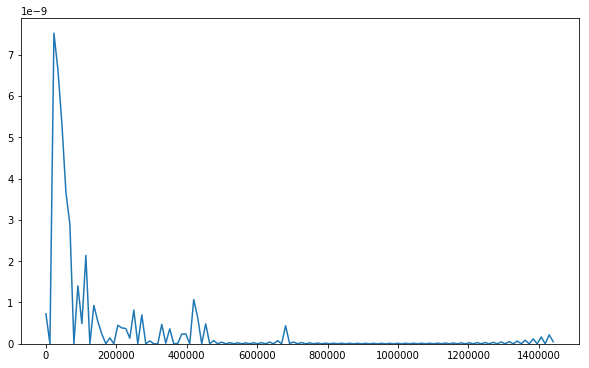

In [79]:
print('Total vocabulary count:', len(vocab_counts))
counts = [vocab_count[1] for vocab_count in vocab_counts]
plt.figure(figsize=(10, 6))
sns.kdeplot(np.array(counts))
plt.show()

In [80]:
vocab_counts

[('?', 1440772),
 ('the', 683541),
 ('What', 451702),
 ('is', 432858),
 ('to', 423823),
 ('a', 422145),
 ('', 422088),
 ('in', 389991),
 ('of', 347454),
 ('I', 327675),
 ('How', 274624),
 ('and', 265106),
 ('do', 248379),
 (',', 244580),
 ('are', 230025),
 ('for', 211525),
 ('you', 210359),
 ('Why', 151637),
 ('it', 146518),
 ('can', 138291),
 ('.', 132353),
 ('not', 116637),
 ('with', 115807),
 ('Is', 115302),
 ('that', 112086),
 ('my', 109027),
 ('on', 97956),
 ('have', 97851),
 ('or', 96303),
 ('be', 95515),
 ('"', 84567),
 ('does', 73072),
 ('from', 71516),
 ('your', 70169),
 ('an', 69944),
 ('if', 66796),
 ('get', 65336),
 ('best', 65175),
 ('-', 62524),
 ('(', 58273),
 (')', 58270),
 ('people', 58104),
 ('as', 58103),
 ('some', 56265),
 ('would', 55599),
 ('there', 55256),
 ('Can', 55105),
 ('like', 50956),
 ('should', 50914),
 ('when', 50333),
 ('Which', 49440),
 ('at', 48301),
 ('about', 47001),
 ('they', 44721),
 ('by', 44133),
 ('/', 42983),
 ('Do', 42758),
 ('will', 40626),


Train text max len: 201
Test text max len: 99


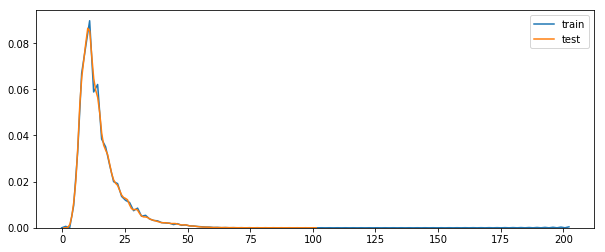

In [43]:
train_ques_lens = train_df['question_text'].map(lambda x: len(x.split(' ')))
test_ques_lens = test_df['question_text'].map(lambda x: len(x.split(' ')))
print('Train text max len:', train_ques_lens.max())
print('Test text max len:', test_ques_lens.max())
plt.figure(figsize=(10, 4))
sns.kdeplot(train_ques_lens)
sns.kdeplot(test_ques_lens)
plt.legend(('train', 'test'))
plt.show()
del train_ques_lens; del test_ques_lens
gc.collect()
pass

## Remove stop words

In [60]:
from nltk.corpus import stopwords

nltk_stop_words = set(stopwords.words('english'))

In [61]:
len(nltk_stop_words)

179

In [469]:
import string

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [69]:
should_removed_stopwords = []

for vocab_c in vocab_counts:
    if vocab_c[0] in nltk_stop_words:
        should_removed_stopwords.append(vocab_c[0])

capitalize_removed_stopwords = [word.capitalize() for word in should_removed_stopwords]
should_removed_stopwords = set(should_removed_stopwords + capitalize_removed_stopwords)

In [70]:
print(should_removed_stopwords)

{'my', 'and', 'hasn', 'Does', 'Ll', 'when', 'out', 'Other', 'up', 'It', 'an', 'And', 'such', 'Of', 'Than', 'or', 'Be', 'those', 'Is', 'you', 'aren', 'Did', 'Because', 'T', 'that', 'yourself', 'he', 'ours', 'itself', 'To', 'My', 'Aren', 'once', 'Wouldn', 'Both', 'them', 'Not', 'No', 'have', 'Itself', 'Some', 'Until', 'Once', 'During', 'Yours', 'Then', 'too', 'any', 'him', 'yours', 'from', 'on', 'they', 'herself', 'In', 'we', 'her', 'By', 'ma', 'haven', 'How', 'Out', 'She', 'don', 'The', 'Me', 'Being', 'While', 'Why', 'Are', 'can', 're', 'each', 'above', 'Who', 'An', 'your', 'Should', 'Re', 'Again', 'then', 'Them', 'at', 'being', 'D', 'there', 'Hers', 'are', 'will', 'ourselves', 'won', 'Where', 'where', 'Its', 'the', 'On', 'Nor', 'to', 'Doing', 'm', 'Above', 'Ma', 'with', 'other', 'only', 'does', 'Her', 'Under', 'myself', 'how', 'Been', 'his', 'because', 'but', 'had', 'here', 'Or', 'all', 'Doesn', 'Off', 'M', 'who', 'Do', 'Had', 'Any', 'When', 'Himself', 'I', 'themselves', 'Themselves', 

In [71]:
should_removed_stopwords = {'my', 'and', 'hasn', 'Does', 'Ll', 'when', 'out', 'Other', 'up', 'It', 'an', 'And', 'such', 'Of', 'Than', 'or', 'Be', 'those', 'Is', 'you', 'aren', 'Did', 'Because', 'T', 'that', 'yourself', 'he', 'ours', 'itself', 'To', 'My', 'Aren', 'once', 'Wouldn', 'Both', 'them', 'Not', 'No', 'have', 'Itself', 'Some', 'Until', 'Once', 'During', 'Yours', 'Then', 'too', 'any', 'him', 'yours', 'from', 'on', 'they', 'herself', 'In', 'we', 'her', 'By', 'ma', 'haven', 'How', 'Out', 'She', 'don', 'The', 'Me', 'Being', 'While', 'Why', 'Are', 'can', 're', 'each', 'above', 'Who', 'An', 'your', 'Should', 'Re', 'Again', 'then', 'Them', 'at', 'being', 'D', 'there', 'Hers', 'are', 'will', 'ourselves', 'won', 'Where', 'where', 'Its', 'the', 'On', 'Nor', 'to', 'Doing', 'm', 'Above', 'Ma', 'with', 'other', 'only', 'does', 'Her', 'Under', 'myself', 'how', 'Been', 'his', 'because', 'but', 'had', 'here', 'Or', 'all', 'Doesn', 'Off', 'M', 'who', 'Do', 'Had', 'Any', 'When', 'Himself', 'I', 'themselves', 'Themselves', 'You', 'Same', 'should', 'Down', 'These', 'wouldn', 'while', 'very', 'Your', 'More', 'His', 'during', 'off', 'Which', 'Too', 'so', 've', 'by', 'more', 'after', 'With', 'Him', 'Can', 'Didn', 'than', 'A', 'If', 'Has', 'Yourself', 'Below', 'own', 'a', 'Their', 'For', 'down', 'Haven', 'about', 'has', 'O', 'Shouldn', 'Few', 'There', 'Myself', 'Hasn', 'did', 'Don', 'whom', 'just', 'before', 'same', 'Theirs', 'shouldn', 'd', 'Only', 'Will', 'its', 'for', 'into', 'what', 'Own', 'our', 'their', 'until', 'nor', 'no', 'Such', 'After', 't', 'doesn', 'not', 'am', 'between', 'As', 'through', 'having', 'hers', 'y', 'Ve', 'Was', 'Against', 'Having', 'further', 'o', 'They', 'He', 'theirs', 'That', 'were', 'most', 'few', 'This', 'is', 'Between', 'Very', 'Our', 'What', 'Ourselves', 'Ours', 'Have', 'me', 'which', 'been', 'if', 'isn', 'couldn', 'again', 'At', 'Through', 'Y', 'Isn', 'in', 'do', 'as', 'it', 'was', 'Into', 'over', 'doing', 'Am', 'Here', 'she', 'some', 'About', 'why', 'All', 'Most', 'Before', 'Up', 'Over', 'From', 'But', 'Now', 'against', 'yourselves', 'be', 'this', 'under', 'll', 'both', 'i', 'Each', 'now', 'Couldn', 'of', 'Those', 'Won', 'We', 'Just', 'So', 'below', 'Whom', 'these', 'didn', 'himself', 'Further', 'Herself', 'Yourselves', 'Were'}
def remove_stopwords(text):
    return [t for t in text.split(' ') if t not in should_removed_stopwords]



In [1]:
# clean stopwords?
vocab_counts[:10]

NameError: name 'vocab_counts' is not defined